<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Finland/Outotec/Outotec_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "OTE1V.HE"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close   Volume
Date                                                          
2009-01-02  2.7800  2.9450  2.7775  2.9450     1.4576  1034628
2009-01-05  3.0125  3.0975  3.0125  3.0925     1.5306  1560436
2009-01-07  3.1725  3.2000  2.9500  3.0025     1.4860  1988080
2009-01-08  2.9550  2.9600  2.9000  2.9375     1.4539  1433708
2009-01-09  2.9425  2.9850  2.9125  2.9125     1.4415   882844
...            ...     ...     ...     ...        ...      ...
2018-12-19  3.0530  3.0840  3.0240  3.0430     3.0430  1100212
2018-12-20  3.0310  3.0310  2.9020  2.9250     2.9250  1534770
2018-12-21  2.9410  3.0230  2.8700  2.9280     2.9280  2406385
2018-12-27  2.9300  3.0440  2.8610  2.8820     2.8820  1084684
2018-12-28  2.8910  3.0880  2.8910  3.0740     3.0740  1417864

[2512 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2512.000000  2512.000000  2512.000000  2512.000000  2512.000000  2.512000e+03
mean      6.888313     7.000917     6.768525     6.883326     6.281856  1.211139e+06
std       2.360990     2.382157     2.337419     2.360445     2.215792  8.052738e+05
min       2.440000     2.475000     2.325000     2.400000     1.187800  0.000000e+00
25%       5.190000     5.320000     5.088750     5.211250     4.541500  7.183242e+05
50%       6.672500     6.798750     6.551250     6.676500     6.215000  1.031973e+06
75%       8.680000     8.825000     8.467500     8.636250     7.901025  1.480810e+06
max      12.862500    13.025000    12.737500    12.950000    12.094900  1.232889e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2009-03-16  3.4225  3.5475  3.3650  3.4050     1.6852  1864556   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  3.238624  3.003064  2.787543  3.321029  3.161361  3.142485     3.09375     3.13625  2.832938  3.077188  3.417197  3.066125  3.195764  3.077188  3.352500  2.938193                3.563246                 3.077188                2.591129                3.806275                 3.077188                2.348100                4.049304                 3.077188                2.105071                4.292333                 3.077188                1.862042  3.161361  3.335562  2.941747                3.647420                 3.161361                2.675303                3.890449                 3.161361                2.432274                4.133478                 3.161361                2.189245                4.376507                 3.161361   
2009-03-17  3.4200  3.4750  3.2750  3.3625     1.6642  2649656   17          1         76             31             0               0               0                 0      3        1    12        1             4          12  3.246309  3.010609  2.863538  3.365010  3.206059  3.202665     3.09375     3.13625  2.890103  3.145000  3.439249  3.167000  3.259167  3.145000  3.383750  2.962396                3.619855                 3.145000                2.670145                3.857283                 3.145000                2.432717                4.094710                 3.145000                2.195290                4.332138                 3.145000                1.957862  3.206059  3.367865  2.971202                3.680914                 3.206059                2.731204                3.918342                 3.206059                2.493776                4.155769                 3.206059                2.256348                4.393197                 3.206059   
2009-03-18  3.4050  3.4400  3.2875  3.3100     1.6382  1841112   18          2    

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2.462000e+03  2462.000000  2462.000000  2462.000000    2462.000000   2462.000000     2462.000000     2462.000000       2462.000000  2462.000000  2462.000000  2462.000000  2462.000000   2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000             2462.000000              2462.000000             2462.000000             2462.000000              2462.000000             2462.000000             2462.000000              2462.000000             2462.000000             2462.000000              2462.000000             2462.000000  2462.000000  2462.000000  2462.000000             2462.000000              2462.000000             2462.000000             2462.000000              2462.000000             2462.000000             2462.000000   
mean      6.969722     7.083247     6.849266     6.964721     6.380530  1.201441e+06    15.774574     1.985378   185.871243      30.457758      0.032088        0.028432        0.008936          0.008123     6.613323     2.539399    27.017872     1.985378      2.016247    27.017872     6.972901     6.980561    -0.624990     6.965014     6.964824     6.943930     6.963197     6.968046     6.973158     6.964943     6.964832     6.965000     6.964928     6.964943     6.964566     6.964261                7.326785                 6.964943                6.603102                7.507705                 6.964943                6.422182                7.688626                 6.964943                6.241261                7.869546                 6.964943                6.060340     6.964824     6.964696     6.964407                7.326665                 6.964824                6.602983                7.507586                 6.964824                6.422062                7.688506   
std       2.313738     2.334137     2.290379     2.313162     2.125988  8.037056e+05     8.730045     1.407225   103.153614       0.789793      0.176269        0.166238        0.094125          0.089782     3.382550     1.105503    14.751927     1.407225      1.410668    14.751927     2.297096     2.274941     7.340590     2.316413     2.299070     2.288136     2.300381     2.300599     2.324225     2.303352     2.315189     2.305351     2.304887     2.303352     2.310588     2.287923                2.371152                 2.303352                2.252871                2.411105                 2.303352                2.234508                2.454837                 2.303352                2.220891                2.502151                 2.303352                2.212108     2.299070     2.309256     2.290118                2.366593                 2.299070                2.248913                2.406426                 2.299070                2.230729                2.450049   
min       2.546000     2.574000     2.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-16  0.084961  0.093149  0.085744  0.086078   0.004495  1864556   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.055495  0.000000  0.621067  0.080175  0.050626  0.038124    0.047237    0.051207  0.032919  0.045148  0.093846  0.043482  0.058488  0.045148  0.076019  0.009383                0.077417                 0.045148                0.055497                0.093093                 0.045148                0.074696                0.107730                 0.045148                0.117320                0.121877                 0.045148                0.155800  0.050626  0.075960  0.013173                0.083204                 0.050626                0.072442                0.098313                 0.050626                0.094019                0.112862                 0.050626                0.135548                0.126924                 0.050626   
2009-03-17  0.084719  0.086212  0.076964  0.082009   0.002486  2649656   17          1         76             31             0               0               0                 0      3        1    12        1             4          12  0.056264  0.000792  0.624051  0.084433  0.055100  0.044376    0.047237    0.051207  0.038344  0.051870  0.095970  0.053491  0.064775  0.051870  0.079092  0.011875                0.082939                 0.051870                0.063024                0.098016                 0.051870                0.082455                0.112037                 0.051870                0.125075                0.125590                 0.051870                0.163545  0.055100  0.079130  0.016189                0.086492                 0.055100                0.077721                0.101005                 0.055100                0.099591                0.114977                 0.055100                0.141249                0.128481                 0.055100   
2009-03-18  0.083265  0.082863  0.078184  0.076982  

140550

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpr0cdnabo
  JVM stdout: /tmp/tmpr0cdnabo/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpr0cdnabo/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 7 days
H2O cluster name:           H2O_from_python_unknownUser_qnz16l
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_131302_mod...  0.521325  1.527593              0.500000  0.594449  0.353369
1              DeepLearning_1_AutoML_20190826_131302  0.514633  1.265695              0.500000  0.581840  0.338538
2  DeepLearning_grid_1_AutoML_20190826_131302_mod...  0.508990  0.941486              0.500000  0.537579  0.288991
3  DeepLearning_grid_1_AutoML_20190826_131302_mod...  0.506824  0.702542              0.500000  0.504602  0.254623
4  DeepLearning_grid_1_AutoML_20190826_131302_mod...  0.501083  0.706402              0.500000  0.506195  0.256233
5  DeepLearning_grid_1_AutoML_20190826_131302_mod...  0.493406  0.995743              0.456923  0.578642  0.334827
6  DeepLearning_grid_1_AutoML_20190826_131302_mod...  0.489829  0.698163              0.500000  0.502495  0.252501
7  DeepLearning_grid_1_AutoML_20190826_131302_mod...  0.489764  0.814488              0.492126  0.528573  0.279390
8  DeepLearning_grid_1_AutoML_20190826_131302_mod...  0.483793  1.168038              0.484941  0.584347  0.341461
9  DeepLearning_grid_1_AutoML_20190826_131302_mod...  0.467388  0.699668              0.496063  0.503238  0.253249

variable  relative_importance  scaled_importance  percentage
0                         TANH             1.000000           1.000000    0.002396
1            CDLDARKCLOUDCOVER             0.844570           0.844570    0.002024
2              CDLHOMINGPIGEON             0.839497           0.839497    0.002012
3               is_quarter_end             0.826945           0.826945    0.001982
4               CDLEVENINGSTAR             0.824641           0.824641    0.001976
...                        ...                  ...                ...         ...
1039  BBANDS_middleband_24_2_4             0.347919           0.347919    0.000834
1040                 MAVP_12_2             0.346132           0.346132    0.000829
1041                   MA_20_2             0.343517           0.343517    0.000823
1042   BBANDS_lowerband_20_1_3             0.343283           0.343283    0.000823
1043   BBANDS_upperband_12_7_5             0.341471           0.341471    0.000818

[1044 rows x 4 columns]

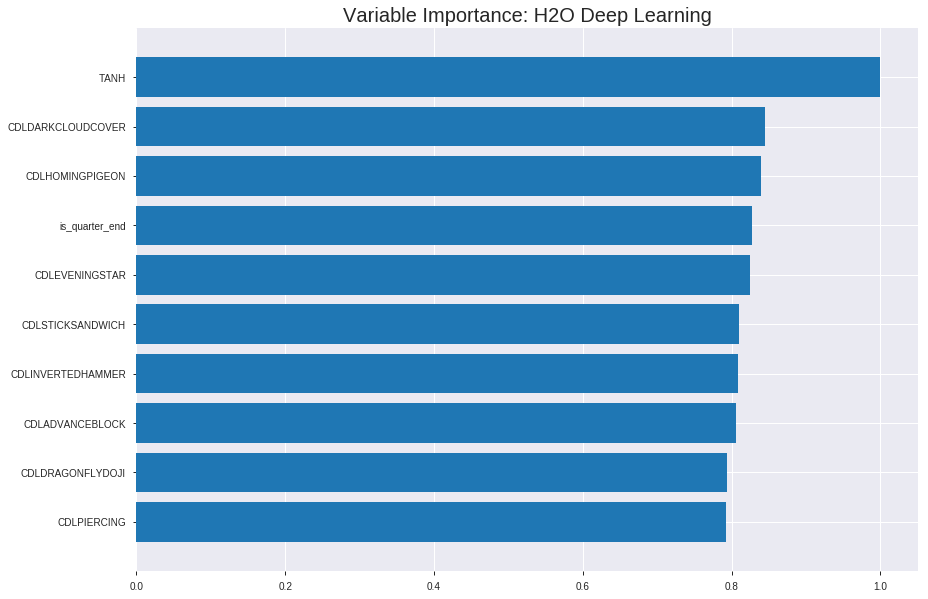

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_131302_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2572591057295624
RMSE: 0.5072071625377174
LogLoss: 0.9196763846811843
Mean Per-Class Error: 0.3357443576769452
AUC: 0.7195154029922421
pr_auc: 0.6775420404030434
Gini: 0.4390308059844843
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06476231188393924: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      274  589   0.6825   (589.0/863.0)
1      85   774   0.099    (85.0/859.0)
Total  359  1363  0.3914   (674.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0647623    0.69667   356
max f2                       0.00701746   0.837644  391
max f0point5                 0.600114     0.666417  164
max accuracy                 0.600114     0.664344  164
max precision                0.999839     0.921053  0
max recall                   4.40503e-05  1         399
max specificity              0.999839     0.996524  0
max absolute_mcc             0.600114     0.329771  164
max min_per_class_accuracy   0.512378     0.66007   194
max mean_per_class_accuracy  0.58821      0.664256  168

Gains/Lift Table: Avg response rate: 49.88 %, avg score: 50.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.999904           2.00466   2.00466            1                0.999969    1                           0.999969            0.0209546       0.0209546                  100.466   100.466
    2        0.0203252                   0.999668           1.41505   1.71828            0.705882         0.999806    0.857143                    0.99989             0.0139697       0.0349243                  41.5052   71.8277
    3        0.0301974                   0.999517           1.88674   1.77335            0.941176         0.999597    0.884615                    0.999794            0.0186263       0.0535506                  88.6736   77.335
    4        0.0400697                   0.999177           2.00466   1.83034            1                0.999422    0.913043                    0.999702            0.0197905       0.0733411                  100.466   83.0339
    5        0.0505226                   0.998401           1.67055   1.79728            0.833333         0.998745    0.896552                    0.999504            0.0174622       0.0908033                  67.0547   79.7278
    6        0.100465                    0.993567           1.49184   1.64544            0.744186         0.996419    0.820809                    0.99797             0.0745052       0.165308                   49.1837   64.5441
    7        0.150407                    0.982244           1.58508   1.6254             0.790698         0.988906    0.810811                    0.994961            0.0791618       0.24447                    58.5077   62.5397
    8        0.200348                    0.956881           1.28205   1.53981            0.639535         0.971312    0.768116                    0.989066            0.0640279       0.308498                   28.2048   53.9809
    9        0.300232                    0.8732             1.34032   1.47344            0.668605         0.920291    0.73501                     0.966185            0.133877        0.442375                   34.0323   47.3442
    10       0.400116                    0.715757           1.11888   1.38493            0.55814          0.798404    0.690856                    0.924301            0.111758        0.554133                   11.8878   38.493
    11       0.5                         0.509449           1.0606    1.32014            0.52907          0.612367    0.658537                    0.861986            0.105937        0.66007                    6.06032   32.014
    12       0.599884                    0.307292           0.909088  1.2517             0.453488         0.401892    0.624395                    0.785378            0.0908033       0.750873                   -9.09116  25.1697
    13       0.699768                    0.158659           0.815849  1.18949            0.406977         0.22546     0.593361                    0.705456            0.0814901       0.832363                   -18.4151  18.9485
    14       0.799652                    0.059554           0.722609  1.13117            0.360465         0.106941    0.56427                     0.630696            0.0721769       0.90454                    -27.7391  13.1168
    15       0.899535                    0.0110999          0.641024  1.07674            0.319767         0.0316846   0.537121                    0.564182            0.0640279       0.968568                   -35.8976  7.67426
    16       1                           3.73041e-15        0.312865  1                  0.156069         0.00367009  0.498839    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3787039850025042
RMSE: 0.6153892954890459
LogLoss: 1.5059152845962656
Mean Per-Class Error: 0.46062100213219614
AUC: 0.5316497867803838
pr_auc: 0.5639512211964933
Gini: 0.06329957356076754
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.258022822207157e-05: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    268  0        (0.0/268.0)
Total  0    492  0.4553   (224.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.25802e-05  0.705263   399
max f2                       2.25802e-05  0.856777   399
max f0point5                 0.000741465  0.600467   395
max accuracy                 0.0929145    0.554878   297
max precision                0.999479     0.875      2
max recall                   2.25802e-05  1          399
max specificity              0.999942     0.995536   0
max absolute_mcc             0.999479     0.0852676  2
max min_per_class_accuracy   0.228858     0.522321   218
max mean_per_class_accuracy  0.0929145    0.539379   297

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 33.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.999677           1.46866   1.46866            0.8              0.999891     0.8                         0.999891            0.0149254       0.0149254                  46.8657   46.8657
    2        0.0203252                   0.998796           1.10149   1.28507            0.6              0.999396     0.7                         0.999644            0.011194        0.0261194                  10.1493   28.5075
    3        0.0304878                   0.995431           0.734328  1.10149            0.4              0.997662     0.6                         0.998983            0.00746269      0.0335821                  -26.5672  10.1493
    4        0.0406504                   0.98787            1.10149   1.10149            0.6              0.99348      0.6                         0.997607            0.011194        0.0447761                  10.1493   10.1493
    5        0.050813                    0.971653           1.46866   1.17493            0.8              0.978569     0.64                        0.9938              0.0149254       0.0597015                  46.8657   17.4925
    6        0.101626                    0.876468           0.954627  1.06478            0.52             0.928848     0.58                        0.961324            0.0485075       0.108209                   -4.53731  6.47761
    7        0.150407                    0.773911           1.0709    1.06676            0.583333         0.824966     0.581081                    0.9171              0.0522388       0.160448                   7.08955   6.67608
    8        0.20122                     0.662817           0.954627  1.03844            0.52             0.706537     0.565657                    0.863927            0.0485075       0.208955                   -4.53731  3.84441
    9        0.300813                    0.491527           1.12397   1.06676            0.612245         0.56454      0.581081                    0.764806            0.11194         0.320896                   12.3972   6.67608
    10       0.400407                    0.379011           0.974109  1.04372            0.530612         0.433141     0.568528                    0.68231             0.0970149       0.41791                    -2.5891   4.37154
    11       0.5                         0.229199           1.01157   1.03731            0.55102          0.300413     0.565041                    0.606241            0.100746        0.518657                   1.15748   3.73134
    12       0.599593                    0.138225           1.08651   1.04548            0.591837         0.187355     0.569492                    0.536664            0.108209        0.626866                   8.65062   4.54844
    13       0.699187                    0.0743311          1.01157   1.04065            0.55102          0.105333     0.56686                     0.475224            0.100746        0.727612                   1.15748   4.06543
    14       0.79878                     0.0295563          0.899178  1.02301            0.489796         0.0522742    0.557252                    0.42249             0.0895522       0.817164                   -10.0822  2.30147
    15       0.898374                    0.00329812         0.899178  1.00929            0.489796         0.0132244    0.549774                    0.377119            0.0895522       0.906716                   -10.0822  0.928615
    16       1                           7.34177e-06        0.91791   1                  0.5              0.0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 13:13:07  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 13:13:12  7.223 sec         195 obs/sec       0.595819  1             1026       0.647171         3.6265              -0.675331      0.525867        0.3715             1.22507          0.501161                         0.623724           1.64474               -0.568672        0.496385          0.525888             0.367164           0.453252
    2019-08-26 13:13:32  26.454 sec        219 obs/sec       2.9216    5             5031       0.657488         4.16725             -0.72917       0.548574        0.519964           1.1137           0.501161                         0.72578            7.25768               -1.12401         0.505047          0.556088             1.83582            0.455285
    2019-08-26 13:13:51  45.714 sec        224 obs/sec       5.30023   9             9127       0.581731         1.83422             -0.353649      0.644172        0.482147           1.67055          0.454123                         0.637214           3.1855                -0.637261        0.524287          0.5213               1.46866            0.45122
    2019-08-26 13:14:10  1 min  4.722 sec  226 obs/sec       7.67015   13            13208      0.611647         2.38716             -0.496457      0.624555        0.449853           1.78192          0.475029                         0.658375           3.75939               -0.747808        0.526336          0.523275             1.04904            0.455285
    2019-08-26 13:14:25  1 min 19.976 sec  227 obs/sec       9.48722   16            16337      0.588605         2.15141             -0.385829      0.62692         0.436223           1.67055          0.413473                         0.651652           2.05559               -0.712295        0.512685          0.55114              1.46866            0.455285
    2019-08-26 13:14:44  1 min 38.966 sec  228 obs/sec       11.8833   20            20463      0.649157         5.4126              -0.685629      0.56747         0.457739           1.33644          0.501161                         0.660422           4.34754               -0.758696        0.516558          0.48547              1.0199             0.45122
    2019-08-26 13:14:59  1 min 53.322 sec  229 obs/sec       13.6626   23            23527      0.581876         2.77427             -0.354328      0.629244        0.374881           1.55918          0.4036                           0.632631           2.36262               -0.613793        0.518207          0.518573             1.10149            0.455285
    2019-08-26 13:15:17  2 min 11.974 sec  230 obs/sec       16.0226   27            27591      0.60468          3.0561              -0.462561      0.630779        0.377481           1.44781          0.39547                          0.647017           3.07856               -0.688026        0.545967          0.549015             1.10149            0.45122
    2019-08-26 13:15:36  2

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
TANH                      1.0                    1.0                  0.0023962541069157397
CDLDARKCLOUDCOVER         0.8445700407028198     0.8445700407028198   0.0020238044286121255
CDLHOMINGPIGEON           0.8394973874092102     0.8394973874092102   0.002011649062324354
is_quarter_end            0.8269445300102234     0.8269445300102234   0.001981569226228504
CDLEVENINGSTAR            0.824641227722168      0.824641227722168    0.001976049928661283
---                       ---                    ---                  ---
BBANDS_middleband_24_2_4  0.347919225692749      0.347919225692749    0.000833702873441194
MAVP_12_2                 0.3461322486400604     0.3461322486400604   0.0008294208223397248
MA_20_2                   0.3435167372226715     0.3435167372226715   0.0008231533923641216
BBANDS_lowerband_20_1_3   0.34328335523605347    0.34328335523605347  0.000822594149820208
BBANDS_upperband_12_7_5   0.3414710760116577     0.3414710760116577   0.0008182514682858715


See the whole table with table.as_data_frame()


('accuracy', 0.5668016194331984)

('F1', 0.6539509536784741)

('auc', 0.5213254593175852)

('logloss', 1.5275927535872895)

('mean_per_class_error', 0.4364173228346456)

('rmse', 0.5944485304000564)

('mse', 0.35336905529478685)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


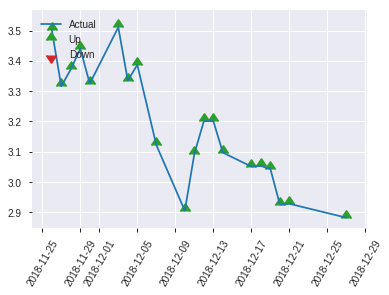


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.35336905529478685
RMSE: 0.5944485304000564
LogLoss: 1.5275927535872895
Mean Per-Class Error: 0.4364173228346456
AUC: 0.5213254593175852
pr_auc: 0.49305245136864806
Gini: 0.042650918635170454
Confusion Matrix (Act/Pred) for max f1 @ threshold = 5.875489746148344e-05: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    127  1        (127.0/127.0)
1      0    120  0        (0.0/120.0)
Total  0    247  0.5142   (127.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       5.87549e-05  0.653951  245
max f2                       5.87549e-05  0.825309  245
max f0point5                 0.0250719    0.542829  219
max accuracy                 0.711737     0.566802  71
max precision                0.711737     0.589041  71
max recall                   5.87549e-05  1         245
max specificity              1            0.984252  0
max absolute_mcc             0.00352892   0.147873  240
max min_per_class_accuracy   0.425274     0.533333  121
max mean_per_class_accuracy  0.579765     0.563583  93

Gains/Lift Table: Avg response rate: 48.58 %, avg score: 44.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.999996           0.686111  0.686111           0.333333         1         0.333333                    1                   0.00833333      0.00833333                 -31.3889  -31.3889
    2        0.0202429                   0.998255           0         0.411667           0                0.999978  0.2                         0.999991            0               0.00833333                 -100      -58.8333
    3        0.0323887                   0.982653           1.37222   0.771875           0.666667         0.988112  0.375                       0.995537            0.0166667       0.025                      37.2222   -22.8125
    4        0.0404858                   0.980356           1.02917   0.823333           0.5              0.982093  0.4                         0.992848            0.00833333      0.0333333                  2.91667   -17.6667
    5        0.0526316                   0.972242           0         0.633333           0                0.977277  0.307692                    0.989255            0               0.0333333                  -100      -36.6667
    6        0.101215                    0.933481           1.54375   1.07033            0.75             0.950424  0.52                        0.970616            0.075           0.108333                   54.375    7.03333
    7        0.149798                    0.902185           0.686111  0.945721           0.333333         0.915974  0.459459                    0.952894            0.0333333       0.141667                   -31.3889  -5.42793
    8        0.202429                    0.827183           1.10833   0.988              0.538462         0.86132   0.48                        0.929085            0.0583333       0.2                        10.8333   -1.2
    9        0.299595                    0.708399           1.62951   1.19606            0.791667         0.766716  0.581081                    0.876425            0.158333        0.358333                   62.9514   19.6059
    10       0.40081                     0.56706            0.905667  1.12273            0.44             0.631972  0.545455                    0.814694            0.0916667       0.45                       -9.43333  12.2727
    11       0.502024                    0.418648           0.823333  1.06237            0.4              0.489462  0.516129                    0.749123            0.0833333       0.533333                   -17.6667  6.23656
    12       0.59919                     0.25467            0.428819  0.959628           0.208333         0.332054  0.466216                    0.68149             0.0416667       0.575                      -57.1181  -4.03716
    13       0.700405                    0.137018           1.235     0.999422           0.6              0.182703  0.485549                    0.609411            0.125           0.7                        23.5      -0.0578035
    14       0.797571                    0.0680144          1.11493   1.01349            0.541667         0.105068  0.492386                    0.547968            0.108333        0.808333                   11.4931   1.34941
    15       0.898785                    0.0249752          0.988     1.01062            0.48             0.043998  0.490991                    0.491215            0.1             0.908333                   -1.2      1.06231
    16       1                           5.87549e-05        0.905667  1                  0.44             0.010385  0.48583                     0.442548  

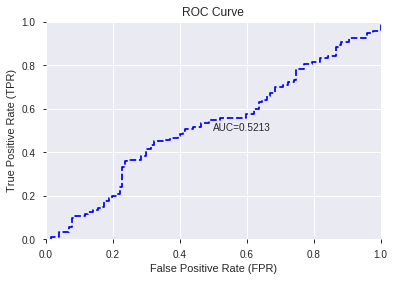

This function is available for GLM models only


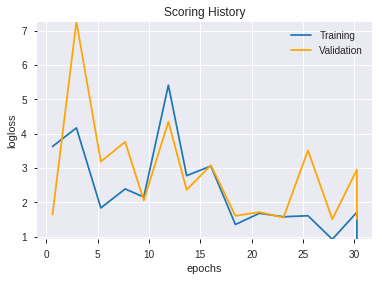

--2019-08-26 13:48:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.88.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.88.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  62.5MB/s    in 5.8s    

2019-08-26 13:48:07 (60.8 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unkno

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_131302_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_131302_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a2a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_134816_model_6  0.528182  0.732580              0.496063  0.513742  0.263931
1  DeepLearning_grid_1_AutoML_20190826_134816_model_3  0.502297  0.796009              0.500000  0.527340  0.278087
2  DeepLearning_grid_1_AutoML_20190826_134816_model_4  0.500394  0.822315              0.500000  0.534893  0.286111
3  DeepLearning_grid_1_AutoML_20190826_134816_model_8  0.498589  0.695087              0.500000  0.500971  0.250972
4  DeepLearning_grid_1_AutoML_20190826_134816_model_2  0.483924  0.839639              0.500000  0.528546  0.279361
5               DeepLearning_1_AutoML_20190826_134816  0.479199  0.776700              0.500000  0.529587  0.280462
6  DeepLearning_grid_1_AutoML_20190826_134816_model_7  0.475066  0.813439              0.500000  0.535453  0.286709
7  DeepLearning_grid_1_AutoML_20190826_134816_model_5  0.462205  0.706813              0.484252  0.506701  0.256746
8  DeepLearning_grid_1_AutoML_20190826_134816_model_1  0.457152  1.027278              0.500000  0.556953  0.310197
9  DeepLearning_grid_1_AutoML_20190826_134816_model_9  0.432349  0.701330              0.496063  0.504056  0.254072

variable  relative_importance  scaled_importance  percentage
0                  TANH             1.000000           1.000000    0.026093
1                VAR_14             0.944023           0.944023    0.024632
2                  ATAN             0.937976           0.937976    0.024475
3                  SINH             0.926426           0.926426    0.024173
4                VAR_30             0.913310           0.913310    0.023831
5                VAR_12             0.911973           0.911973    0.023796
6                   EXP             0.904170           0.904170    0.023592
7                  COSH             0.900300           0.900300    0.023492
8          HT_TRENDMODE             0.895065           0.895065    0.023355
9                VAR_24             0.873158           0.873158    0.022783
10    CDLSTALLEDPATTERN             0.802585           0.802585    0.020942
11               VAR_20             0.802124           0.802124    0.020930
12      CDLHOMINGPIGEON             0.793460           0.793460    0.020704
13       is_month_start             0.787633           0.787633    0.020552
14    CDLINVERTEDHAMMER             0.780206           0.780206    0.020358
15     CDLSTICKSANDWICH             0.777320           0.777320    0.020283
16         CDLTHRUSTING             0.777085           0.777085    0.020276
17       CDLMATCHINGLOW             0.770593           0.770593    0.020107
18          CDLPIERCING             0.769815           0.769815    0.020087
19              CDLDOJI             0.761331           0.761331    0.019865
20      CDLLADDERBOTTOM             0.755307           0.755307    0.019708
21   CDLEVENINGDOJISTAR             0.748900           0.748900    0.019541
22   CDLMORNINGDOJISTAR             0.745385           0.745385    0.019449
23            CDLHAMMER             0.738472           0.738472    0.019269
24    CDLLONGLEGGEDDOJI             0.737972           0.737972    0.019256
25       is_quarter_end             0.736008           0.736008    0.019205
26      CDLADVANCEBLOCK             0.735948           0.735948    0.019203
27      CDLSHOOTINGSTAR             0.735878           0.735878    0.019201
28      CDLUNIQUE3RIVER             0.733856           0.733856    0.019148
29         is_month_end             0.733784           0.733784    0.019147
30    CDLGRAVESTONEDOJI             0.733153           0.733153    0.019130
31        CDLHANGINGMAN             0.731260           0.731260    0.019081
32     is_quarter_start             0.728983           0.728983    0.019021
33       CDLRICKSHAWMAN             0.727496           0.727496    0.018983
34       CDLMORNINGSTAR             0.712879           0.712879    0.018601
35     CDLCOUNTERATTACK             0.712510           0.712510    0.018592
36       CDLEVENINGSTAR             0.700990           0.700990    0.018291
37            CDLTAKURI             0.700115           0.700115    0.018268
38  CDLRISEFALL3METHODS             0.693837           0.693837    0.018104
39   CDLSEPARATINGLINES             0.691010           0.691010    0.018031
40       CDL3LINESTRIKE             0.689924           0.689924    0.018002
41            CDL2CROWS             0.687395           0.687395    0.017936
42    CDL3WHITESOLDIERS             0.686737           0.686737    0.017919
43       CDLHARAMICROSS             0.681542           0.681542    0.017783
44    CDLDARKCLOUDCOVER             0.679105           0.679105    0.017720
45            CDLONNECK             0.674216           0.674216    0.017592
46   CDLUPSIDEGAP2CROWS             0.672284           0.672284    0.017542
47   CDLIDENTICAL3CROWS             0.667684           0.667684    0.017422
48     CDLDRAGONFLYDOJI             0.665524           0.665524    0.017366
49  CDLGAPSIDESIDEWHITE             0.657788           0.657788    0.017164

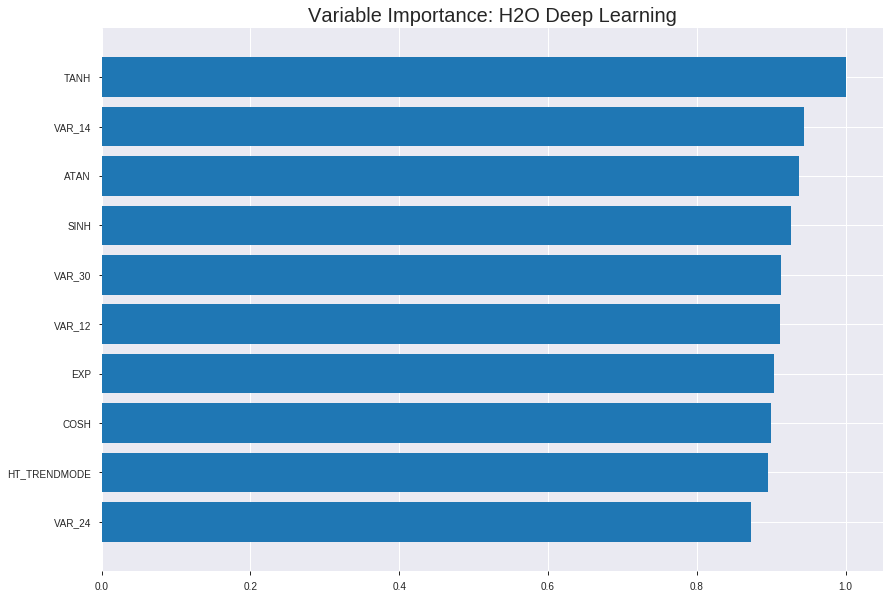

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_134816_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24238838462017548
RMSE: 0.4923295487985415
LogLoss: 0.6756007519438546
Mean Per-Class Error: 0.42947416557289264
AUC: 0.5963710531392103
pr_auc: 0.6058631096404778
Gini: 0.1927421062784207
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44351618965162504: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      55   808   0.9363   (808.0/863.0)
1      3    856   0.0035   (3.0/859.0)
Total  58   1664  0.471    (811.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.443516     0.678557  347
max f2                       0.443516     0.839216  347
max f0point5                 0.534368     0.572432  275
max accuracy                 0.552247     0.570848  216
max precision                0.992724     1         0
max recall                   0.326409     1         374
max specificity              0.992724     1         0
max absolute_mcc             0.443516     0.16695   347
max min_per_class_accuracy   0.550089     0.545984  229
max mean_per_class_accuracy  0.551654     0.570526  219

Gains/Lift Table: Avg response rate: 49.88 %, avg score: 55.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010453                    0.82195            1.89329   1.89329            0.944444         0.885022  0.944444                    0.885022            0.0197905       0.0197905                  89.3287    89.3287
    2        0.0203252                   0.763358           1.53297   1.71828            0.764706         0.791232  0.857143                    0.839467            0.0151339       0.0349243                  53.2973    71.8277
    3        0.0301974                   0.72757            1.53297   1.6577             0.764706         0.744155  0.826923                    0.808307            0.0151339       0.0500582                  53.2973    65.7697
    4        0.0400697                   0.705324           1.53297   1.62697            0.764706         0.715729  0.811594                    0.785498            0.0151339       0.0651921                  53.2973    62.6968
    5        0.0505226                   0.680483           1.55918   1.61294            0.777778         0.692006  0.804598                    0.766155            0.016298        0.0814901                  55.9177    61.2942
    6        0.100465                    0.602129           1.21212   1.41369            0.604651         0.639969  0.705202                    0.703427            0.0605355       0.142026                   21.2118    41.3688
    7        0.150407                    0.571993           1.18881   1.33902            0.593023         0.584191  0.667954                    0.663835            0.0593714       0.201397                   18.8808    33.9018
    8        0.200348                    0.56025            1.07226   1.27252            0.534884         0.566071  0.634783                    0.639465            0.0535506       0.254948                   7.22582    27.2521
    9        0.300232                    0.552451           1.10722   1.21753            0.552326         0.554474  0.60735                     0.611189            0.110594        0.365541                   10.7223    21.7528
    10       0.400116                    0.550911           0.990673  1.1609             0.494186         0.551697  0.5791                      0.596338            0.0989523       0.464494                   -0.932669  16.0897
    11       0.5                         0.549961           0.909088  1.11059            0.453488         0.550399  0.554007                    0.587161            0.0908033       0.555297                   -9.09116   11.0594
    12       0.599884                    0.549008           1.01398   1.09451            0.505814         0.549504  0.545983                    0.580891            0.101281        0.656577                   1.39833    9.45076
    13       0.699768                    0.547836           0.979018  1.07802            0.488372         0.548468  0.537759                    0.576263            0.0977881       0.754366                   -2.09817   7.80228
    14       0.799652                    0.546586           0.839159  1.04819            0.418605         0.547291  0.522876                    0.572644            0.0838184       0.838184                   -16.0841   4.81864
    15       0.899535                    0.527468           0.990673  1.0418             0.494186         0.542163  0.51969                     0.569259            0.0989523       0.937136                   -0.932669  4.18002
    16       1                           0.0242124          0.625731  1                  0.312139         0.427869  0.498839                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24808770748992298
RMSE: 0.4980840365740735
LogLoss: 0.6970213518358455
Mean Per-Class Error: 0.4444629530916845
AUC: 0.5340401785714286
pr_auc: 0.5818272094867901
Gini: 0.0680803571428572
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5047874674354458: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   209  0.933    (209.0/224.0)
1      3    265  0.0112   (3.0/268.0)
Total  18   474  0.4309   (212.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504787     0.714286  381
max f2                       0.363686     0.858974  395
max f0point5                 0.538785     0.613252  372
max accuracy                 0.538785     0.571138  372
max precision                0.993903     1         0
max recall                   0.363686     1         395
max specificity              0.993903     1         0
max absolute_mcc             0.504787     0.147934  381
max min_per_class_accuracy   0.551219     0.507463  213
max mean_per_class_accuracy  0.569229     0.555537  130

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 58.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.932825           1.10149   1.10149            0.6              0.973478  0.6                         0.973478            0.011194        0.011194                   10.1493   10.1493
    2        0.0203252                   0.916876           1.83582   1.46866            1                0.927573  0.8                         0.950526            0.0186567       0.0298507                  83.5821   46.8657
    3        0.0304878                   0.896544           0.734328  1.22388            0.4              0.907024  0.666667                    0.936025            0.00746269      0.0373134                  -26.5672  22.3881
    4        0.0406504                   0.824488           1.10149   1.19328            0.6              0.849219  0.65                        0.914324            0.011194        0.0485075                  10.1493   19.3284
    5        0.050813                    0.794033           1.10149   1.17493            0.6              0.816234  0.64                        0.894706            0.011194        0.0597015                  10.1493   17.4925
    6        0.101626                    0.715617           1.17493   1.17493            0.64             0.749587  0.64                        0.822146            0.0597015       0.119403                   17.4925   17.4925
    7        0.150407                    0.658926           1.14739   1.16599            0.625            0.686622  0.635135                    0.778193            0.0559701       0.175373                   14.7388   16.5994
    8        0.20122                     0.602687           1.10149   1.14971            0.6              0.620474  0.626263                    0.738365            0.0559701       0.231343                   10.1493   14.9706
    9        0.300813                    0.563794           1.08651   1.12878            0.591837         0.57599   0.614865                    0.684606            0.108209        0.339552                   8.65062   12.8782
    10       0.400407                    0.552772           0.78678   1.04372            0.428571         0.555858  0.568528                    0.652582            0.0783582       0.41791                    -21.322   4.37154
    11       0.5                         0.550986           0.899178  1.01493            0.489796         0.551969  0.552846                    0.632542            0.0895522       0.507463                   -10.0822  1.49254
    12       0.599593                    0.548942           0.974109  1.00815            0.530612         0.55001   0.549153                    0.618833            0.0970149       0.604478                   -2.5891   0.814571
    13       0.699187                    0.547625           1.04904   1.01397            0.571429         0.548266  0.552326                    0.608781            0.104478        0.708955                   4.90405   1.39708
    14       0.79878                     0.546777           1.01157   1.01367            0.55102          0.547248  0.552163                    0.601109            0.100746        0.809701                   1.15748   1.36721
    15       0.898374                    0.545021           1.12397   1.0259             0.612245         0.545985  0.558824                    0.594998            0.11194         0.921642                   12.3972   2.58999
    16       1                           0.0230376          0.771045  1                  0.42             0.478663  0.544715                    0.583175        


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 13:52:59  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 13:53:01  2 min 25.793 sec  878 obs/sec       1         1             1722       0.539487         0.821582            -0.16419       0.515769        0.525297           1.55918          0.500581                         0.510654           0.72833               -0.0514781       0.564416          0.588543             1.46866            0.45122
    2019-08-26 13:53:11  2 min 34.947 sec  2002 obs/sec      12        12            20664      0.498596         0.689891            0.00560356     0.560326        0.569624           1.78192          0.483159                         0.500632           0.6984                -0.0106113       0.525695          0.573777             1.46866            0.45122
    2019-08-26 13:53:19  2 min 43.472 sec  2382 obs/sec      25        25            43050      0.496715         0.685382            0.0130913      0.565251        0.576564           1.78192          0.473287                         0.500027           0.699048              -0.0081711       0.57576           0.601262             1.46866            0.443089
    2019-08-26 13:53:27  2 min 51.578 sec  2576 obs/sec      38        38            65436      0.49233          0.675601            0.0304412      0.596371        0.605863           1.89329          0.470964                         0.498084           0.697021              -0.000351526     0.53404           0.581827             1.10149            0.430894
    2019-08-26 13:53:35  2 min 59.729 sec  2731 obs/sec      52        52            89544      0.489774         0.669564            0.0404804      0.614657        0.630818           1.89329          0.455865                         0.500622           0.713014              -0.0105727       0.520722          0.57076              1.10149            0.428862
    2019-08-26 13:53:43  3 min  7.497 sec  2814 obs/sec      65        65            111930     0.486364         0.662096            0.0537953      0.634486        0.648845           2.00466          0.450058                         0.497589           0.697454              0.00163401       0.520839          0.571497             1.10149            0.432927
    2019-08-26 13:53:44  3 min  8.285 sec  2813 obs/sec      65        65            111930     0.49233          0.675601            0.0304412      0.596371        0.605863           1.89329          0.470964                         0.498084           0.697021              -0.000351526     0.53404           0.581827             1.10149            0.430894

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
TANH                 1.0                    1.0                  0.026092973899741252
VAR_14               0.9440225958824158     0.9440225958824158   0.024632356955125858
ATAN                 0.9379755258560181     0.9379755258560181   0.024474570914757153
SINH                 0.9264259338378906     0.9264259338378906   0.024173207711675495
VAR_30               0.9133101105690002     0.9133101105690002   0.02383097687744672
---                  ---                    ---                  ---
CDLONNECK            0.6742162108421326     0.6742162108421326   0.01759230599228621
CDLUPSIDEGAP2CROWS   0.672283947467804      0.672283947467804    0.017541887494492425
CDLIDENTICAL3CROWS   0.6676836609840393     0.6676836609840393   0.017421852339340224
CDLDRAGONFLYDOJI     0.6655240058898926     0.6655240058898926   0.01736550051533621
CDLGAPSIDESIDEWHITE  0.6577877402305603     0.6577877402305603   0.01716363833740579


See the whole table with table.as_data_frame()


('accuracy', 0.5425101214574899)

('F1', 0.6557377049180327)

('auc', 0.5281824146981627)

('logloss', 0.7325799414460856)

('mean_per_class_error', 0.4545275590551181)

('rmse', 0.513741732624937)

('mse', 0.26393056784047236)

deeplearning prediction progress: |███████████████████████████████████████| 100%


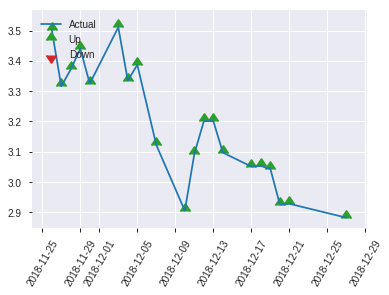


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.26393056784047236
RMSE: 0.513741732624937
LogLoss: 0.7325799414460856
Mean Per-Class Error: 0.4545275590551181
AUC: 0.5281824146981627
pr_auc: 0.5114240230459037
Gini: 0.05636482939632548
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3550195897183047: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    126  0.9921   (126.0/127.0)
1      0    120  0        (0.0/120.0)
Total  1    246  0.5101   (126.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35502      0.655738  244
max f2                       0.35502      0.826446  244
max f0point5                 0.549204     0.552326  183
max accuracy                 0.550228     0.54251   138
max precision                0.842843     0.833333  5
max recall                   0.35502      1         244
max specificity              0.990244     0.992126  0
max absolute_mcc             0.842843     0.109706  5
max min_per_class_accuracy   0.550441     0.527559  123
max mean_per_class_accuracy  0.549974     0.545472  148

Gains/Lift Table: Avg response rate: 48.58 %, avg score: 57.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.888207           1.37222   1.37222            0.666667         0.925179  0.666667                    0.925179            0.0166667       0.0166667                  37.2222   37.2222
    2        0.0202429                   0.843876           2.05833   1.64667            1                0.871151  0.8                         0.903568            0.0166667       0.0333333                  105.833   64.6667
    3        0.0323887                   0.82254            0.686111  1.28646            0.333333         0.839578  0.625                       0.879572            0.00833333      0.0416667                  -31.3889  28.6458
    4        0.0404858                   0.789951           1.02917   1.235              0.5              0.798412  0.6                         0.86334             0.00833333      0.05                       2.91667   23.5
    5        0.0526316                   0.752237           1.37222   1.26667            0.666667         0.769814  0.615385                    0.841757            0.0166667       0.0666667                  37.2222   26.6667
    6        0.101215                    0.692933           0.857639  1.07033            0.416667         0.719873  0.52                        0.783253            0.0416667       0.108333                   -14.2361  7.03333
    7        0.149798                    0.60812            0.857639  1.00135            0.416667         0.64486   0.486486                    0.738368            0.0416667       0.15                       -14.2361  0.135135
    8        0.202429                    0.581195           1.26667   1.07033            0.615385         0.596863  0.52                        0.701577            0.0666667       0.216667                   26.6667   7.03333
    9        0.299595                    0.552776           0.943403  1.02917            0.458333         0.563944  0.5                         0.656939            0.0916667       0.308333                   -5.65972  2.91667
    10       0.40081                     0.551122           0.988     1.01877            0.48             0.551969  0.494949                    0.630432            0.1             0.408333                   -1.2      1.8771
    11       0.502024                    0.550441           1.235     1.06237            0.6              0.550807  0.516129                    0.614378            0.125           0.533333                   23.5      6.23656
    12       0.59919                     0.549986           1.11493   1.07089            0.541667         0.550239  0.52027                     0.603977            0.108333        0.641667                   11.4931   7.08896
    13       0.700405                    0.549668           0.823333  1.03512            0.4              0.549818  0.50289                     0.596151            0.0833333       0.725                      -17.6667  3.51156
    14       0.797571                    0.548659           0.943403  1.02394            0.458333         0.549146  0.497462                    0.590424            0.0916667       0.816667                   -5.65972  2.39425
    15       0.898785                    0.544714           0.823333  1.00135            0.4              0.547691  0.486486                    0.585612            0.0833333       0.9                        -17.6667  0.135135
    16       1                           0.347055           0.988     1                  0.48             0.500072  0.48583                     0.576954           

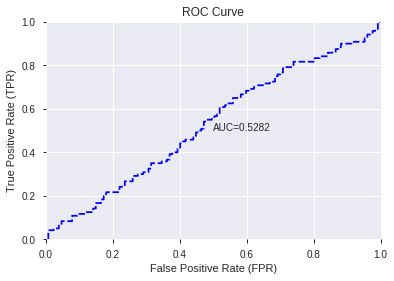

This function is available for GLM models only


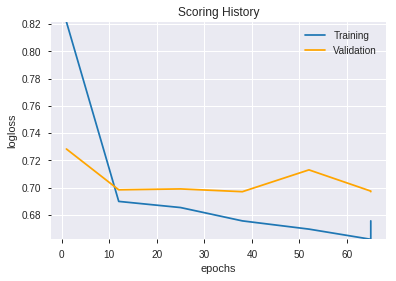

--2019-08-26 13:58:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_134816_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_134816_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a2a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TANH',
 'VAR_14',
 'ATAN',
 'SINH',
 'VAR_30',
 'VAR_12',
 'EXP',
 'COSH',
 'HT_TRENDMODE',
 'VAR_24',
 'CDLSTALLEDPATTERN',
 'VAR_20',
 'CDLHOMINGPIGEON',
 'is_month_start',
 'CDLINVERTEDHAMMER',
 'CDLSTICKSANDWICH',
 'CDLTHRUSTING',
 'CDLMATCHINGLOW',
 'CDLPIERCING',
 'CDLDOJI',
 'CDLLADDERBOTTOM',
 'CDLEVENINGDOJISTAR',
 'CDLMORNINGDOJISTAR',
 'CDLHAMMER',
 'CDLLONGLEGGEDDOJI',
 'is_quarter_end',
 'CDLADVANCEBLOCK',
 'CDLSHOOTINGSTAR',
 'CDLUNIQUE3RIVER',
 'is_month_end',
 'CDLGRAVESTONEDOJI',
 'CDLHANGINGMAN',
 'is_quarter_start',
 'CDLRICKSHAWMAN',
 'CDLMORNINGSTAR',
 'CDLCOUNTERATTACK',
 'CDLEVENINGSTAR',
 'CDLTAKURI',
 'CDLRISEFALL3METHODS',
 'CDLSEPARATINGLINES',
 'CDL3LINESTRIKE',
 'CDL2CROWS',
 'CDL3WHITESOLDIERS',
 'CDLHARAMICROSS',
 'CDLDARKCLOUDCOVER',
 'CDLONNECK',
 'CDLUPSIDEGAP2CROWS',
 'CDLIDENTICAL3CROWS',
 'CDLDRAGONFLYDOJI',
 'CDLGAPSIDESIDEWHITE']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_135828_model_1  0.492717  0.69381                   0.5  0.500312  0.250312

variable  relative_importance  scaled_importance  percentage
0     CDLSTALLEDPATTERN             0.030662           1.000000    0.063512
1      CDLSTICKSANDWICH             0.027312           0.890737    0.056573
2                  TANH             0.023719           0.773558    0.049131
3    CDLEVENINGDOJISTAR             0.023163           0.755421    0.047979
4             CDLONNECK             0.019723           0.643217    0.040852
5             CDL2CROWS             0.019114           0.623364    0.039591
6       CDLHOMINGPIGEON             0.018462           0.602106    0.038241
7        is_month_start             0.017903           0.583888    0.037084
8       CDLUNIQUE3RIVER             0.013727           0.447684    0.028433
9     CDL3WHITESOLDIERS             0.013599           0.443502    0.028168
10    CDLINVERTEDHAMMER             0.013579           0.442855    0.028127
11   CDLUPSIDEGAP2CROWS             0.013518           0.440863    0.028000
12       CDLHARAMICROSS             0.013489           0.439924    0.027941
13       CDL3LINESTRIKE             0.013468           0.439220    0.027896
14     CDLCOUNTERATTACK             0.013460           0.438988    0.027881
15    CDLDARKCLOUDCOVER             0.013270           0.432779    0.027487
16   CDLIDENTICAL3CROWS             0.013226           0.431354    0.027396
17        CDLHANGINGMAN             0.013087           0.426809    0.027108
18            CDLTAKURI             0.012884           0.420182    0.026687
19     CDLDRAGONFLYDOJI             0.012883           0.420159    0.026685
20                 ATAN             0.012854           0.419222    0.026626
21       CDLMATCHINGLOW             0.012632           0.411963    0.026165
22  CDLRISEFALL3METHODS             0.012462           0.406433    0.025814
23         is_month_end             0.010482           0.341867    0.021713
24       is_quarter_end             0.007863           0.256428    0.016286
25  CDLGAPSIDESIDEWHITE             0.007271           0.237139    0.015061
26     is_quarter_start             0.006929           0.225963    0.014351
27               VAR_14             0.006625           0.216048    0.013722
28      CDLLADDERBOTTOM             0.006341           0.206800    0.013134
29   CDLSEPARATINGLINES             0.005891           0.192116    0.012202
30          CDLPIERCING             0.005830           0.190126    0.012075
31      CDLADVANCEBLOCK             0.004887           0.159392    0.010123
32         CDLTHRUSTING             0.004359           0.142146    0.009028
33       CDLMORNINGSTAR             0.004005           0.130618    0.008296
34    CDLLONGLEGGEDDOJI             0.003094           0.100907    0.006409
35                  EXP             0.003086           0.100630    0.006391
36                 SINH             0.003074           0.100251    0.006367
37                 COSH             0.003066           0.099989    0.006351
38    CDLGRAVESTONEDOJI             0.002899           0.094544    0.006005
39      CDLSHOOTINGSTAR             0.002861           0.093300    0.005926
40               VAR_30             0.002811           0.091689    0.005823
41            CDLHAMMER             0.002611           0.085159    0.005409
42               VAR_12             0.002229           0.072699    0.004617
43              CDLDOJI             0.001836           0.059864    0.003802
44               VAR_20             0.001485           0.048443    0.003077
45         HT_TRENDMODE             0.001360           0.044368    0.002818
46       CDLRICKSHAWMAN             0.001198           0.039056    0.002481
47   CDLMORNINGDOJISTAR             0.001112           0.036277    0.002304
48               VAR_24             0.000689           0.022473    0.001427
49       CDLEVENINGSTAR             0.000688           0.022431    0.001425

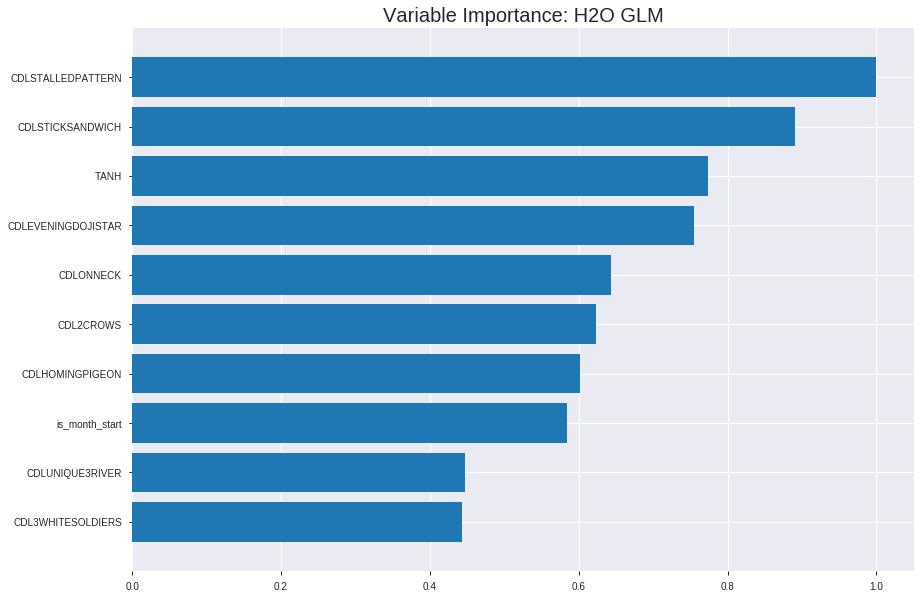

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_135828_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2471186613276176
RMSE: 0.4971103110252468
LogLoss: 0.6873014809717851
Null degrees of freedom: 1721
Residual degrees of freedom: 1671
Null deviance: 2387.1895983186078
Residual deviance: 2367.066300466828
AIC: 2469.066300466828
AUC: 0.5521335676910147
pr_auc: 0.563351891712702
Gini: 0.10426713538202947
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43299937465397326: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      20   843   0.9768   (843.0/863.0)
1      1    858   0.0012   (1.0/859.0)
Total  21   1701  0.4901   (844.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432999     0.670313  382
max f2                       0.432999     0.835118  382
max f0point5                 0.489267     0.566144  292
max accuracy                 0.49738      0.544135  215
max precision                0.666105     1         0
max recall                   0.428788     1         387
max specificity              0.666105     1         0
max absolute_mcc             0.535011     0.107938  53
max min_per_class_accuracy   0.496191     0.519119  229
max mean_per_class_accuracy  0.49738      0.543942  215

Gains/Lift Table: Avg response rate: 49.88 %, avg score: 49.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010453                    0.563551           1.67055   1.67055            0.833333         0.605274  0.833333                    0.605274            0.0174622       0.0174622                  67.0547    67.0547
    2        0.0203252                   0.552394           1.17921   1.4319             0.588235         0.555108  0.714286                    0.580908            0.0116414       0.0291036                  17.921     43.1898
    3        0.0301974                   0.544576           1.88674   1.58059            0.941176         0.549355  0.788462                    0.570593            0.0186263       0.0477299                  88.6736    58.0595
    4        0.0400697                   0.537096           1.17921   1.4817             0.588235         0.540685  0.73913                     0.563224            0.0116414       0.0593714                  17.921     48.1703
    5        0.0505226                   0.533158           1.1137    1.40556            0.555556         0.534522  0.701149                    0.557286            0.0116414       0.0710128                  11.3698    40.5564
    6        0.100465                    0.520368           1.1655    1.28622            0.581395         0.527059  0.641618                    0.54226             0.0582072       0.12922                    16.5498    28.6225
    7        0.150407                    0.510375           1.00233   1.19196            0.5              0.514336  0.594595                    0.532988            0.0500582       0.179278                   0.232829   19.1958
    8        0.200348                    0.503824           1.04895   1.15631            0.523256         0.506987  0.576812                    0.526506            0.0523865       0.231665                   4.89482    15.6309
    9        0.300232                    0.498961           1.10722   1.13998            0.552326         0.500949  0.568665                    0.518004            0.110594        0.342258                   10.7223    13.9979
    10       0.400116                    0.497512           1.00233   1.10562            0.5              0.498125  0.551524                    0.513041            0.100116        0.442375                   0.232829   10.5616
    11       0.5                         0.496169           0.792539  1.04307            0.395349         0.496783  0.520325                    0.509793            0.0791618       0.521537                   -20.7461   4.30733
    12       0.599884                    0.495344           1.00233   1.03629            0.5              0.495731  0.516941                    0.507452            0.100116        0.621653                   0.232829   3.62891
    13       0.699768                    0.494759           0.990673  1.02978            0.494186         0.495063  0.513693                    0.505684            0.0989523       0.720605                   -0.932669  2.97779
    14       0.799652                    0.493894           0.967363  1.02198            0.482558         0.494355  0.509804                    0.504269            0.096624        0.817229                   -3.26367   2.19818
    15       0.899535                    0.489823           1.10722   1.03145            0.552326         0.492681  0.514526                    0.502982            0.110594        0.927823                   10.7223    3.14469
    16       1                           0.356566           0.718432  1                  0.358382         0.461741  0.498839                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2487999482598483
RMSE: 0.4987985046688174
LogLoss: 0.6907577533090127
Null degrees of freedom: 491
Residual degrees of freedom: 441
Null deviance: 682.2638942389361
Residual deviance: 679.7056292560685
AIC: 781.7056292560685
AUC: 0.5348813965884861
pr_auc: 0.5672653140266555
Gini: 0.0697627931769722
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4317059195165384: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    222  0.9911   (222.0/224.0)
1      0    268  0        (0.0/268.0)
Total  2    490  0.4512   (222.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.431706     0.707124   397
max f2                       0.431706     0.857875   397
max f0point5                 0.49242      0.604369   355
max accuracy                 0.49242      0.556911   355
max precision                0.667405     1          0
max recall                   0.431706     1          397
max specificity              0.667405     1          0
max absolute_mcc             0.506316     0.0927946  170
max min_per_class_accuracy   0.499524     0.526786   229
max mean_per_class_accuracy  0.506316     0.544876   170

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 50.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.633493           0.734328  0.734328           0.4              0.654511  0.4                         0.654511            0.00746269      0.00746269                 -26.5672  -26.5672
    2        0.0203252                   0.614251           1.46866   1.10149            0.8              0.629571  0.6                         0.642041            0.0149254       0.0223881                  46.8657   10.1493
    3        0.0304878                   0.585097           0.734328  0.979104           0.4              0.605342  0.533333                    0.629808            0.00746269      0.0298507                  -26.5672  -2.08955
    4        0.0406504                   0.56275            1.10149   1.0097             0.6              0.576069  0.55                        0.616373            0.011194        0.0410448                  10.1493   0.970149
    5        0.050813                    0.551444           0.367164  0.881194           0.2              0.559301  0.48                        0.604959            0.00373134      0.0447761                  -63.2836  -11.8806
    6        0.101626                    0.534862           1.32179   1.10149            0.72             0.540988  0.6                         0.572974            0.0671642       0.11194                    32.1791   10.1493
    7        0.150407                    0.528394           1.0709    1.09157            0.583333         0.531863  0.594595                    0.55964             0.0522388       0.164179                   7.08955   9.15692
    8        0.20122                     0.521689           1.10149   1.09408            0.6              0.525555  0.59596                     0.551033            0.0559701       0.220149                   10.1493   9.40751
    9        0.300813                    0.509715           1.08651   1.09157            0.591837         0.514617  0.594595                    0.538976            0.108209        0.328358                   8.65062   9.15692
    10       0.400407                    0.50365            1.04904   1.08099            0.571429         0.506825  0.588832                    0.530979            0.104478        0.432836                   4.90405   8.0991
    11       0.5                         0.499617           0.899178  1.04478            0.489796         0.501797  0.569106                    0.525166            0.0895522       0.522388                   -10.0822  4.47761
    12       0.599593                    0.498254           0.861712  1.01437            0.469388         0.498919  0.552542                    0.520807            0.0858209       0.608209                   -13.8288  1.43688
    13       0.699187                    0.497203           1.04904   1.01931            0.571429         0.497738  0.555233                    0.517521            0.104478        0.712687                   4.90405   1.93075
    14       0.79878                     0.496613           0.899178  1.00433            0.489796         0.496936  0.547074                    0.514954            0.0895522       0.802239                   -10.0822  0.43295
    15       0.898374                    0.493082           1.08651   1.01344            0.591837         0.496014  0.552036                    0.512854            0.108209        0.910448                   8.65062   1.34396
    16       1                           0.382314           0.881194  1                  0.48             0.476857  0.544715                    0.509196      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 13:58:28  0.000 sec   2            2.7       51            1.38214           1.38396
    2019-08-26 13:58:28  0.028 sec   4            1.7       51            1.38018           1.38298
    2019-08-26 13:58:29  0.053 sec   6            1         51            1.37764           1.38204
    2019-08-26 13:58:29  0.086 sec   8            0.65      51            1.3746            1.38152
    2019-08-26 13:58:29  0.114 sec   10           0.4       51            1.37133           1.38183
    2019-08-26 13:58:29  0.137 sec   12           0.25      51            1.36813           1.38331
    2019-08-26 13:58:29  0.158 sec   14           0.15      51            1.36528           1.38593
    2019-08-26 13:58:29  0.178 sec   16           0.096     51            1.3629            1.38937
    2019-08-26 13:58:29  0.192 sec   18           0.06      51            1.36099           1.39319

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5425101214574899)

('F1', 0.6539509536784741)

('auc', 0.49271653543307087)

('logloss', 0.6938104106128802)

('mean_per_class_error', 0.4685367454068241)

('rmse', 0.500311896640957)

('mse', 0.2503119939204716)

glm prediction progress: |████████████████████████████████████████████████| 100%


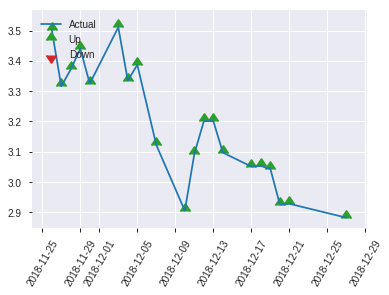


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2503119939204716
RMSE: 0.500311896640957
LogLoss: 0.6938104106128802
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 342.38351957249984
Residual deviance: 342.7423428427628
AIC: 444.7423428427628
AUC: 0.49271653543307087
pr_auc: 0.5116622688770717
Gini: -0.014566929133858264
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35546854037676306: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    127  1        (127.0/127.0)
1      0    120  0        (0.0/120.0)
Total  0    247  0.5142   (127.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355469     0.653951  246
max f2                       0.355469     0.825309  246
max f0point5                 0.355469     0.541516  246
max accuracy                 0.555748     0.54251   8
max precision                0.555748     0.888889  8
max recall                   0.355469     1         246
max specificity              0.634735     0.992126  0
max absolute_mcc             0.555748     0.156822  8
max min_per_class_accuracy   0.496344     0.483333  122
max mean_per_class_accuracy  0.52814      0.531463  26

Gains/Lift Table: Avg response rate: 48.58 %, avg score: 50.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.576214           1.37222   1.37222            0.666667         0.614757  0.666667                    0.614757            0.0166667       0.0166667                  37.2222   37.2222
    2        0.0202429                   0.571392           2.05833   1.64667            1                0.574545  0.8                         0.598672            0.0166667       0.0333333                  105.833   64.6667
    3        0.0323887                   0.556049           2.05833   1.80104            1                0.561257  0.875                       0.584641            0.025           0.0583333                  105.833   80.1042
    4        0.0404858                   0.552224           1.02917   1.64667            0.5              0.55413   0.8                         0.578539            0.00833333      0.0666667                  2.91667   64.6667
    5        0.0526316                   0.550849           0.686111  1.425              0.333333         0.551806  0.692308                    0.57237             0.00833333      0.075                      -31.3889  42.5
    6        0.101215                    0.530253           1.20069   1.31733            0.583333         0.538088  0.64                        0.555915            0.0583333       0.133333                   20.0694   31.7333
    7        0.149798                    0.522134           0.514583  1.05698            0.25             0.524993  0.513514                    0.545886            0.025           0.158333                   -48.5417  5.6982
    8        0.202429                    0.51528            1.26667   1.1115             0.615385         0.518419  0.54                        0.538745            0.0666667       0.225                      26.6667   11.15
    9        0.299595                    0.49951            0.686111  0.973536           0.333333         0.504208  0.472973                    0.527543            0.0666667       0.291667                   -31.3889  -2.6464
    10       0.40081                     0.497281           0.823333  0.935606           0.4              0.498252  0.454545                    0.520147            0.0833333       0.375                      -17.6667  -6.43939
    11       0.502024                    0.496253           1.07033   0.962769           0.52             0.496758  0.467742                    0.515431            0.108333        0.483333                   7.03333   -3.72312
    12       0.59919                     0.495772           1.11493   0.987444           0.541667         0.495941  0.47973                     0.512271            0.108333        0.591667                   11.4931   -1.25563
    13       0.700405                    0.495351           0.905667  0.975626           0.44             0.495558  0.473988                    0.509855            0.0916667       0.683333                   -9.43333  -2.43738
    14       0.797571                    0.494918           1.11493   0.992597           0.541667         0.495189  0.482234                    0.508069            0.108333        0.791667                   11.4931   -0.740271
    15       0.898785                    0.49162            0.905667  0.982808           0.44             0.494044  0.477477                    0.506489            0.0916667       0.883333                   -9.43333  -1.71922
    16       1                           0.355469           1.15267   1                  0.56             0.475728  0.48583                     0.503376        

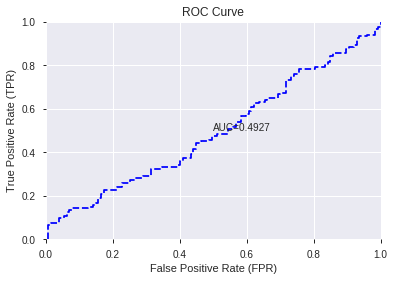

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


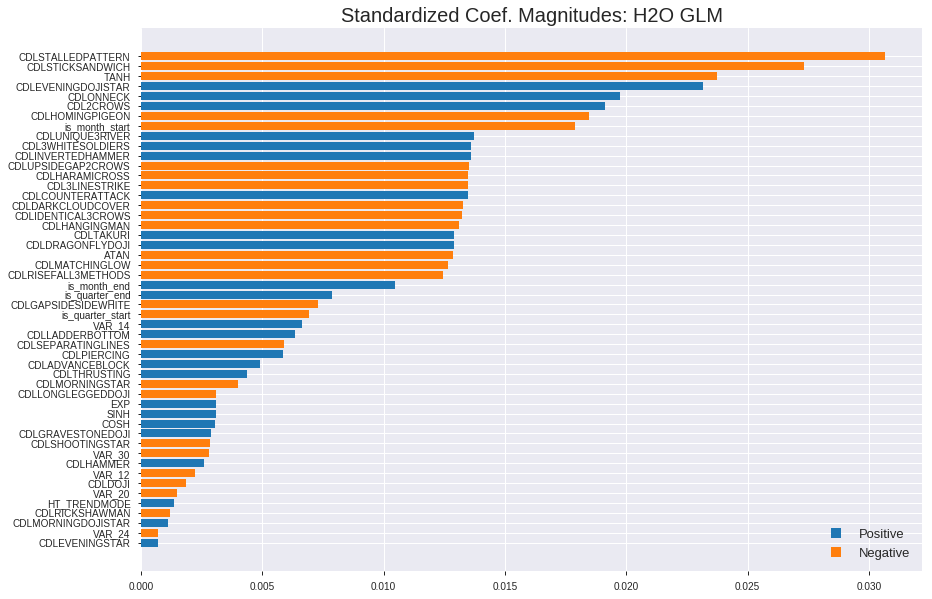

'log_likelihood'
--2019-08-26 13:58:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.10.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.10.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_135828_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_135828_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a2a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CDLSTALLEDPATTERN',
 'CDLSTICKSANDWICH',
 'TANH',
 'CDLEVENINGDOJISTAR',
 'CDLONNECK',
 'CDL2CROWS',
 'CDLHOMINGPIGEON',
 'is_month_start',
 'CDLUNIQUE3RIVER',
 'CDL3WHITESOLDIERS',
 'CDLINVERTEDHAMMER',
 'CDLUPSIDEGAP2CROWS',
 'CDLHARAMICROSS',
 'CDL3LINESTRIKE',
 'CDLCOUNTERATTACK',
 'CDLDARKCLOUDCOVER',
 'CDLIDENTICAL3CROWS',
 'CDLHANGINGMAN',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'ATAN',
 'CDLMATCHINGLOW',
 'CDLRISEFALL3METHODS',
 'is_month_end',
 'is_quarter_end',
 'CDLGAPSIDESIDEWHITE',
 'is_quarter_start',
 'VAR_14',
 'CDLLADDERBOTTOM',
 'CDLSEPARATINGLINES',
 'CDLPIERCING',
 'CDLADVANCEBLOCK',
 'CDLTHRUSTING',
 'CDLMORNINGSTAR',
 'CDLLONGLEGGEDDOJI',
 'EXP',
 'SINH',
 'COSH',
 'CDLGRAVESTONEDOJI',
 'CDLSHOOTINGSTAR',
 'VAR_30',
 'CDLHAMMER',
 'VAR_12',
 'CDLDOJI',
 'VAR_20',
 'HT_TRENDMODE',
 'CDLRICKSHAWMAN',
 'CDLMORNINGDOJISTAR',
 'VAR_24',
 'CDLEVENINGSTAR']

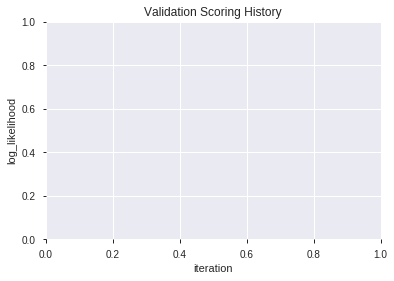

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_135839_model_7  0.541535  0.702243              0.500000  0.503919  0.253934
1               XGBoost_1_AutoML_20190826_135839  0.537303  0.699645              0.469193  0.502996  0.253005
2  XGBoost_grid_1_AutoML_20190826_135839_model_5  0.537008  0.721215              0.496063  0.511747  0.261885
3  XGBoost_grid_1_AutoML_20190826_135839_model_3  0.526115  0.694814              0.469652  0.500720  0.250720
4  XGBoost_grid_1_AutoML_20190826_135839_model_4  0.520112  0.694512              0.488419  0.500687  0.250688
5               XGBoost_2_AutoML_20190826_135839  0.519751  0.701496              0.480774  0.504010  0.254026
6  XGBoost_grid_1_AutoML_20190826_135839_model_1  0.517323  0.697311              0.496063  0.501989  0.251993
7               XGBoost_3_AutoML_20190826_135839  0.504495  0.698358              0.488189  0.502500  0.252506
8  XGBoost_grid_1_AutoML_20190826_135839_model_6  0.497933  0.697425              0.476608  0.502071  0.252075
9  XGBoost_grid_1_AutoML_20190826_135839_model_2  0.491831  0.699842              0.488189  0.503302  0.253313

variable  relative_importance  scaled_importance  percentage
0              VAR_30           800.983154           1.000000    0.161333
1              VAR_14           762.559448           0.952029    0.153594
2              VAR_24           743.428345           0.928145    0.149741
3                ATAN           686.462280           0.857025    0.138267
4              VAR_12           658.683167           0.822343    0.132671
5              VAR_20           644.338135           0.804434    0.129782
6                COSH           245.199860           0.306124    0.049388
7                TANH           218.788177           0.273150    0.044068
8                 EXP            78.461914           0.097957    0.015804
9        HT_TRENDMODE            25.260063           0.031536    0.005088
10   CDLDRAGONFLYDOJI            18.656645           0.023292    0.003758
11     is_month_start            15.110535           0.018865    0.003044
12            CDLDOJI            12.541546           0.015658    0.002526
13               SINH            12.139044           0.015155    0.002445
14      CDLHANGINGMAN            11.095707           0.013853    0.002235
15     CDLRICKSHAWMAN            10.640438           0.013284    0.002143
16  CDLLONGLEGGEDDOJI             7.860325           0.009813    0.001583
17       is_month_end             7.540117           0.009414    0.001519
18     CDLHARAMICROSS             3.022945           0.003774    0.000609
19          CDLHAMMER             1.998620           0.002495    0.000403

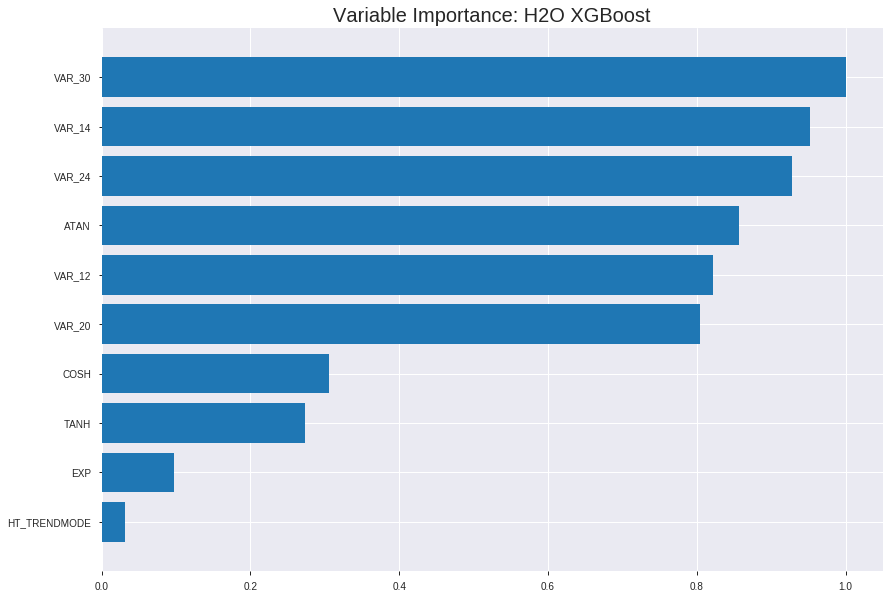

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_135839_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1944354684905187
RMSE: 0.4409483739515531
LogLoss: 0.5786781478857523
Mean Per-Class Error: 0.2113589732867316
AUC: 0.8683424230120178
pr_auc: 0.8641514695458279
Gini: 0.7366848460240356
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4789626631471846: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      630  233  0.27     (233.0/863.0)
1      133  726  0.1548   (133.0/859.0)
Total  763  959  0.2125   (366.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478963     0.79868   213
max f2                       0.398847     0.876321  296
max f0point5                 0.514315     0.796348  177
max accuracy                 0.49976      0.788618  191
max precision                0.76708      1         0
max recall                   0.279342     1         383
max specificity              0.76708      1         0
max absolute_mcc             0.478963     0.578941  213
max min_per_class_accuracy   0.496696     0.78679   194
max mean_per_class_accuracy  0.495076     0.788641  196

Gains/Lift Table: Avg response rate: 49.88 %, avg score: 49.71 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.716561           2.00466    2.00466            1                0.735807  1                           0.735807            0.0209546       0.0209546                  100.466   100.466
    2        0.0203252                   0.700797           2.00466    2.00466            1                0.708213  1                           0.722404            0.0197905       0.0407451                  100.466   100.466
    3        0.0301974                   0.688993           1.88674    1.96611            0.941176         0.693577  0.980769                    0.71298             0.0186263       0.0593714                  88.6736   96.6105
    4        0.0400697                   0.681678           2.00466    1.9756             1                0.68559   0.985507                    0.706232            0.0197905       0.0791618                  100.466   97.5604
    5        0.0505226                   0.67213            2.00466    1.98161            1                0.67707   0.988506                    0.700198            0.0209546       0.100116                   100.466   98.1615
    6        0.100465                    0.636468           1.88811    1.93513            0.94186          0.653493  0.965318                    0.67698             0.0942957       0.194412                   88.8107   93.5131
    7        0.150407                    0.613129           1.8648     1.91178            0.930233         0.623731  0.953668                    0.659299            0.0931315       0.287544                   86.4797   91.1777
    8        0.200348                    0.595256           1.79487    1.88263            0.895349         0.603777  0.93913                     0.645459            0.0896391       0.377183                   79.4867   88.2634
    9        0.300232                    0.561113           1.44522    1.73711            0.72093          0.576932  0.866538                    0.622661            0.144354        0.521537                   44.5218   73.7111
    10       0.400116                    0.528322           1.42191    1.65842            0.709302         0.545008  0.827286                    0.603276            0.142026        0.663562                   42.1908   65.8424
    11       0.5                         0.496532           1.27039    1.58091            0.633721         0.512956  0.788618                    0.585233            0.126892        0.790454                   27.0393   58.0908
    12       0.599884                    0.466292           0.850814   1.45934            0.424419         0.481409  0.727977                    0.567946            0.0849825       0.875437                   -14.9186  45.9343
    13       0.699768                    0.436461           0.606059   1.33755            0.302326         0.452459  0.66722                     0.551461            0.0605355       0.935972                   -39.3941  33.7547
    14       0.799652                    0.402796           0.442889   1.2258             0.22093          0.420085  0.611474                    0.535051            0.0442375       0.98021                    -55.7111  22.5796
    15       0.899535                    0.350908           0.16317    1.1078             0.0813953        0.379023  0.552615                    0.517726            0.016298        0.996508                   -83.683   10.7802
    16       1                           0.192922           0.0347628  1                  0.017341         0.312332  0.498839                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2536015638529832
RMSE: 0.503588685191579
LogLoss: 0.7009731905123413
Mean Per-Class Error: 0.44166444562899787
AUC: 0.5188566098081023
pr_auc: 0.5506848571129263
Gini: 0.03771321961620466
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33742648363113403: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      17   207  0.9241   (207.0/224.0)
1      5    263  0.0187   (5.0/268.0)
Total  22   470  0.4309   (212.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337426     0.712737  377
max f2                       0.264199     0.857326  398
max f0point5                 0.337426     0.612197  377
max accuracy                 0.490152     0.571138  256
max precision                0.707867     0.833333  5
max recall                   0.264199     1         398
max specificity              0.725607     0.995536  0
max absolute_mcc             0.337426     0.137912  377
max min_per_class_accuracy   0.535348     0.508929  202
max mean_per_class_accuracy  0.490152     0.558336  256

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 52.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.708113           1.46866   1.46866            0.8              0.717433  0.8                         0.717433            0.0149254       0.0149254                  46.8657   46.8657
    2        0.0203252                   0.693417           1.10149   1.28507            0.6              0.701655  0.7                         0.709544            0.011194        0.0261194                  10.1493   28.5075
    3        0.0304878                   0.685056           1.10149   1.22388            0.6              0.689667  0.666667                    0.702918            0.011194        0.0373134                  10.1493   22.3881
    4        0.0406504                   0.681522           0.734328  1.10149            0.4              0.683591  0.6                         0.698086            0.00746269      0.0447761                  -26.5672  10.1493
    5        0.050813                    0.675474           0.734328  1.02806            0.4              0.677938  0.56                        0.694057            0.00746269      0.0522388                  -26.5672  2.80597
    6        0.101626                    0.647672           0.881194  0.954627           0.48             0.66353   0.52                        0.678793            0.0447761       0.0970149                  -11.8806  -4.53731
    7        0.150407                    0.626027           0.688433  0.868294           0.375            0.636708  0.472973                    0.665144            0.0335821       0.130597                   -31.1567  -13.1706
    8        0.20122                     0.612253           1.10149   0.927182           0.6              0.618336  0.505051                    0.653324            0.0559701       0.186567                   10.1493   -7.28177
    9        0.300813                    0.588588           1.01157   0.955123           0.55102          0.600078  0.52027                     0.635695            0.100746        0.287313                   1.15748   -4.4877
    10       0.400407                    0.565953           1.04904   0.978483           0.571429         0.577298  0.532995                    0.62117             0.104478        0.391791                   4.90405   -2.15168
    11       0.5                         0.535522           1.16144   1.01493            0.632653         0.549898  0.552846                    0.606974            0.115672        0.507463                   16.1438   1.49254
    12       0.599593                    0.50409            1.27383   1.05793            0.693878         0.518925  0.576271                    0.592349            0.126866        0.634328                   27.3835   5.79307
    13       0.699187                    0.467967           1.12397   1.06734            0.612245         0.48862   0.581395                    0.577573            0.11194         0.746269                   12.3972   6.73377
    14       0.79878                     0.43265            0.674383  1.01834            0.367347         0.450507  0.554707                    0.56173             0.0671642       0.813433                   -32.5617  1.83434
    15       0.898374                    0.385084           0.974109  1.01344            0.530612         0.413082  0.552036                    0.545251            0.0970149       0.910448                   -2.5891   1.34396
    16       1                           0.260464           0.881194  1                  0.48             0.336438  0.544715                    0.52403      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 13:58:58  6.654 sec   0                  0.5              0.693147            0.5             0                  1                0.501161                         0.5                0.693147              0.5               0                    1                  0.455285
    2019-08-26 13:58:58  6.726 sec   5                  0.491966         0.677177            0.709586        0.686018           1.37161          0.41115                          0.498253           0.689652              0.537363          0.579733             1.10149            0.453252
    2019-08-26 13:58:58  6.793 sec   10                 0.484277         0.662057            0.756815        0.735104           1.55918          0.318235                         0.498681           0.690515              0.531117          0.560355             1.10149            0.455285
    2019-08-26 13:58:58  6.857 sec   15                 0.477759         0.649307            0.776849        0.760773           1.55918          0.319977                         0.498345           0.689851              0.533424          0.560564             1.10149            0.441057
    2019-08-26 13:58:58  6.928 sec   20                 0.471563         0.637282            0.800075        0.782477           1.67055          0.287456                         0.49864            0.69045               0.533349          0.56375              1.46866            0.447154
    2019-08-26 13:58:58  7.009 sec   25                 0.466391         0.627276            0.812477        0.796803           1.78192          0.277003                         0.498764           0.690716              0.534507          0.564989             1.22388            0.445122
    2019-08-26 13:58:58  7.082 sec   30                 0.461177         0.617218            0.824441        0.81193            1.78192          0.283391                         0.499785           0.692942              0.532766          0.555492             0.91791            0.45122
    2019-08-26 13:58:58  7.191 sec   35                 0.455542         0.606354            0.835035        0.823034           1.89329          0.251452                         0.500816           0.695059              0.528218          0.556043             1.10149            0.439024
    2019-08-26 13:58:58  7.279 sec   40                 0.449827         0.595463            0.849102        0.841449           2.00466          0.231707                         0.50182            0.697187              0.522296          0.551811             0.734328           0.434959
    2019-08-26 13:58:58  7.356 sec   45                 0.444832         0.586026            0.859079        0.853825           2.00466          0.224739                         0.502285           0.698241              0.522113          0.554849             1.10149            0.434959
    2019-08-26 13:58:58  7.423 sec   50                 0.440948         0.578678            0.868342        0.864151           2.00466          0.212544                         0.503589           0.700973              0.518857          0.550685             1.46866            0.430894

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
VAR_30             800.983                1                    0.161333
VAR_14             762.559                0.952029             0.153594
VAR_24             743.428                0.928145             0.149741
ATAN               686.462                0.857025             0.138267
VAR_12             658.683                0.822343             0.132671
VAR_20             644.338                0.804434             0.129782
COSH               245.2                  0.306124             0.049388
TANH               218.788                0.27315              0.0440681
EXP                78.4619                0.097957             0.0158037
HT_TRENDMODE       25.2601                0.0315363            0.00508786
CDLDRAGONFLYDOJI   18.6566                0.0232922            0.00375781
is_month_start     15.1105                0.018865             0.00304355
CDLDOJI            12.5415                0.0156577            0.00252611
SINH               12.139                 0.0151552            0.00244504
CDLHANGINGMAN      11.0957                0.0138526            0.00223489
CDLRICKSHAWMAN     10.6404                0.0132842            0.00214319
CDLLONGLEGGEDDOJI  7.86032                0.00981335           0.00158322
is_month_end       7.54012                0.00941358           0.00151872
CDLHARAMICROSS     3.02294                0.00377404           0.000608879
CDLHAMMER          1.99862                0.00249521           0.00040256

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5748987854251012)

('F1', 0.6539509536784741)

('auc', 0.5415354330708662)

('logloss', 0.7022426761988644)

('mean_per_class_error', 0.42831364829396323)

('rmse', 0.5039191354472539)

('mse', 0.25393449506990784)

xgboost prediction progress: |████████████████████████████████████████████| 100%


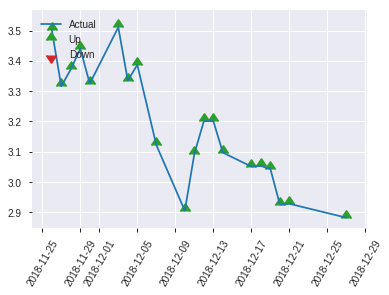


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25393449506990784
RMSE: 0.5039191354472539
LogLoss: 0.7022426761988644
Mean Per-Class Error: 0.42831364829396323
AUC: 0.5415354330708662
pr_auc: 0.5129415368128023
Gini: 0.08307086614173231
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2329598367214203: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    127  1        (127.0/127.0)
1      0    120  0        (0.0/120.0)
Total  0    247  0.5142   (127.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.23296      0.653951  244
max f2                       0.23296      0.825309  244
max f0point5                 0.508642     0.55      93
max accuracy                 0.517168     0.574899  83
max precision                0.715535     1         0
max recall                   0.23296      1         244
max specificity              0.715535     1         0
max absolute_mcc             0.517168     0.148415  83
max min_per_class_accuracy   0.479142     0.55      120
max mean_per_class_accuracy  0.508642     0.571686  93

Gains/Lift Table: Avg response rate: 48.58 %, avg score: 48.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.703328           1.37222   1.37222            0.666667         0.709834  0.666667                    0.709834            0.0166667       0.0166667                  37.2222   37.2222
    2        0.0202429                   0.697186           0         0.823333           0                0.700313  0.4                         0.706025            0               0.0166667                  -100      -17.6667
    3        0.0323887                   0.689023           1.37222   1.02917            0.666667         0.693762  0.5                         0.701426            0.0166667       0.0333333                  37.2222   2.91667
    4        0.0404858                   0.674907           1.02917   1.02917            0.5              0.687108  0.5                         0.698563            0.00833333      0.0416667                  2.91667   2.91667
    5        0.0526316                   0.668198           0.686111  0.95               0.333333         0.670438  0.461538                    0.692072            0.00833333      0.05                       -31.3889  -5
    6        0.101215                    0.621554           1.02917   0.988              0.5              0.638857  0.48                        0.666529            0.05            0.1                        2.91667   -1.2
    7        0.149798                    0.594883           1.20069   1.05698            0.583333         0.608104  0.513514                    0.64758             0.0583333       0.158333                   20.0694   5.6982
    8        0.202429                    0.577046           1.26667   1.1115             0.615385         0.584379  0.54                        0.631148            0.0666667       0.225                      26.6667   11.15
    9        0.299595                    0.530644           1.37222   1.19606            0.666667         0.553371  0.581081                    0.605923            0.133333        0.358333                   37.2222   19.6059
    10       0.40081                     0.504751           0.988     1.14352            0.48             0.516685  0.555556                    0.583388            0.1             0.458333                   -1.2      14.3519
    11       0.502024                    0.477702           0.905667  1.09556            0.44             0.48857   0.532258                    0.564272            0.0916667       0.55                       -9.43333  9.55645
    12       0.59919                     0.460212           0.771875  1.04307            0.375            0.467977  0.506757                    0.548656            0.075           0.625                      -22.8125  4.30743
    13       0.700405                    0.42176            0.741     0.999422           0.36             0.439929  0.485549                    0.532944            0.075           0.7                        -25.9     -0.0578035
    14       0.797571                    0.391648           1.02917   1.00305            0.5              0.40672   0.48731                     0.517567            0.1             0.8                        2.91667   0.304569
    15       0.898785                    0.356053           0.988     1.00135            0.48             0.376079  0.486486                    0.501633            0.1             0.9                        -1.2      0.135135
    16       1                           0.23296            0.988     1                  0.48             0.308446  0.48583                     0.48208             0.

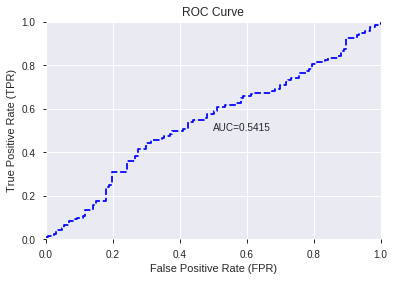

This function is available for GLM models only


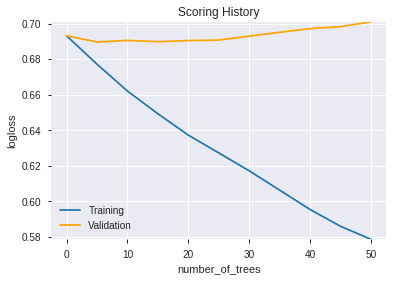

--2019-08-26 13:59:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_135839_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_135839_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a2a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['VAR_30',
 'VAR_14',
 'VAR_24',
 'ATAN',
 'VAR_12',
 'VAR_20',
 'COSH',
 'TANH',
 'EXP',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'is_month_start',
 'CDLDOJI',
 'SINH',
 'CDLHANGINGMAN',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'is_month_end',
 'CDLHARAMICROSS',
 'CDLHAMMER']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_135909_model_1  0.51647  0.697846                   0.5  0.502129  0.252134

variable  relative_importance  scaled_importance    percentage
0           CDLSTALLEDPATTERN         8.358255e-03           1.000000  1.176736e-02
1            CDLSTICKSANDWICH         7.924605e-03           0.948117  1.115683e-02
2              CDLSPINNINGTOP         7.483958e-03           0.895397  1.053646e-02
3                      Volume         6.785528e-03           0.811836  9.553159e-03
4              STOCHRSI_fastk         6.658089e-03           0.796588  9.373740e-03
...                       ...                  ...                ...           ...
1039                  MA_24_2         1.140168e-06           0.000136  1.605211e-06
1040                  MA_12_1         1.035002e-06           0.000124  1.457151e-06
1041   LINEARREG_INTERCEPT_20         8.132687e-07           0.000097  1.144979e-06
1042  BBANDS_lowerband_12_1_4         5.540880e-07           0.000066  7.800854e-07
1043  BBANDS_upperband_20_1_3         2.893914e-07           0.000035  4.074262e-07

[1044 rows x 4 columns]

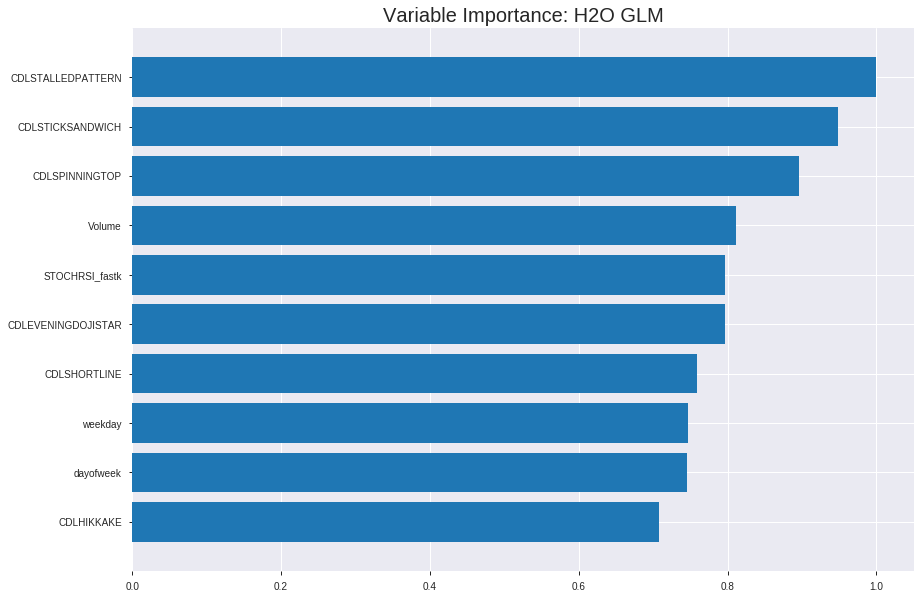

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_135909_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24667311590918756
RMSE: 0.496661973488194
LogLoss: 0.6864801058156601
Null degrees of freedom: 1721
Residual degrees of freedom: 677
Null deviance: 2387.1895983186078
Residual deviance: 2364.2374844291335
AIC: 4454.2374844291335
AUC: 0.5968721882811268
pr_auc: 0.5911615729288403
Gini: 0.19374437656225352
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4558312972283473: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      36   827   0.9583   (827.0/863.0)
1      13   846   0.0151   (13.0/859.0)
Total  49   1673  0.4878   (840.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.455831     0.668246  373
max f2                       0.439742     0.833172  396
max f0point5                 0.486258     0.576426  261
max accuracy                 0.502463     0.57259   182
max precision                0.574422     1         0
max recall                   0.439742     1         396
max specificity              0.574422     1         0
max absolute_mcc             0.514092     0.148071  124
max min_per_class_accuracy   0.499563     0.570104  197
max mean_per_class_accuracy  0.498987     0.572615  200

Gains/Lift Table: Avg response rate: 49.88 %, avg score: 49.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.551082           1.55918   1.55918            0.777778         0.559375  0.777778                    0.559375            0.016298        0.016298                   55.9177   55.9177
    2        0.0203252                   0.545182           1.53297   1.54645            0.764706         0.547726  0.771429                    0.553717            0.0151339       0.0314319                  53.2973   54.6449
    3        0.0301974                   0.539292           1.29713   1.46494            0.647059         0.542661  0.730769                    0.550103            0.0128056       0.0442375                  29.7131   46.4941
    4        0.0400697                   0.535285           1.29713   1.4236             0.647059         0.536644  0.710145                    0.546787            0.0128056       0.0570431                  29.7131   42.3597
    5        0.0505226                   0.533153           1.44781   1.42861            0.722222         0.53437   0.712644                    0.544218            0.0151339       0.0721769                  44.7808   42.8606
    6        0.100465                    0.525368           1.18881   1.3094             0.593023         0.529144  0.653179                    0.536724            0.0593714       0.131548                   18.8808   30.94
    7        0.150407                    0.521005           1.23543   1.28484            0.616279         0.523107  0.640927                    0.532203            0.0616997       0.193248                   23.5428   28.4838
    8        0.200348                    0.517108           1.23543   1.27252            0.616279         0.51907   0.634783                    0.528929            0.0616997       0.254948                   23.5428   27.2521
    9        0.300232                    0.510402           1.09557   1.21365            0.546512         0.513491  0.605416                    0.523793            0.10943         0.364377                   9.55681   21.3651
    10       0.400116                    0.504999           1.00233   1.1609             0.5              0.507843  0.5791                      0.519811            0.100116        0.464494                   0.232829  16.0897
    11       0.5                         0.499441           1.0606    1.14086            0.52907          0.502298  0.569106                    0.516313            0.105937        0.570431                   6.06032   14.0861
    12       0.599884                    0.493578           0.862469  1.09451            0.430233         0.496636  0.545983                    0.513037            0.0861467       0.656577                   -13.7531  9.45076
    13       0.699768                    0.487225           1.00233   1.08135            0.5              0.49057   0.539419                    0.50983             0.100116        0.756694                   0.232829  8.135
    14       0.799652                    0.480189           0.920743  1.06129            0.459302         0.483724  0.529412                    0.506569            0.0919674       0.848661                   -7.92566  6.12888
    15       0.899535                    0.471207           0.804194  1.03274            0.401163         0.4762    0.515171                    0.503197            0.080326        0.928987                   -19.5806  3.27411
    16       1                           0.420508           0.706844  1                  0.352601         0.459816  0.498839                    0.498839            0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2494445483031747
RMSE: 0.4994442394333673
LogLoss: 0.6920454817123933
Null degrees of freedom: 491
Residual degrees of freedom: -553
Null deviance: 682.2638942389361
Residual deviance: 680.9727540049951
AIC: 2770.9727540049953
AUC: 0.4968933235607676
pr_auc: 0.5378905282405769
Gini: -0.006213352878464806
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4611264783869037: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    222  0.9911   (222.0/224.0)
1      0    268  0        (0.0/268.0)
Total  2    490  0.4512   (222.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.461126     0.707124  397
max f2                       0.461126     0.857875  397
max f0point5                 0.4811       0.60305   382
max accuracy                 0.4811       0.552846  382
max precision                0.556682     0.625     15
max recall                   0.461126     1         397
max specificity              0.599289     0.995536  0
max absolute_mcc             0.589255     0.110832  4
max min_per_class_accuracy   0.514166     0.492537  197
max mean_per_class_accuracy  0.532042     0.514759  68

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 51.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.587574           0         0                  0                0.593061  0                           0.593061            0               0                          -100      -100
    2        0.0203252                   0.58079            1.46866   0.734328           0.8              0.584781  0.4                         0.588921            0.0149254       0.0149254                  46.8657   -26.5672
    3        0.0304878                   0.557788           1.83582   1.10149            1                0.571579  0.6                         0.58314             0.0186567       0.0335821                  83.5821   10.1493
    4        0.0406504                   0.552693           0.367164  0.91791            0.2              0.5555    0.5                         0.57623             0.00373134      0.0373134                  -63.2836  -8.20896
    5        0.050813                    0.549926           1.10149   0.954627           0.6              0.551091  0.52                        0.571202            0.011194        0.0485075                  10.1493   -4.53731
    6        0.101626                    0.537543           1.02806   0.991343           0.56             0.543199  0.54                        0.557201            0.0522388       0.100746                   2.80597   -0.865672
    7        0.150407                    0.532092           1.22388   1.06676            0.666667         0.534782  0.581081                    0.54993             0.0597015       0.160448                   22.3881   6.67608
    8        0.20122                     0.529295           1.02806   1.05699            0.56             0.530838  0.575758                    0.545109            0.0522388       0.212687                   2.80597   5.69878
    9        0.300813                    0.523353           0.824246  0.979931           0.44898          0.526422  0.533784                    0.538922            0.0820896       0.294776                   -17.5754  -2.00686
    10       0.400407                    0.518934           0.974109  0.978483           0.530612         0.52121   0.532995                    0.534516            0.0970149       0.391791                   -2.5891   -2.15168
    11       0.5                         0.514004           1.04904   0.992537           0.571429         0.51638   0.54065                     0.530904            0.104478        0.496269                   4.90405   -0.746269
    12       0.599593                    0.509267           0.861712  0.970807           0.469388         0.511758  0.528814                    0.527724            0.0858209       0.58209                    -13.8288  -2.9193
    13       0.699187                    0.504785           1.23637   1.00863            0.673469         0.506888  0.549419                    0.524756            0.123134        0.705224                   23.6369   0.863415
    14       0.79878                     0.499452           0.974109  1.00433            0.530612         0.502037  0.547074                    0.521923            0.0970149       0.802239                   -2.5891   0.43295
    15       0.898374                    0.490466           1.01157   1.00513            0.55102          0.495259  0.547511                    0.518967            0.100746        0.902985                   1.15748   0.513271
    16       1                           0.456282           0.954627  1                  0.52             0.480501  0.544715                    0.515058 


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 13:59:13  0.000 sec   2            2.8       1045          1.37296           1.38409
    2019-08-26 13:59:15  2.042 sec   4            2.1       1045          1.36954           1.3845
    2019-08-26 13:59:17  4.072 sec   6            1.5       1045          1.3656            1.3854
    2019-08-26 13:59:19  6.122 sec   8            1.1       1045          1.36107           1.38667
    2019-08-26 13:59:21  8.185 sec   10           0.8       1045          1.356             1.3885
    2019-08-26 13:59:23  10.204 sec  12           0.58      1045          1.35052           1.39123

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5546558704453441)

('F1', 0.6539509536784741)

('auc', 0.5164698162729658)

('logloss', 0.6978461038896197)

('mean_per_class_error', 0.4496062992125984)

('rmse', 0.5021291884928984)

('mse', 0.25213372193653677)

glm prediction progress: |████████████████████████████████████████████████| 100%


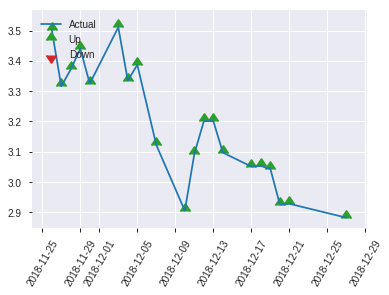


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25213372193653677
RMSE: 0.5021291884928984
LogLoss: 0.6978461038896197
Null degrees of freedom: 246
Residual degrees of freedom: -798
Null deviance: 342.38351957249984
Residual deviance: 344.735975321472
AIC: 2434.735975321472
AUC: 0.5164698162729658
pr_auc: 0.4936920983424177
Gini: 0.032939632545931685
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4575802449302674: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    127  1        (127.0/127.0)
1      0    120  0        (0.0/120.0)
Total  0    247  0.5142   (127.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45758      0.653951  246
max f2                       0.45758      0.825309  246
max f0point5                 0.45758      0.541516  246
max accuracy                 0.518412     0.554656  51
max precision                0.518412     0.596154  51
max recall                   0.45758      1         246
max specificity              0.740646     0.992126  0
max absolute_mcc             0.518412     0.113988  51
max min_per_class_accuracy   0.500583     0.516667  122
max mean_per_class_accuracy  0.508107     0.550394  85

Gains/Lift Table: Avg response rate: 48.58 %, avg score: 50.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.566657           0.686111  0.686111           0.333333         0.680508  0.333333                    0.680508            0.00833333      0.00833333                 -31.3889  -31.3889
    2        0.0202429                   0.55208            0         0.411667           0                0.555589  0.2                         0.63054             0               0.00833333                 -100      -58.8333
    3        0.0323887                   0.543384           1.37222   0.771875           0.666667         0.54693   0.375                       0.599186            0.0166667       0.025                      37.2222   -22.8125
    4        0.0404858                   0.542419           0         0.6175             0                0.542908  0.3                         0.587931            0               0.025                      -100      -38.25
    5        0.0526316                   0.538979           1.37222   0.791667           0.666667         0.541267  0.384615                    0.577162            0.0166667       0.0416667                  37.2222   -20.8333
    6        0.101215                    0.527157           1.20069   0.988              0.583333         0.533275  0.48                        0.556096            0.0583333       0.1                        20.0694   -1.2
    7        0.149798                    0.522143           1.54375   1.16824            0.75             0.524816  0.567568                    0.545951            0.075           0.175                      54.375    16.8243
    8        0.202429                    0.518582           1.26667   1.19383            0.615385         0.519972  0.58                        0.539197            0.0666667       0.241667                   26.6667   19.3833
    9        0.299595                    0.511773           0.857639  1.0848             0.416667         0.515031  0.527027                    0.531359            0.0833333       0.325                      -14.2361  8.47973
    10       0.40081                     0.505824           1.15267   1.10194            0.56             0.508348  0.535354                    0.525548            0.116667        0.441667                   15.2667   10.1936
    11       0.502024                    0.500531           0.741     1.02917            0.36             0.503196  0.5                         0.521042            0.075           0.516667                   -25.9     2.91667
    12       0.59919                     0.494817           0.943403  1.01526            0.458333         0.497482  0.493243                    0.517221            0.0916667       0.608333                   -5.65972  1.5259
    13       0.700405                    0.490565           1.07033   1.02322            0.52             0.492677  0.49711                     0.513674            0.108333        0.716667                   7.03333   2.32177
    14       0.797571                    0.48479            0.600347  0.971701           0.291667         0.48761   0.472081                    0.510499            0.0583333       0.775                      -39.9653  -2.82995
    15       0.898785                    0.476092           0.988     0.973536           0.48             0.480891  0.472973                    0.507165            0.1             0.875                      -1.2      -2.6464
    16       1                           0.45758            1.235     1                  0.6              0.46951   0.48583                     0.503354         

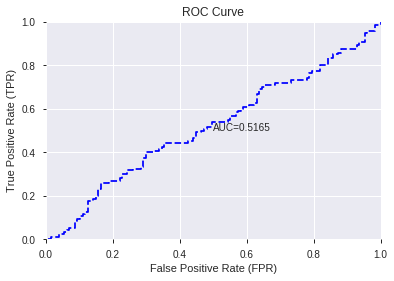

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


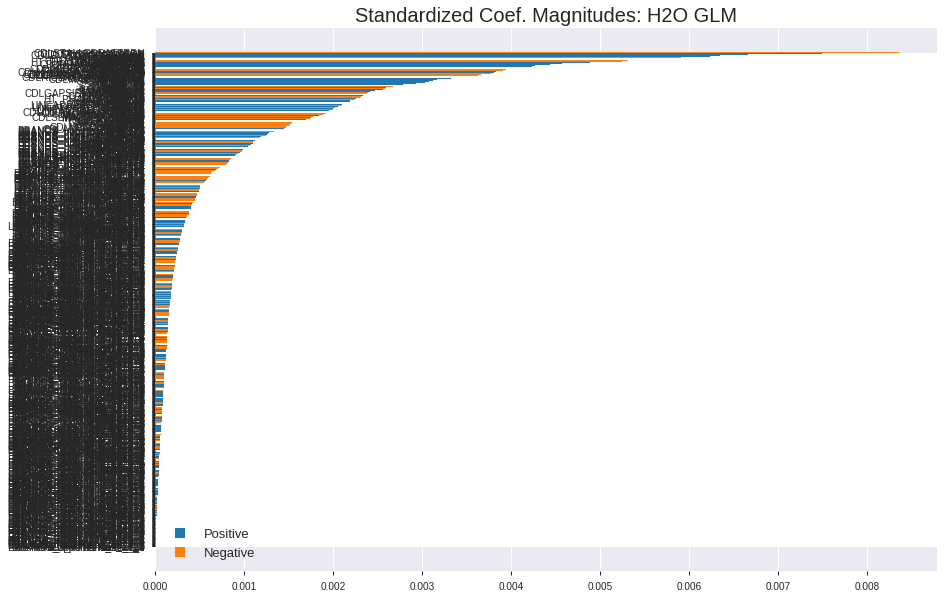

'log_likelihood'
--2019-08-26 13:59:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.130.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.130.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_135909_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_135909_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a2a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

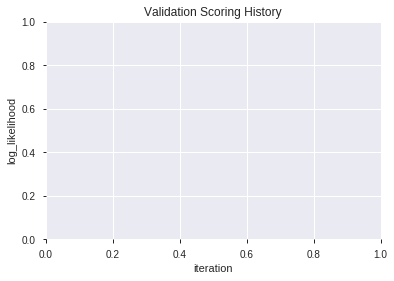

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190826_135957  0.557087  0.692104              0.488189  0.499405  0.249405
1  XGBoost_grid_1_AutoML_20190826_135957_model_3  0.541601  0.697817              0.496063  0.501951  0.251955
2               XGBoost_3_AutoML_20190826_135957  0.540551  0.693299              0.492126  0.499897  0.249897
3  XGBoost_grid_1_AutoML_20190826_135957_model_2  0.532283  0.695392              0.484252  0.501070  0.251071
4               XGBoost_1_AutoML_20190826_135957  0.527100  0.708026              0.496063  0.506737  0.256783
5  XGBoost_grid_1_AutoML_20190826_135957_model_4  0.525000  0.697216              0.492126  0.501955  0.251959
6  XGBoost_grid_1_AutoML_20190826_135957_model_6  0.514436  0.704018              0.492126  0.505014  0.255039
7  XGBoost_grid_1_AutoML_20190826_135957_model_7  0.490354  0.715328              0.496063  0.510302  0.260408
8  XGBoost_grid_1_AutoML_20190826_135957_model_1  0.489993  0.708141              0.496063  0.506789  0.256835
9  XGBoost_grid_1_AutoML_20190826_135957_model_5  0.474081  0.756395              0.500000  0.527451  0.278205

variable  relative_importance  scaled_importance  percentage
0              DX_8           114.508034           1.000000    0.018279
1            Volume            96.199959           0.840115    0.015357
2           BETA_30            91.806877           0.801751    0.014655
3           BETA_14            89.171150           0.778733    0.014235
4    STOCHRSI_fastk            80.407341           0.702198    0.012836
..              ...                  ...                ...         ...
281          ROCR_8             2.947226           0.025738    0.000470
282      aroonup_14             2.926659           0.025559    0.000467
283             day             2.491962           0.021762    0.000398
284         NATR_14             2.175432           0.018998    0.000347
285         MACDEXT             2.101714           0.018354    0.000336

[286 rows x 4 columns]

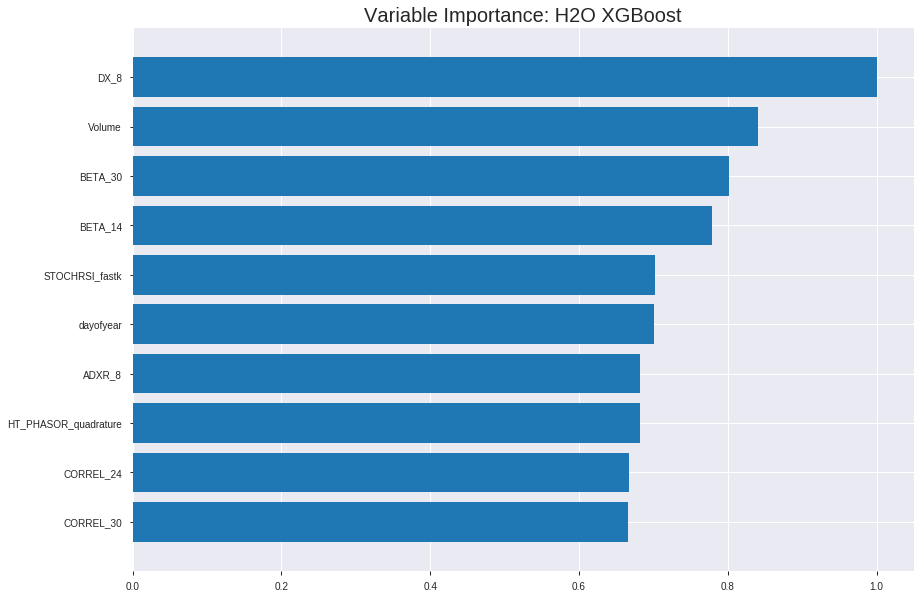

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190826_135957


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17063045704832722
RMSE: 0.41307439650543243
LogLoss: 0.5287524116990812
Mean Per-Class Error: 0.13471429901108434
AUC: 0.9379078046233933
pr_auc: 0.9354613667407886
Gini: 0.8758156092467866
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4878673851490021: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      718  145  0.168    (145.0/863.0)
1      90   769  0.1048   (90.0/859.0)
Total  808  914  0.1365   (235.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.487867     0.867456  214
max f2                       0.424202     0.910178  265
max f0point5                 0.548222     0.879723  163
max accuracy                 0.508517     0.865273  196
max precision                0.799161     1         0
max recall                   0.337216     1         339
max specificity              0.799161     1         0
max absolute_mcc             0.508517     0.730967  196
max min_per_class_accuracy   0.501543     0.864426  202
max mean_per_class_accuracy  0.499151     0.865286  204

Gains/Lift Table: Avg response rate: 49.88 %, avg score: 49.96 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.751027           2.00466    2.00466            1                0.768143  1                           0.768143            0.0209546       0.0209546                  100.466   100.466
    2        0.0203252                   0.734318           2.00466    2.00466            1                0.742933  1                           0.755898            0.0197905       0.0407451                  100.466   100.466
    3        0.0301974                   0.724173           2.00466    2.00466            1                0.729607  1                           0.747303            0.0197905       0.0605355                  100.466   100.466
    4        0.0400697                   0.715344           1.88674    1.9756             0.941176         0.720042  0.985507                    0.740587            0.0186263       0.0791618                  88.6736   97.5604
    5        0.0505226                   0.710557           2.00466    1.98161            1                0.71303   0.988506                    0.734885            0.0209546       0.100116                   100.466   98.1615
    6        0.100465                    0.672601           2.00466    1.99307            1                0.689344  0.99422                     0.712246            0.100116        0.200233                   100.466   99.3069
    7        0.150407                    0.648131           1.95804    1.98144            0.976744         0.659818  0.988417                    0.694838            0.0977881       0.298021                   95.8037   98.1437
    8        0.200348                    0.622639           1.95804    1.9756             0.976744         0.635506  0.985507                    0.680048            0.0977881       0.395809                   95.8037   97.5604
    9        0.300232                    0.582243           1.79487    1.91547            0.895349         0.601078  0.955513                    0.653776            0.179278        0.575087                   79.4867   91.5475
    10       0.400116                    0.537174           1.6317     1.84463            0.813953         0.560233  0.920174                    0.630424            0.16298         0.738068                   63.1697   84.4633
    11       0.5                         0.501095           1.28205    1.73225            0.639535         0.51973   0.864111                    0.608311            0.128056        0.866123                   28.2048   73.2247
    12       0.599884                    0.453837           0.699299   1.56026            0.348837         0.478154  0.778316                    0.586639            0.0698487       0.935972                   -30.0701  56.0255
    13       0.699768                    0.414249           0.419579   1.39744            0.209302         0.433771  0.697095                    0.564819            0.0419092       0.977881                   -58.0421  39.7437
    14       0.799652                    0.374765           0.18648    1.24618            0.0930233        0.395479  0.621641                    0.543667            0.0186263       0.996508                   -81.352   24.6177
    15       0.899535                    0.329608           0.0349649  1.11168            0.0174419        0.351047  0.554551                    0.522278            0.00349243      1                          -96.5035  11.1685
    16       1                           0.218005           0          1                  0                0.296796  0.498839                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2567244357324683
RMSE: 0.506679815793434
LogLoss: 0.707501748604884
Mean Per-Class Error: 0.4861740405117271
AUC: 0.5000333155650319
pr_auc: 0.5503830194660212
Gini: 6.663113006388777e-05
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.194219708442688: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    268  0        (0.0/268.0)
Total  0    492  0.4553   (224.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.19422      0.705263   399
max f2                       0.19422      0.856777   399
max f0point5                 0.314648     0.60219    388
max accuracy                 0.314648     0.550813   388
max precision                0.691582     0.888889   6
max recall                   0.19422      1          399
max specificity              0.729708     0.995536   0
max absolute_mcc             0.691582     0.0943406  6
max min_per_class_accuracy   0.530487     0.511194   196
max mean_per_class_accuracy  0.688034     0.513826   10

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 52.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101626                   0.698427           1.46866   1.46866            0.8              0.710957  0.8                         0.710957            0.0149254       0.0149254                  46.8657    46.8657
    2        0.0203252                   0.689797           1.46866   1.46866            0.8              0.694057  0.8                         0.702507            0.0149254       0.0298507                  46.8657    46.8657
    3        0.0304878                   0.686096           1.10149   1.34627            0.6              0.68835   0.733333                    0.697788            0.011194        0.0410448                  10.1493    34.6269
    4        0.0406504                   0.677967           1.10149   1.28507            0.6              0.682714  0.7                         0.694019            0.011194        0.0522388                  10.1493    28.5075
    5        0.050813                    0.670896           0.367164  1.10149            0.2              0.674762  0.6                         0.690168            0.00373134      0.0559701                  -63.2836   10.1493
    6        0.101626                    0.649605           0.807761  0.954627           0.44             0.656902  0.52                        0.673535            0.0410448       0.0970149                  -19.2239   -4.53731
    7        0.150407                    0.628818           0.91791   0.942719           0.5              0.638502  0.513514                    0.662173            0.0447761       0.141791                   -8.20896   -5.72812
    8        0.20122                     0.606985           0.954627  0.945726           0.52             0.617583  0.515152                    0.650913            0.0485075       0.190299                   -4.53731   -5.42741
    9        0.300813                    0.58173            1.08651   0.992336           0.591837         0.595068  0.540541                    0.632424            0.108209        0.298507                   8.65062    -0.766438
    10       0.400407                    0.556528           1.04904   1.00644            0.571429         0.568381  0.548223                    0.616494            0.104478        0.402985                   4.90405    0.643988
    11       0.5                         0.530168           1.08651   1.02239            0.591837         0.542891  0.556911                    0.601834            0.108209        0.511194                   8.65062    2.23881
    12       0.599593                    0.508518           0.861712  0.995699           0.469388         0.518573  0.542373                    0.588004            0.0858209       0.597015                   -13.8288   -0.430053
    13       0.699187                    0.484424           1.08651   1.00863            0.591837         0.49662   0.549419                    0.574987            0.108209        0.705224                   8.65062    0.863415
    14       0.79878                     0.447213           1.04904   1.01367            0.571429         0.467943  0.552163                    0.56164             0.104478        0.809701                   4.90405    1.36721
    15       0.898374                    0.408029           0.899178  1.00098            0.489796         0.428779  0.545249                    0.546911            0.0895522       0.899254                   -10.0822   0.0979267
    16       1                           0.19422            0.991343  1                  0.54             0.344988  0.544715         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:00:01  0.005 sec   0                  0.5              0.693147            0.5             0                  1                0.501161                         0.5                0.693147              0.5               0                    1                  0.455285
    2019-08-26 14:00:02  0.873 sec   5                  0.488756         0.670865            0.761539        0.754842           1.89915          0.313589                         0.499672           0.69249               0.50234           0.54804              0.734328           0.455285
    2019-08-26 14:00:02  1.439 sec   10                 0.477884         0.649668            0.821619        0.814868           1.89329          0.25842                          0.500777           0.694733              0.500192          0.533727             1.10149            0.455285
    2019-08-26 14:00:03  2.152 sec   15                 0.468009         0.630658            0.847331        0.846669           2.00466          0.235192                         0.501358           0.695926              0.503456          0.539044             1.10149            0.453252
    2019-08-26 14:00:04  2.696 sec   20                 0.459386         0.614238            0.871022        0.864982           2.00466          0.212544                         0.501659           0.696611              0.511336          0.542573             1.10149            0.455285
    2019-08-26 14:00:04  3.326 sec   25                 0.450887         0.598183            0.884472        0.883097           2.00466          0.208479                         0.50209            0.697492              0.504739          0.550319             1.83582            0.441057
    2019-08-26 14:00:05  3.893 sec   30                 0.441912         0.581389            0.898077        0.897211           2.00466          0.186411                         0.502672           0.698763              0.505455          0.553759             1.46866            0.455285
    2019-08-26 14:00:05  4.470 sec   35                 0.433942         0.566673            0.911334        0.910392           2.00466          0.180023                         0.50376            0.701239              0.507638          0.542044             1.10149            0.455285
    2019-08-26 14:00:06  5.058 sec   40                 0.426363         0.552781            0.921728        0.920214           2.00466          0.167247                         0.504563           0.702927              0.506963          0.549648             1.10149            0.455285
    2019-08-26 14:00:07  5.674 sec   45                 0.419911         0.541145            0.931483        0.927698           1.89329          0.146922                         0.505305           0.704405              0.502857          0.556677             1.46866            0.453252
    2019-08-26 14:00:07  6.285 sec   50                 0.413074         0.528752            0.937908        0.935461           2.00466          0.136469                         0.50668            0.707502              0.500033          0.550383             1.46866            0.455285

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ----------------------
DX_8            114.5080337524414      1.0                  0.01827934274961598
Volume          96.19995880126953      0.8401153670077621   0.015356756742754305
BETA_30         91.80687713623047      0.8017505333705293   0.014655472799167329
BETA_14         89.17115020751953      0.7787326992296585   0.014234721919552539
STOCHRSI_fastk  80.40734100341797      0.7021982507991813   0.012835722504539038
---             ---                    ---                  ---
ROCR_8          2.9472262859344482     0.02573816167611568  0.00047047667902274905
aroonup_14      2.9266586303710938     0.02555854409917064  0.0004671933877699151
day             2.491962432861328      0.02176233711469347  0.0003978012191521708
NATR_14         2.1754322052001953     0.01899807492898998  0.0003472723232098941
MACDEXT         2.1017141342163086     0.01835429415162321  0.0003355044337247927


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5546558704453441)

('F1', 0.6593406593406593)

('auc', 0.5570866141732284)

('logloss', 0.6921043081702875)

('mean_per_class_error', 0.4374343832020997)

('rmse', 0.4994048641762697)

('mse', 0.24940521836291843)

xgboost prediction progress: |████████████████████████████████████████████| 100%


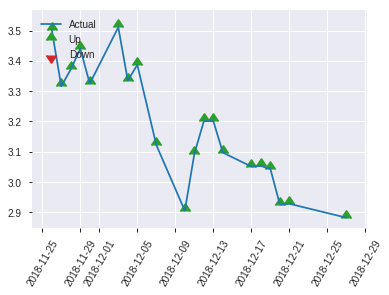


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24940521836291843
RMSE: 0.4994048641762697
LogLoss: 0.6921043081702875
Mean Per-Class Error: 0.4374343832020997
AUC: 0.5570866141732284
pr_auc: 0.5188707274170666
Gini: 0.11417322834645671
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2869548201560974: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    124  0.9764   (124.0/127.0)
1      0    120  0        (0.0/120.0)
Total  3    244  0.502    (124.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.286955     0.659341  243
max f2                       0.286955     0.828729  243
max f0point5                 0.398845     0.568694  191
max accuracy                 0.548308     0.554656  59
max precision                0.619517     0.625     15
max recall                   0.286955     1         243
max specificity              0.716189     0.992126  0
max absolute_mcc             0.398845     0.150323  191
max min_per_class_accuracy   0.477302     0.541667  122
max mean_per_class_accuracy  0.398845     0.562566  191

Gains/Lift Table: Avg response rate: 48.58 %, avg score: 47.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.676605           0         0                  0                0.69573   0                           0.69573             0               0                          -100      -100
    2        0.0202429                   0.66279            2.05833   0.823333           1                0.672236  0.4                         0.686332            0.0166667       0.0166667                  105.833   -17.6667
    3        0.0323887                   0.65451            1.37222   1.02917            0.666667         0.657714  0.5                         0.6756              0.0166667       0.0333333                  37.2222   2.91667
    4        0.0404858                   0.644609           1.02917   1.02917            0.5              0.652101  0.5                         0.6709              0.00833333      0.0416667                  2.91667   2.91667
    5        0.0526316                   0.623217           1.37222   1.10833            0.666667         0.635267  0.538462                    0.662677            0.0166667       0.0583333                  37.2222   10.8333
    6        0.101215                    0.59674            0.857639  0.988              0.416667         0.612296  0.48                        0.638494            0.0416667       0.1                        -14.2361  -1.2
    7        0.149798                    0.569076           1.37222   1.11261            0.666667         0.585125  0.540541                    0.621185            0.0666667       0.166667                   37.2222   11.2613
    8        0.202429                    0.556592           1.10833   1.1115             0.538462         0.560974  0.54                        0.60553             0.0583333       0.225                      10.8333   11.15
    9        0.299595                    0.525636           1.11493   1.11261            0.541667         0.544142  0.540541                    0.585621            0.108333        0.333333                   11.4931   11.2613
    10       0.40081                     0.494589           1.07033   1.10194            0.52             0.509599  0.535354                    0.566423            0.108333        0.441667                   7.03333   10.1936
    11       0.502024                    0.475846           0.988     1.07897            0.48             0.483377  0.524194                    0.54968             0.1             0.541667                   -1.2      7.89651
    12       0.59919                     0.45075            0.857639  1.04307            0.416667         0.463147  0.506757                    0.535648            0.0833333       0.625                      -14.2361  4.30743
    13       0.700405                    0.423639           1.15267   1.05891            0.56             0.438118  0.514451                    0.521554            0.116667        0.741667                   15.2667   5.89114
    14       0.797571                    0.390758           1.11493   1.06574            0.541667         0.406557  0.517766                    0.507544            0.108333        0.85                       11.4931   6.5736
    15       0.898785                    0.359509           0.741     1.02917            0.36             0.374849  0.5                         0.492601            0.075           0.925                      -25.9     2.91667
    16       1                           0.232978           0.741     1                  0.36             0.316159  0.48583                     0.474742            0.075

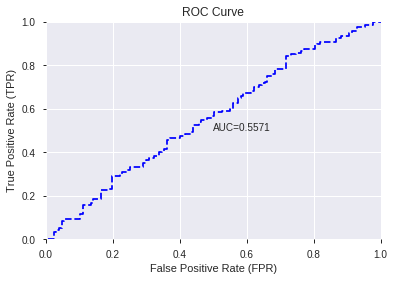

This function is available for GLM models only


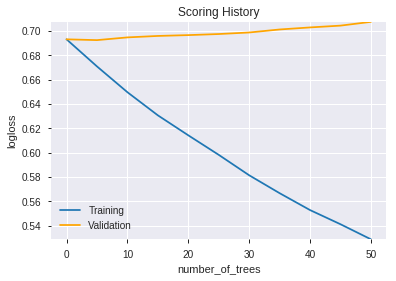

--2019-08-26 14:00:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


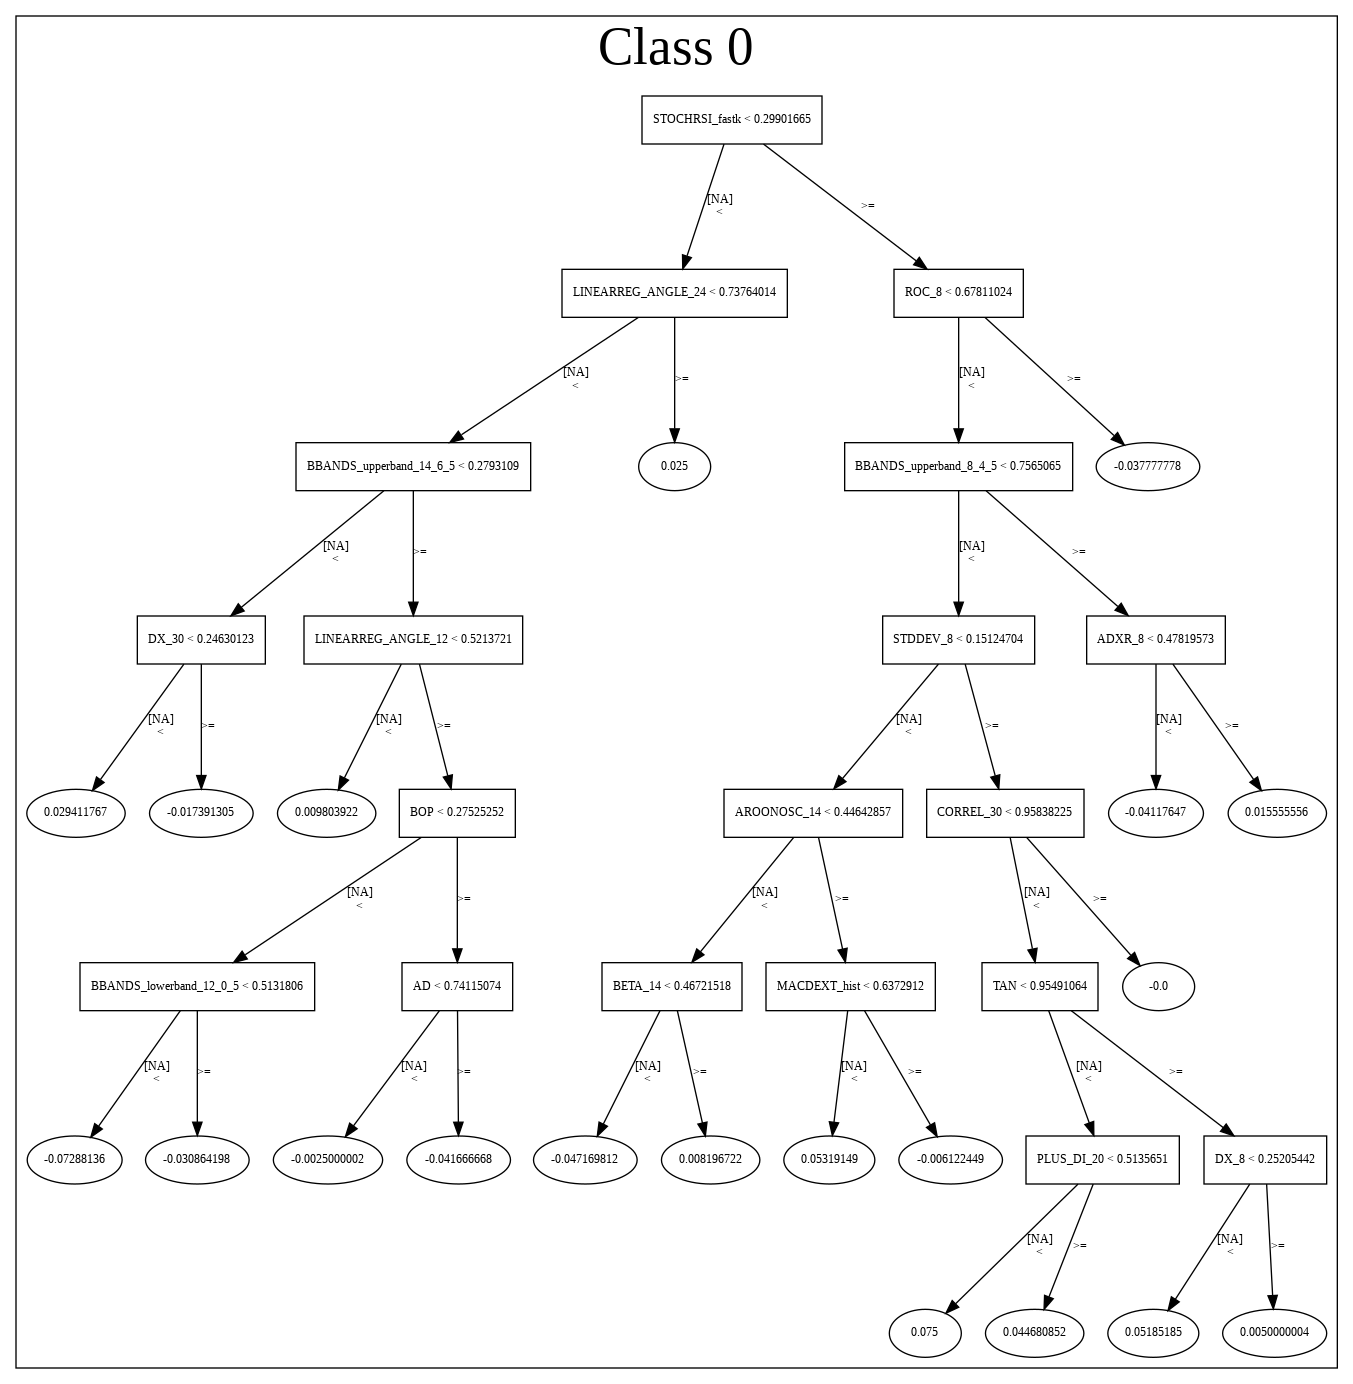

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190826_135957',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190826_135957',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a2a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_a2a1',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_140047_model_6  0.536877  0.696301              0.492126  0.501398  0.251400
1  DeepLearning_grid_1_AutoML_20190826_140047_model_8  0.527198  0.698747              0.500000  0.502785  0.252792
2  DeepLearning_grid_1_AutoML_20190826_140047_model_9  0.505643  0.706581              0.500000  0.506612  0.256655
3               DeepLearning_1_AutoML_20190826_140047  0.496588  0.753058              0.500000  0.522038  0.272524
4  DeepLearning_grid_1_AutoML_20190826_140047_model_7  0.491864  0.852210              0.500000  0.548327  0.300663
5  DeepLearning_grid_1_AutoML_20190826_140047_model_2  0.478215  0.901878              0.500000  0.534865  0.286080
6  DeepLearning_grid_1_AutoML_20190826_140047_model_4  0.474672  0.755310              0.500000  0.522012  0.272496
7  DeepLearning_grid_1_AutoML_20190826_140047_model_1  0.461024  1.061651              0.500000  0.557726  0.311059
8  DeepLearning_grid_1_AutoML_20190826_140047_model_3  0.454724  0.762332              0.500000  0.520616  0.271041
9  DeepLearning_grid_1_AutoML_20190826_140047_model_5  0.453839  0.712034              0.500000  0.506917  0.256965

variable  relative_importance  scaled_importance  percentage
0     CDLSTALLEDPATTERN             1.000000           1.000000    0.021889
1        is_quarter_end             0.988045           0.988045    0.021627
2             CDLTAKURI             0.975616           0.975616    0.021355
3      CDLDRAGONFLYDOJI             0.970215           0.970215    0.021237
4       CDLUNIQUE3RIVER             0.964327           0.964327    0.021108
5          CDLTHRUSTING             0.964220           0.964220    0.021105
6    CDLEVENINGDOJISTAR             0.958927           0.958927    0.020990
7                  COSH             0.958383           0.958383    0.020978
8    CDLUPSIDEGAP2CROWS             0.943616           0.943616    0.020654
9                  TANH             0.940759           0.940759    0.020592
10                  EXP             0.934236           0.934236    0.020449
11      CDLHOMINGPIGEON             0.933543           0.933543    0.020434
12      CDLLADDERBOTTOM             0.932827           0.932827    0.020418
13         is_month_end             0.932736           0.932736    0.020416
14       is_month_start             0.932091           0.932091    0.020402
15               VAR_14             0.927449           0.927449    0.020301
16       CDL3LINESTRIKE             0.924523           0.924523    0.020236
17     is_quarter_start             0.923348           0.923348    0.020211
18    CDLGRAVESTONEDOJI             0.919562           0.919562    0.020128
19      CDLADVANCEBLOCK             0.916991           0.916991    0.020072
20            CDL2CROWS             0.913666           0.913666    0.019999
21       CDLMORNINGSTAR             0.912659           0.912659    0.019977
22    CDLINVERTEDHAMMER             0.910313           0.910313    0.019925
23               VAR_24             0.909502           0.909502    0.019908
24               VAR_30             0.908947           0.908947    0.019896
25      CDLSHOOTINGSTAR             0.908643           0.908643    0.019889
26               VAR_20             0.905852           0.905852    0.019828
27    CDL3WHITESOLDIERS             0.905750           0.905750    0.019826
28   CDLMORNINGDOJISTAR             0.904839           0.904839    0.019806
29       CDLEVENINGSTAR             0.904518           0.904518    0.019799
30  CDLRISEFALL3METHODS             0.901783           0.901783    0.019739
31       CDLMATCHINGLOW             0.901551           0.901551    0.019734
32            CDLHAMMER             0.900461           0.900461    0.019710
33       CDLHARAMICROSS             0.899892           0.899892    0.019697
34          CDLPIERCING             0.899673           0.899673    0.019693
35    CDLDARKCLOUDCOVER             0.897672           0.897672    0.019649
36     CDLSTICKSANDWICH             0.897237           0.897237    0.019639
37                 ATAN             0.893403           0.893403    0.019555
38               VAR_12             0.893327           0.893327    0.019554
39     CDLCOUNTERATTACK             0.891943           0.891943    0.019523
40                 SINH             0.881137           0.881137    0.019287
41   CDLSEPARATINGLINES             0.880701           0.880701    0.019277
42         HT_TRENDMODE             0.879026           0.879026    0.019241
43              CDLDOJI             0.874710           0.874710    0.019146
44    CDLLONGLEGGEDDOJI             0.874079           0.874079    0.019132
45   CDLIDENTICAL3CROWS             0.872283           0.872283    0.019093
46       CDLRICKSHAWMAN             0.859705           0.859705    0.018818
47  CDLGAPSIDESIDEWHITE             0.855784           0.855784    0.018732
48            CDLONNECK             0.852745           0.852745    0.018665
49        CDLHANGINGMAN             0.852691           0.852691    0.018664

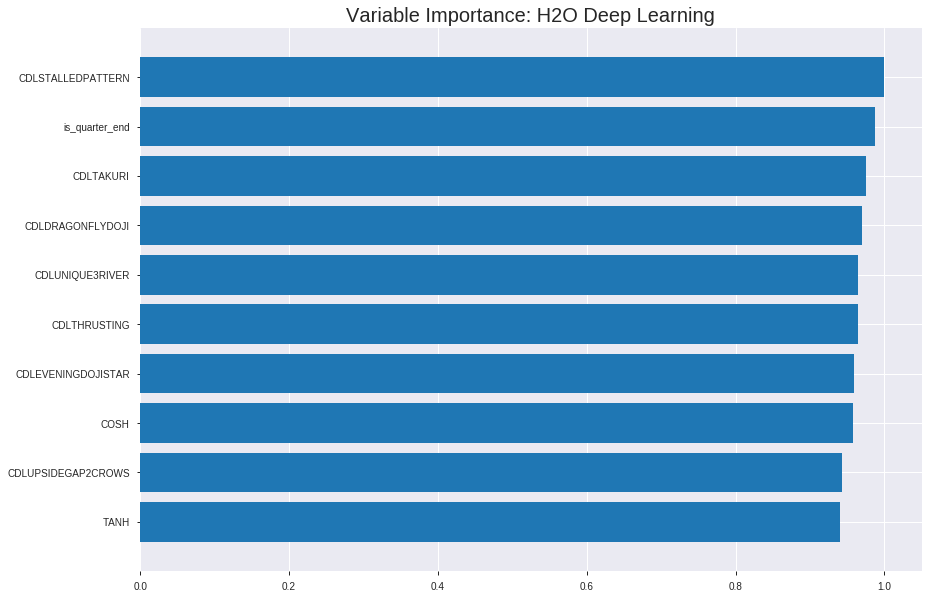

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_140047_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24587894160331492
RMSE: 0.4958618170451471
LogLoss: 0.6845607013383433
Mean Per-Class Error: 0.45998405540409837
AUC: 0.548175746677872
pr_auc: 0.5538734633324001
Gini: 0.09635149335574389
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4167138390724363: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      32   831   0.9629   (831.0/863.0)
1      5    854   0.0058   (5.0/859.0)
Total  37   1685  0.4855   (836.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.416714     0.671384  365
max f2                       0.37637      0.834469  377
max f0point5                 0.458375     0.564571  329
max accuracy                 0.505106     0.54007   206
max precision                0.769577     1         0
max recall                   0.317054     1         388
max specificity              0.769577     1         0
max absolute_mcc             0.416714     0.10779   365
max min_per_class_accuracy   0.504656     0.53085   209
max mean_per_class_accuracy  0.505106     0.540016  206

Gains/Lift Table: Avg response rate: 49.88 %, avg score: 50.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.685703           1.55918   1.55918            0.777778         0.717502  0.777778                    0.717502            0.016298        0.016298                   55.9177   55.9177
    2        0.0203252                   0.651554           1.17921   1.37462            0.588235         0.670119  0.685714                    0.694487            0.0116414       0.0279395                  17.921    37.4622
    3        0.0301974                   0.594228           1.88674   1.54204            0.941176         0.610529  0.769231                    0.66704             0.0186263       0.0465658                  88.6736   54.2044
    4        0.0400697                   0.573069           1.17921   1.45265            0.588235         0.583158  0.724638                    0.646373            0.0116414       0.0582072                  17.921    45.265
    5        0.0505226                   0.554725           1.00233   1.35948            0.5              0.56145   0.678161                    0.628803            0.0104773       0.0686845                  0.232829  35.948
    6        0.100465                    0.526473           1.04895   1.20511            0.523256         0.537979  0.601156                    0.583653            0.0523865       0.121071                   4.89482   20.5111
    7        0.150407                    0.518391           1.11888   1.17648            0.55814          0.521555  0.586873                    0.563034            0.0558789       0.17695                    11.8878   17.6478
    8        0.200348                    0.51476            1.09557   1.15631            0.546512         0.51665   0.576812                    0.551472            0.0547148       0.231665                   9.55681   15.6309
    9        0.300232                    0.509999           0.920743  1.07794            0.459302         0.511993  0.537718                    0.538338            0.0919674       0.323632                   -7.92566  7.79391
    10       0.400116                    0.506821           1.03729   1.06779            0.517442         0.508344  0.532656                    0.53085             0.103609        0.427241                   3.72932   6.77924
    11       0.5                         0.504522           1.10722   1.07567            0.552326         0.505643  0.536585                    0.525815            0.110594        0.537835                   10.7223   7.56694
    12       0.599884                    0.501866           0.944053  1.05375            0.47093          0.503168  0.525653                    0.522044            0.0942957       0.63213                    -5.59466  5.37546
    13       0.699768                    0.499851           0.827504  1.02146            0.412791         0.500835  0.509544                    0.519017            0.0826542       0.714785                   -17.2496  2.14599
    14       0.799652                    0.497421           1.04895   1.02489            0.523256         0.498672  0.511256                    0.516475            0.104773        0.819558                   4.89482   2.48934
    15       0.899535                    0.484192           1.02564   1.02498            0.511628         0.49463   0.511298                    0.51405             0.102445        0.922002                   2.56382   2.49761
    16       1                           0.176528           0.77637   1                  0.387283         0.43563   0.498839                    0.506171           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2477479084417183
RMSE: 0.497742813551053
LogLoss: 0.6887806880318327
Mean Per-Class Error: 0.4587886460554371
AUC: 0.5424273720682302
pr_auc: 0.5790097478619707
Gini: 0.08485474413646044
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4385551811645402: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    215  0.9598   (215.0/224.0)
1      2    266  0.0075   (2.0/268.0)
Total  11   481  0.4411   (217.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438555     0.71028   388
max f2                       0.393051     0.858424  396
max f0point5                 0.438555     0.606752  388
max accuracy                 0.438555     0.558943  388
max precision                0.770247     1         0
max recall                   0.393051     1         396
max specificity              0.770247     1         0
max absolute_mcc             0.546621     0.115161  50
max min_per_class_accuracy   0.499554     0.517857  220
max mean_per_class_accuracy  0.501205     0.541211  184

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 51.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101626                   0.731296           0.734328  0.734328           0.4              0.754633  0.4                         0.754633            0.00746269      0.00746269                 -26.5672   -26.5672
    2        0.0203252                   0.716083           1.10149   0.91791            0.6              0.722846  0.5                         0.738739            0.011194        0.0186567                  10.1493    -8.20896
    3        0.0304878                   0.688352           0.734328  0.856716           0.4              0.701265  0.466667                    0.726248            0.00746269      0.0261194                  -26.5672   -14.3284
    4        0.0406504                   0.677102           1.46866   1.0097             0.8              0.685821  0.55                        0.716141            0.0149254       0.0410448                  46.8657    0.970149
    5        0.050813                    0.629767           1.46866   1.10149            0.8              0.643323  0.6                         0.701578            0.0149254       0.0559701                  46.8657    10.1493
    6        0.101626                    0.547381           1.46866   1.28507            0.8              0.575008  0.7                         0.638293            0.0746269       0.130597                   46.8657    28.5075
    7        0.150407                    0.523641           0.994403  1.1908             0.541667         0.536885  0.648649                    0.605404            0.0485075       0.179104                   -0.559701  19.0803
    8        0.20122                     0.510539           0.954627  1.13116            0.52             0.517028  0.616162                    0.583087            0.0485075       0.227612                   -4.53731   13.1162
    9        0.300813                    0.505725           1.08651   1.11638            0.591837         0.507165  0.608108                    0.55795             0.108209        0.335821                   8.65062    11.6378
    10       0.400407                    0.501259           0.974109  1.08099            0.530612         0.503857  0.588832                    0.544496            0.0970149       0.432836                   -2.5891    8.0991
    11       0.5                         0.499561           0.824246  1.02985            0.44898          0.500392  0.560976                    0.535711            0.0820896       0.514925                   -17.5754   2.98507
    12       0.599593                    0.498552           1.16144   1.05171            0.632653         0.499084  0.572881                    0.529627            0.115672        0.630597                   16.1438    5.17076
    13       0.699187                    0.497651           0.78678   1.01397            0.428571         0.498078  0.552326                    0.525133            0.0783582       0.708955                   -21.322    1.39708
    14       0.79878                     0.49614            0.936643  1.00433            0.510204         0.497107  0.547074                    0.521639            0.0932836       0.802239                   -6.33567   0.43295
    15       0.898374                    0.493746           1.08651   1.01344            0.591837         0.495136  0.552036                    0.518701            0.108209        0.910448                   8.65062    1.34396
    16       1                           0.212225           0.881194  1                  0.48             0.455184  0.544715                 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:06:15  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:06:18  2 min 41.353 sec  899 obs/sec       1.259     1             2168       0.529558         0.782091            -0.121732      0.527888        0.537071           1.33644          0.498839                         0.540594           0.849249              -0.178393        0.524279          0.566462             1.46866            0.453252
    2019-08-26 14:06:26  2 min 49.655 sec  1992 obs/sec      11.4495   9             19716      0.495862         0.684561            0.0164789      0.548176        0.553873           1.55918          0.485482                         0.497743           0.688781              0.00101863       0.542427          0.57901              0.734328           0.441057
    2019-08-26 14:06:34  2 min 57.942 sec  2388 obs/sec      24.1295   19            41551      0.499003         0.689824            0.00397961     0.568142        0.581508           1.78192          0.47619                          0.502254           0.701831              -0.0171697       0.520764          0.565416             1.10149            0.432927
    2019-08-26 14:06:43  3 min  6.427 sec  2614 obs/sec      38.1214   30            65645      0.491585         0.674105            0.0333709      0.601761        0.60734            1.78192          0.471545                         0.501738           0.704278              -0.0150842       0.53738           0.576775             1.10149            0.436992
    2019-08-26 14:06:51  3 min 14.593 sec  2762 obs/sec      52.1551   41            89811      0.492537         0.675882            0.0296232      0.599337        0.612818           1.78192          0.452381                         0.500108           0.698729              -0.00849756      0.547908          0.569683             1.10149            0.434959
    2019-08-26 14:06:59  3 min 22.332 sec  2882 obs/sec      66.0819   52            113793     0.483924         0.657588            0.0632662      0.635882        0.64747            2.00466          0.450058                         0.49754            0.695137              0.00183375       0.547558          0.579612             1.10149            0.426829
    2019-08-26 14:07:07  3 min 30.264 sec  2956 obs/sec      80.0308   63            137813     0.480994         0.650344            0.0745748      0.633656        0.656583           2.00466          0.444251                         0.49655            0.693766              0.00579919       0.548949          0.583562             1.10149            0.422764
    2019-08-26 14:07:08  3 min 31.067 sec  2955 obs/sec      80.0308   63            137813     0.495862         0.684561            0.0164789      0.548176        0.553873           1.55918          0.485482                         0.497743           0.688781              0.00101863       0.542427          0.57901              0.734328           0.441057

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
CDLSTALLEDPATTERN    1.0                    1.0                  0.021888587747791847
is_quarter_end       0.9880450367927551     0.9880450367927551   0.021626910486608444
CDLTAKURI            0.9756157398223877     0.9756157398223877   0.021354850729229193
CDLDRAGONFLYDOJI     0.9702150225639343     0.9702150225639343   0.021236636655616523
CDLUNIQUE3RIVER      0.964326798915863      0.964326798915863    0.02110775175561709
---                  ---                    ---                  ---
CDLIDENTICAL3CROWS   0.872282862663269      0.872282862663269    0.019093039980300028
CDLRICKSHAWMAN       0.85970538854599       0.85970538854599     0.018817736834438385
CDLGAPSIDESIDEWHITE  0.8557838201522827     0.8557838201522827   0.01873189924054376
CDLONNECK            0.8527452945709229     0.8527452945709229   0.01866539020673225
CDLHANGINGMAN        0.8526908159255981     0.8526908159255981   0.01866419774612368


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5465587044534413)

('F1', 0.6575342465753424)

('auc', 0.5368766404199475)

('logloss', 0.6963012454975953)

('mean_per_class_error', 0.4510498687664042)

('rmse', 0.5013976198449897)

('mse', 0.2513995731862208)

deeplearning prediction progress: |███████████████████████████████████████| 100%


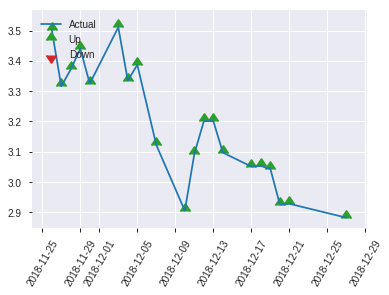


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2513995731862208
RMSE: 0.5013976198449897
LogLoss: 0.6963012454975953
Mean Per-Class Error: 0.4510498687664042
AUC: 0.5368766404199475
pr_auc: 0.5051157157888687
Gini: 0.07375328083989507
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4059279234383081: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    125  0.9843   (125.0/127.0)
1      0    120  0        (0.0/120.0)
Total  2    245  0.5061   (125.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405928     0.657534  244
max f2                       0.405928     0.827586  244
max f0point5                 0.499688     0.554245  181
max accuracy                 0.510618     0.546559  49
max precision                0.647593     0.6       4
max recall                   0.405928     1         244
max specificity              0.764204     0.992126  0
max absolute_mcc             0.499688     0.102628  181
max min_per_class_accuracy   0.501829     0.533333  122
max mean_per_class_accuracy  0.500857     0.54895   143

Gains/Lift Table: Avg response rate: 48.58 %, avg score: 50.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.655055           0.686111  0.686111           0.333333         0.695443  0.333333                    0.695443            0.00833333      0.00833333                 -31.3889  -31.3889
    2        0.0202429                   0.628401           2.05833   1.235              1                0.650111  0.6                         0.67731             0.0166667       0.025                      105.833   23.5
    3        0.0323887                   0.613785           0.686111  1.02917            0.333333         0.622813  0.5                         0.656874            0.00833333      0.0333333                  -31.3889  2.91667
    4        0.0404858                   0.601514           1.02917   1.02917            0.5              0.60734   0.5                         0.646967            0.00833333      0.0416667                  2.91667   2.91667
    5        0.0526316                   0.59063            0.686111  0.95               0.333333         0.597275  0.461538                    0.6355              0.00833333      0.05                       -31.3889  -5
    6        0.101215                    0.535722           0.857639  0.905667           0.416667         0.549433  0.44                        0.594188            0.0416667       0.0916667                  -14.2361  -9.43333
    7        0.149798                    0.520392           1.37222   1.05698            0.666667         0.529193  0.513514                    0.573108            0.0666667       0.158333                   37.2222   5.6982
    8        0.202429                    0.510501           1.58333   1.19383            0.769231         0.514714  0.58                        0.557926            0.0833333       0.241667                   58.3333   19.3833
    9        0.299595                    0.506268           0.771875  1.05698            0.375            0.507924  0.513514                    0.541709            0.075           0.316667                   -22.8125  5.6982
    10       0.40081                     0.503112           0.905667  1.01877            0.44             0.505069  0.494949                    0.532457            0.0916667       0.408333                   -9.43333  1.8771
    11       0.502024                    0.501774           1.235     1.06237            0.6              0.502287  0.516129                    0.526374            0.125           0.533333                   23.5      6.23656
    12       0.59919                     0.500679           1.02917   1.05698            0.5              0.501145  0.513514                    0.522283            0.1             0.633333                   2.91667   5.6982
    13       0.700405                    0.500063           0.988     1.04701            0.48             0.500372  0.508671                    0.519117            0.1             0.733333                   -1.2      4.70135
    14       0.797571                    0.498346           0.771875  1.01349            0.375            0.499329  0.492386                    0.516706            0.075           0.808333                   -22.8125  1.34941
    15       0.898785                    0.488823           0.823333  0.99208            0.4              0.495382  0.481982                    0.514304            0.0833333       0.891667                   -17.6667  -0.792042
    16       1                           0.389023           1.07033   1                  0.52             0.464629  0.48583                     0.509277            0.108

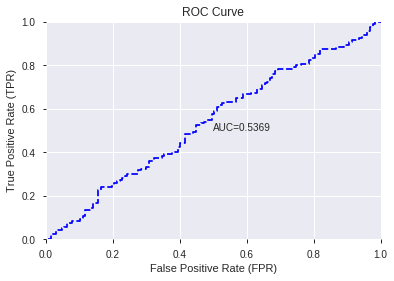

This function is available for GLM models only


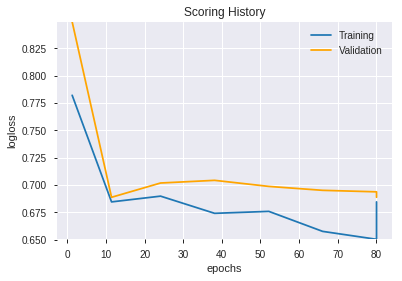

--2019-08-26 14:11:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


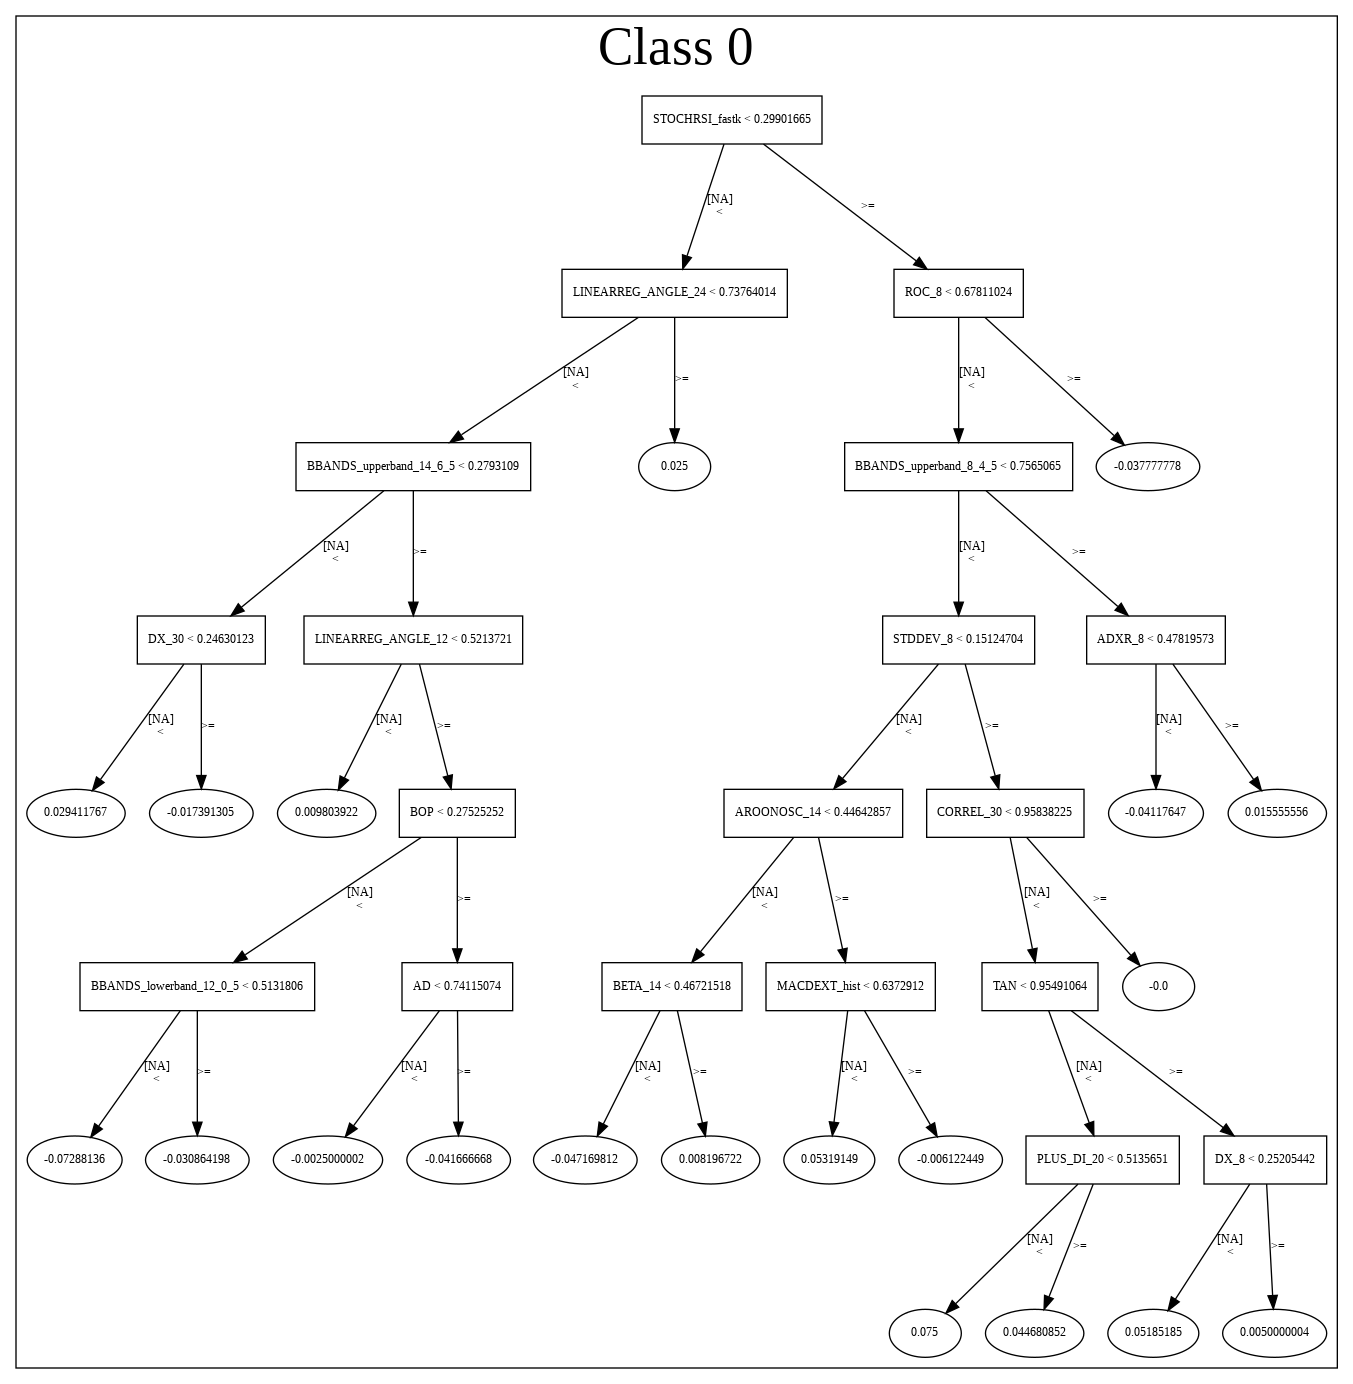

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_140047_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_140047_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a2a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLSTALLEDPATTERN',
 'is_quarter_end',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLUNIQUE3RIVER',
 'CDLTHRUSTING',
 'CDLEVENINGDOJISTAR',
 'COSH',
 'CDLUPSIDEGAP2CROWS',
 'TANH',
 'EXP',
 'CDLHOMINGPIGEON',
 'CDLLADDERBOTTOM',
 'is_month_end',
 'is_month_start',
 'VAR_14',
 'CDL3LINESTRIKE',
 'is_quarter_start',
 'CDLGRAVESTONEDOJI',
 'CDLADVANCEBLOCK',
 'CDL2CROWS',
 'CDLMORNINGSTAR',
 'CDLINVERTEDHAMMER',
 'VAR_24',
 'VAR_30',
 'CDLSHOOTINGSTAR',
 'VAR_20',
 'CDL3WHITESOLDIERS',
 'CDLMORNINGDOJISTAR',
 'CDLEVENINGSTAR',
 'CDLRISEFALL3METHODS',
 'CDLMATCHINGLOW',
 'CDLHAMMER',
 'CDLHARAMICROSS',
 'CDLPIERCING',
 'CDLDARKCLOUDCOVER',
 'CDLSTICKSANDWICH',
 'ATAN',
 'VAR_12',
 'CDLCOUNTERATTACK',
 'SINH',
 'CDLSEPARATINGLINES',
 'HT_TRENDMODE',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLIDENTICAL3CROWS',
 'CDLRICKSHAWMAN',
 'CDLGAPSIDESIDEWHITE',
 'CDLONNECK',
 'CDLHANGINGMAN']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_141132_model_1  0.492717  0.69381                   0.5  0.500312  0.250312

variable  relative_importance  scaled_importance  percentage
0     CDLSTALLEDPATTERN             0.030662           1.000000    0.063512
1      CDLSTICKSANDWICH             0.027312           0.890737    0.056573
2                  TANH             0.023719           0.773558    0.049131
3    CDLEVENINGDOJISTAR             0.023163           0.755421    0.047979
4             CDLONNECK             0.019723           0.643217    0.040852
5             CDL2CROWS             0.019114           0.623364    0.039591
6       CDLHOMINGPIGEON             0.018462           0.602106    0.038241
7        is_month_start             0.017903           0.583888    0.037084
8       CDLUNIQUE3RIVER             0.013727           0.447684    0.028433
9     CDL3WHITESOLDIERS             0.013599           0.443502    0.028168
10    CDLINVERTEDHAMMER             0.013579           0.442855    0.028127
11   CDLUPSIDEGAP2CROWS             0.013518           0.440863    0.028000
12       CDLHARAMICROSS             0.013489           0.439924    0.027941
13       CDL3LINESTRIKE             0.013468           0.439220    0.027896
14     CDLCOUNTERATTACK             0.013460           0.438988    0.027881
15    CDLDARKCLOUDCOVER             0.013270           0.432779    0.027487
16   CDLIDENTICAL3CROWS             0.013226           0.431354    0.027396
17        CDLHANGINGMAN             0.013087           0.426809    0.027108
18            CDLTAKURI             0.012884           0.420182    0.026687
19     CDLDRAGONFLYDOJI             0.012883           0.420159    0.026685
20                 ATAN             0.012854           0.419222    0.026626
21       CDLMATCHINGLOW             0.012632           0.411963    0.026165
22  CDLRISEFALL3METHODS             0.012462           0.406433    0.025814
23         is_month_end             0.010482           0.341867    0.021713
24       is_quarter_end             0.007863           0.256428    0.016286
25  CDLGAPSIDESIDEWHITE             0.007271           0.237139    0.015061
26     is_quarter_start             0.006929           0.225963    0.014351
27               VAR_14             0.006625           0.216048    0.013722
28      CDLLADDERBOTTOM             0.006341           0.206800    0.013134
29   CDLSEPARATINGLINES             0.005891           0.192116    0.012202
30          CDLPIERCING             0.005830           0.190126    0.012075
31      CDLADVANCEBLOCK             0.004887           0.159392    0.010123
32         CDLTHRUSTING             0.004359           0.142146    0.009028
33       CDLMORNINGSTAR             0.004005           0.130618    0.008296
34    CDLLONGLEGGEDDOJI             0.003094           0.100907    0.006409
35                  EXP             0.003086           0.100630    0.006391
36                 SINH             0.003074           0.100251    0.006367
37                 COSH             0.003066           0.099989    0.006351
38    CDLGRAVESTONEDOJI             0.002899           0.094544    0.006005
39      CDLSHOOTINGSTAR             0.002861           0.093300    0.005926
40               VAR_30             0.002811           0.091689    0.005823
41            CDLHAMMER             0.002611           0.085159    0.005409
42               VAR_12             0.002229           0.072699    0.004617
43              CDLDOJI             0.001836           0.059864    0.003802
44               VAR_20             0.001485           0.048443    0.003077
45         HT_TRENDMODE             0.001360           0.044368    0.002818
46       CDLRICKSHAWMAN             0.001198           0.039056    0.002481
47   CDLMORNINGDOJISTAR             0.001112           0.036277    0.002304
48               VAR_24             0.000689           0.022473    0.001427
49       CDLEVENINGSTAR             0.000688           0.022431    0.001425

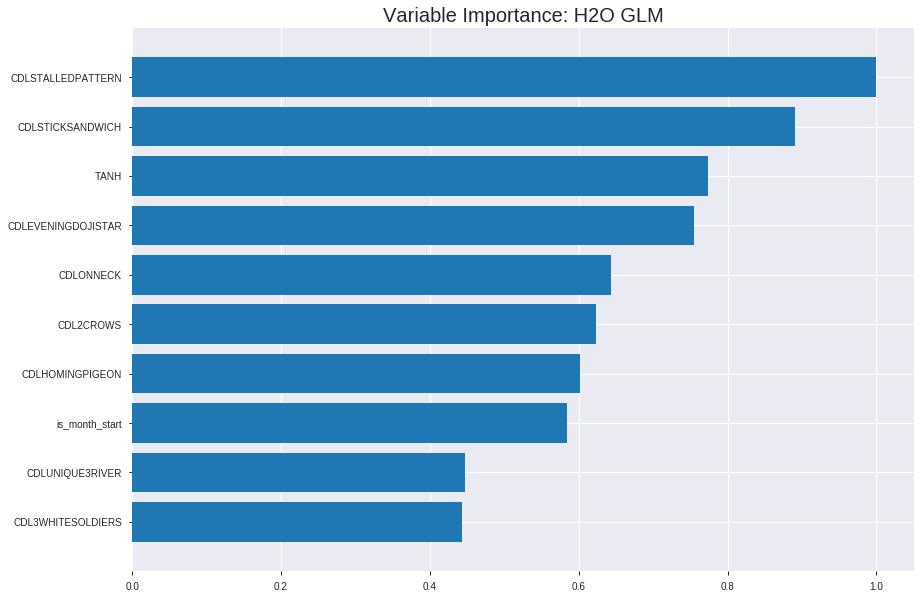

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_141132_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2471186613276176
RMSE: 0.4971103110252468
LogLoss: 0.6873014809717851
Null degrees of freedom: 1721
Residual degrees of freedom: 1671
Null deviance: 2387.1895983186078
Residual deviance: 2367.066300466828
AIC: 2469.066300466828
AUC: 0.5521335676910147
pr_auc: 0.563351891712702
Gini: 0.10426713538202947
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43299937465397326: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      20   843   0.9768   (843.0/863.0)
1      1    858   0.0012   (1.0/859.0)
Total  21   1701  0.4901   (844.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432999     0.670313  382
max f2                       0.432999     0.835118  382
max f0point5                 0.489267     0.566144  292
max accuracy                 0.49738      0.544135  215
max precision                0.666105     1         0
max recall                   0.428788     1         387
max specificity              0.666105     1         0
max absolute_mcc             0.535011     0.107938  53
max min_per_class_accuracy   0.496191     0.519119  229
max mean_per_class_accuracy  0.49738      0.543942  215

Gains/Lift Table: Avg response rate: 49.88 %, avg score: 49.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010453                    0.563551           1.67055   1.67055            0.833333         0.605274  0.833333                    0.605274            0.0174622       0.0174622                  67.0547    67.0547
    2        0.0203252                   0.552394           1.17921   1.4319             0.588235         0.555108  0.714286                    0.580908            0.0116414       0.0291036                  17.921     43.1898
    3        0.0301974                   0.544576           1.88674   1.58059            0.941176         0.549355  0.788462                    0.570593            0.0186263       0.0477299                  88.6736    58.0595
    4        0.0400697                   0.537096           1.17921   1.4817             0.588235         0.540685  0.73913                     0.563224            0.0116414       0.0593714                  17.921     48.1703
    5        0.0505226                   0.533158           1.1137    1.40556            0.555556         0.534522  0.701149                    0.557286            0.0116414       0.0710128                  11.3698    40.5564
    6        0.100465                    0.520368           1.1655    1.28622            0.581395         0.527059  0.641618                    0.54226             0.0582072       0.12922                    16.5498    28.6225
    7        0.150407                    0.510375           1.00233   1.19196            0.5              0.514336  0.594595                    0.532988            0.0500582       0.179278                   0.232829   19.1958
    8        0.200348                    0.503824           1.04895   1.15631            0.523256         0.506987  0.576812                    0.526506            0.0523865       0.231665                   4.89482    15.6309
    9        0.300232                    0.498961           1.10722   1.13998            0.552326         0.500949  0.568665                    0.518004            0.110594        0.342258                   10.7223    13.9979
    10       0.400116                    0.497512           1.00233   1.10562            0.5              0.498125  0.551524                    0.513041            0.100116        0.442375                   0.232829   10.5616
    11       0.5                         0.496169           0.792539  1.04307            0.395349         0.496783  0.520325                    0.509793            0.0791618       0.521537                   -20.7461   4.30733
    12       0.599884                    0.495344           1.00233   1.03629            0.5              0.495731  0.516941                    0.507452            0.100116        0.621653                   0.232829   3.62891
    13       0.699768                    0.494759           0.990673  1.02978            0.494186         0.495063  0.513693                    0.505684            0.0989523       0.720605                   -0.932669  2.97779
    14       0.799652                    0.493894           0.967363  1.02198            0.482558         0.494355  0.509804                    0.504269            0.096624        0.817229                   -3.26367   2.19818
    15       0.899535                    0.489823           1.10722   1.03145            0.552326         0.492681  0.514526                    0.502982            0.110594        0.927823                   10.7223    3.14469
    16       1                           0.356566           0.718432  1                  0.358382         0.461741  0.498839                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2487999482598483
RMSE: 0.4987985046688174
LogLoss: 0.6907577533090127
Null degrees of freedom: 491
Residual degrees of freedom: 441
Null deviance: 682.2638942389361
Residual deviance: 679.7056292560685
AIC: 781.7056292560685
AUC: 0.5348813965884861
pr_auc: 0.5672653140266555
Gini: 0.0697627931769722
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4317059195165384: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    222  0.9911   (222.0/224.0)
1      0    268  0        (0.0/268.0)
Total  2    490  0.4512   (222.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.431706     0.707124   397
max f2                       0.431706     0.857875   397
max f0point5                 0.49242      0.604369   355
max accuracy                 0.49242      0.556911   355
max precision                0.667405     1          0
max recall                   0.431706     1          397
max specificity              0.667405     1          0
max absolute_mcc             0.506316     0.0927946  170
max min_per_class_accuracy   0.499524     0.526786   229
max mean_per_class_accuracy  0.506316     0.544876   170

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 50.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.633493           0.734328  0.734328           0.4              0.654511  0.4                         0.654511            0.00746269      0.00746269                 -26.5672  -26.5672
    2        0.0203252                   0.614251           1.46866   1.10149            0.8              0.629571  0.6                         0.642041            0.0149254       0.0223881                  46.8657   10.1493
    3        0.0304878                   0.585097           0.734328  0.979104           0.4              0.605342  0.533333                    0.629808            0.00746269      0.0298507                  -26.5672  -2.08955
    4        0.0406504                   0.56275            1.10149   1.0097             0.6              0.576069  0.55                        0.616373            0.011194        0.0410448                  10.1493   0.970149
    5        0.050813                    0.551444           0.367164  0.881194           0.2              0.559301  0.48                        0.604959            0.00373134      0.0447761                  -63.2836  -11.8806
    6        0.101626                    0.534862           1.32179   1.10149            0.72             0.540988  0.6                         0.572974            0.0671642       0.11194                    32.1791   10.1493
    7        0.150407                    0.528394           1.0709    1.09157            0.583333         0.531863  0.594595                    0.55964             0.0522388       0.164179                   7.08955   9.15692
    8        0.20122                     0.521689           1.10149   1.09408            0.6              0.525555  0.59596                     0.551033            0.0559701       0.220149                   10.1493   9.40751
    9        0.300813                    0.509715           1.08651   1.09157            0.591837         0.514617  0.594595                    0.538976            0.108209        0.328358                   8.65062   9.15692
    10       0.400407                    0.50365            1.04904   1.08099            0.571429         0.506825  0.588832                    0.530979            0.104478        0.432836                   4.90405   8.0991
    11       0.5                         0.499617           0.899178  1.04478            0.489796         0.501797  0.569106                    0.525166            0.0895522       0.522388                   -10.0822  4.47761
    12       0.599593                    0.498254           0.861712  1.01437            0.469388         0.498919  0.552542                    0.520807            0.0858209       0.608209                   -13.8288  1.43688
    13       0.699187                    0.497203           1.04904   1.01931            0.571429         0.497738  0.555233                    0.517521            0.104478        0.712687                   4.90405   1.93075
    14       0.79878                     0.496613           0.899178  1.00433            0.489796         0.496936  0.547074                    0.514954            0.0895522       0.802239                   -10.0822  0.43295
    15       0.898374                    0.493082           1.08651   1.01344            0.591837         0.496014  0.552036                    0.512854            0.108209        0.910448                   8.65062   1.34396
    16       1                           0.382314           0.881194  1                  0.48             0.476857  0.544715                    0.509196      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 14:11:32  0.000 sec   2            2.7       51            1.38214           1.38396
    2019-08-26 14:11:32  0.011 sec   4            1.7       51            1.38018           1.38298
    2019-08-26 14:11:32  0.024 sec   6            1         51            1.37764           1.38204
    2019-08-26 14:11:32  0.036 sec   8            0.65      51            1.3746            1.38152
    2019-08-26 14:11:32  0.048 sec   10           0.4       51            1.37133           1.38183
    2019-08-26 14:11:32  0.060 sec   12           0.25      51            1.36813           1.38331
    2019-08-26 14:11:32  0.077 sec   14           0.15      51            1.36528           1.38593
    2019-08-26 14:11:32  0.088 sec   16           0.096     51            1.3629            1.38937
    2019-08-26 14:11:32  0.105 sec   18           0.06      51            1.36099           1.39319

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5425101214574899)

('F1', 0.6539509536784741)

('auc', 0.49271653543307087)

('logloss', 0.6938104106128802)

('mean_per_class_error', 0.4685367454068241)

('rmse', 0.500311896640957)

('mse', 0.2503119939204716)

glm prediction progress: |████████████████████████████████████████████████| 100%


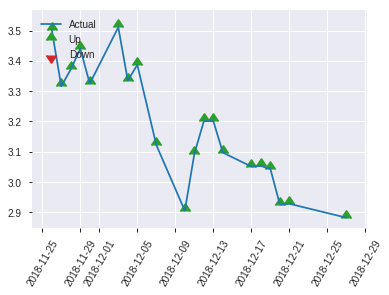


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2503119939204716
RMSE: 0.500311896640957
LogLoss: 0.6938104106128802
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 342.38351957249984
Residual deviance: 342.7423428427628
AIC: 444.7423428427628
AUC: 0.49271653543307087
pr_auc: 0.5116622688770717
Gini: -0.014566929133858264
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35546854037676306: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    127  1        (127.0/127.0)
1      0    120  0        (0.0/120.0)
Total  0    247  0.5142   (127.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355469     0.653951  246
max f2                       0.355469     0.825309  246
max f0point5                 0.355469     0.541516  246
max accuracy                 0.555748     0.54251   8
max precision                0.555748     0.888889  8
max recall                   0.355469     1         246
max specificity              0.634735     0.992126  0
max absolute_mcc             0.555748     0.156822  8
max min_per_class_accuracy   0.496344     0.483333  122
max mean_per_class_accuracy  0.52814      0.531463  26

Gains/Lift Table: Avg response rate: 48.58 %, avg score: 50.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.576214           1.37222   1.37222            0.666667         0.614757  0.666667                    0.614757            0.0166667       0.0166667                  37.2222   37.2222
    2        0.0202429                   0.571392           2.05833   1.64667            1                0.574545  0.8                         0.598672            0.0166667       0.0333333                  105.833   64.6667
    3        0.0323887                   0.556049           2.05833   1.80104            1                0.561257  0.875                       0.584641            0.025           0.0583333                  105.833   80.1042
    4        0.0404858                   0.552224           1.02917   1.64667            0.5              0.55413   0.8                         0.578539            0.00833333      0.0666667                  2.91667   64.6667
    5        0.0526316                   0.550849           0.686111  1.425              0.333333         0.551806  0.692308                    0.57237             0.00833333      0.075                      -31.3889  42.5
    6        0.101215                    0.530253           1.20069   1.31733            0.583333         0.538088  0.64                        0.555915            0.0583333       0.133333                   20.0694   31.7333
    7        0.149798                    0.522134           0.514583  1.05698            0.25             0.524993  0.513514                    0.545886            0.025           0.158333                   -48.5417  5.6982
    8        0.202429                    0.51528            1.26667   1.1115             0.615385         0.518419  0.54                        0.538745            0.0666667       0.225                      26.6667   11.15
    9        0.299595                    0.49951            0.686111  0.973536           0.333333         0.504208  0.472973                    0.527543            0.0666667       0.291667                   -31.3889  -2.6464
    10       0.40081                     0.497281           0.823333  0.935606           0.4              0.498252  0.454545                    0.520147            0.0833333       0.375                      -17.6667  -6.43939
    11       0.502024                    0.496253           1.07033   0.962769           0.52             0.496758  0.467742                    0.515431            0.108333        0.483333                   7.03333   -3.72312
    12       0.59919                     0.495772           1.11493   0.987444           0.541667         0.495941  0.47973                     0.512271            0.108333        0.591667                   11.4931   -1.25563
    13       0.700405                    0.495351           0.905667  0.975626           0.44             0.495558  0.473988                    0.509855            0.0916667       0.683333                   -9.43333  -2.43738
    14       0.797571                    0.494918           1.11493   0.992597           0.541667         0.495189  0.482234                    0.508069            0.108333        0.791667                   11.4931   -0.740271
    15       0.898785                    0.49162            0.905667  0.982808           0.44             0.494044  0.477477                    0.506489            0.0916667       0.883333                   -9.43333  -1.71922
    16       1                           0.355469           1.15267   1                  0.56             0.475728  0.48583                     0.503376        

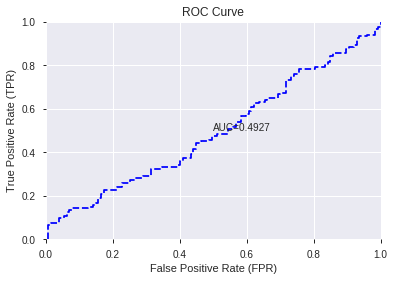

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


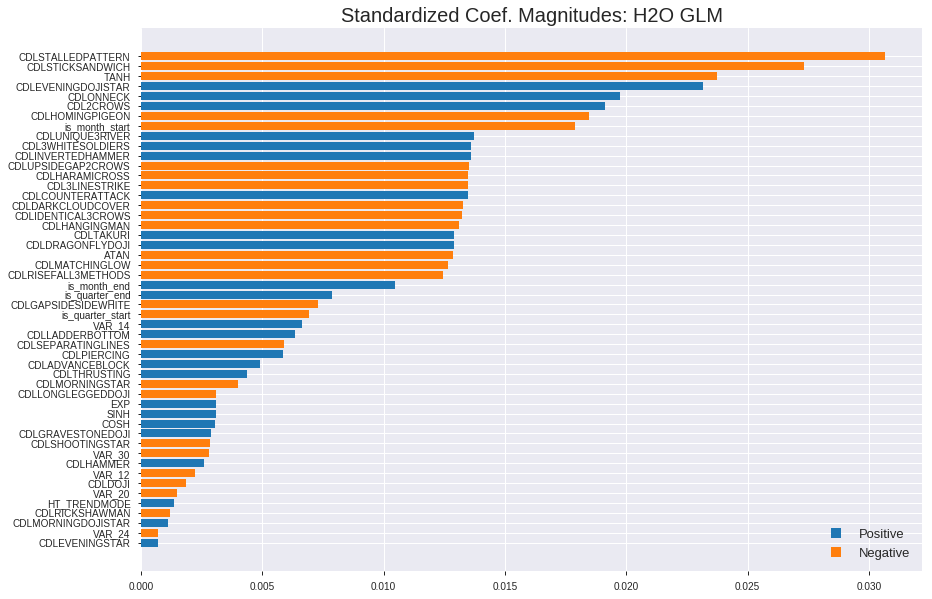

'log_likelihood'
--2019-08-26 14:11:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


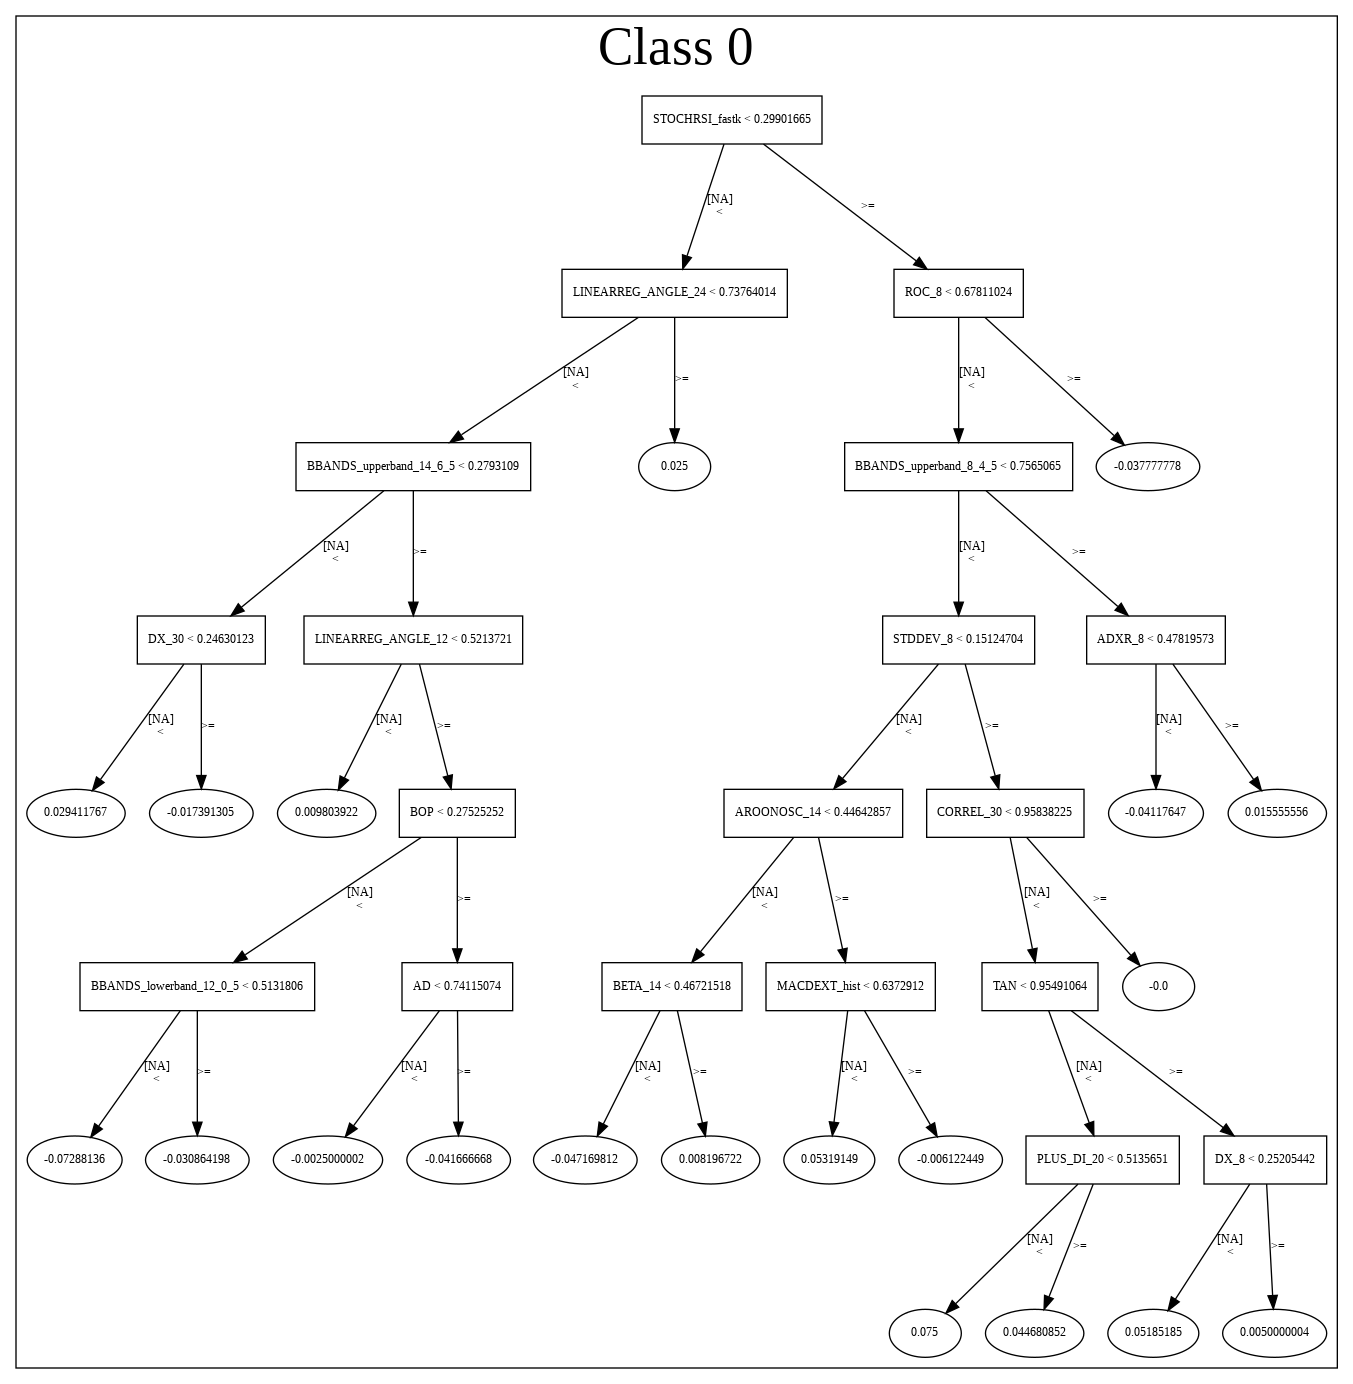

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_141132_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_141132_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a2a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CDLSTALLEDPATTERN',
 'CDLSTICKSANDWICH',
 'TANH',
 'CDLEVENINGDOJISTAR',
 'CDLONNECK',
 'CDL2CROWS',
 'CDLHOMINGPIGEON',
 'is_month_start',
 'CDLUNIQUE3RIVER',
 'CDL3WHITESOLDIERS',
 'CDLINVERTEDHAMMER',
 'CDLUPSIDEGAP2CROWS',
 'CDLHARAMICROSS',
 'CDL3LINESTRIKE',
 'CDLCOUNTERATTACK',
 'CDLDARKCLOUDCOVER',
 'CDLIDENTICAL3CROWS',
 'CDLHANGINGMAN',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'ATAN',
 'CDLMATCHINGLOW',
 'CDLRISEFALL3METHODS',
 'is_month_end',
 'is_quarter_end',
 'CDLGAPSIDESIDEWHITE',
 'is_quarter_start',
 'VAR_14',
 'CDLLADDERBOTTOM',
 'CDLSEPARATINGLINES',
 'CDLPIERCING',
 'CDLADVANCEBLOCK',
 'CDLTHRUSTING',
 'CDLMORNINGSTAR',
 'CDLLONGLEGGEDDOJI',
 'EXP',
 'SINH',
 'COSH',
 'CDLGRAVESTONEDOJI',
 'CDLSHOOTINGSTAR',
 'VAR_30',
 'CDLHAMMER',
 'VAR_12',
 'CDLDOJI',
 'VAR_20',
 'HT_TRENDMODE',
 'CDLRICKSHAWMAN',
 'CDLMORNINGDOJISTAR',
 'VAR_24',
 'CDLEVENINGSTAR']

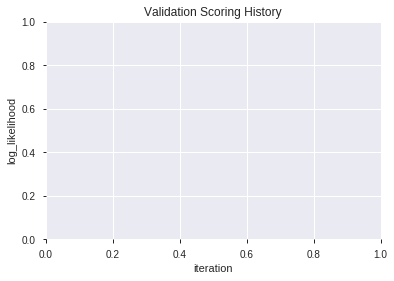

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_141142_model_7  0.541535  0.702243              0.500000  0.503919  0.253934
1               XGBoost_1_AutoML_20190826_141142  0.537303  0.699645              0.469193  0.502996  0.253005
2  XGBoost_grid_1_AutoML_20190826_141142_model_5  0.537008  0.721215              0.496063  0.511747  0.261885
3  XGBoost_grid_1_AutoML_20190826_141142_model_3  0.526115  0.694814              0.469652  0.500720  0.250720
4  XGBoost_grid_1_AutoML_20190826_141142_model_4  0.520112  0.694512              0.488419  0.500687  0.250688
5               XGBoost_2_AutoML_20190826_141142  0.519751  0.701496              0.480774  0.504010  0.254026
6  XGBoost_grid_1_AutoML_20190826_141142_model_1  0.517323  0.697311              0.496063  0.501989  0.251993
7               XGBoost_3_AutoML_20190826_141142  0.504495  0.698358              0.488189  0.502500  0.252506
8  XGBoost_grid_1_AutoML_20190826_141142_model_6  0.497933  0.697425              0.476608  0.502071  0.252075
9  XGBoost_grid_1_AutoML_20190826_141142_model_2  0.491831  0.699842              0.488189  0.503302  0.253313

variable  relative_importance  scaled_importance  percentage
0              VAR_30           800.983154           1.000000    0.161333
1              VAR_14           762.559448           0.952029    0.153594
2              VAR_24           743.428345           0.928145    0.149741
3                ATAN           686.462280           0.857025    0.138267
4              VAR_12           658.683167           0.822343    0.132671
5              VAR_20           644.338135           0.804434    0.129782
6                COSH           245.199860           0.306124    0.049388
7                TANH           218.788177           0.273150    0.044068
8                 EXP            78.461914           0.097957    0.015804
9        HT_TRENDMODE            25.260063           0.031536    0.005088
10   CDLDRAGONFLYDOJI            18.656645           0.023292    0.003758
11     is_month_start            15.110535           0.018865    0.003044
12            CDLDOJI            12.541546           0.015658    0.002526
13               SINH            12.139044           0.015155    0.002445
14      CDLHANGINGMAN            11.095707           0.013853    0.002235
15     CDLRICKSHAWMAN            10.640438           0.013284    0.002143
16  CDLLONGLEGGEDDOJI             7.860325           0.009813    0.001583
17       is_month_end             7.540117           0.009414    0.001519
18     CDLHARAMICROSS             3.022945           0.003774    0.000609
19          CDLHAMMER             1.998620           0.002495    0.000403

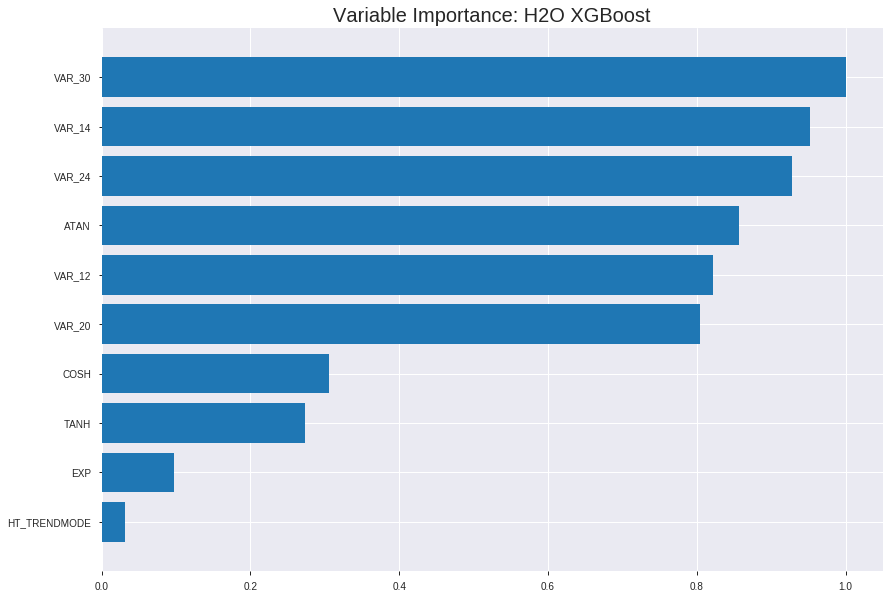

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_141142_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1944354684905187
RMSE: 0.4409483739515531
LogLoss: 0.5786781478857523
Mean Per-Class Error: 0.2113589732867316
AUC: 0.8683424230120178
pr_auc: 0.8641514695458279
Gini: 0.7366848460240356
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4789626631471846: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      630  233  0.27     (233.0/863.0)
1      133  726  0.1548   (133.0/859.0)
Total  763  959  0.2125   (366.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478963     0.79868   213
max f2                       0.398847     0.876321  296
max f0point5                 0.514315     0.796348  177
max accuracy                 0.49976      0.788618  191
max precision                0.76708      1         0
max recall                   0.279342     1         383
max specificity              0.76708      1         0
max absolute_mcc             0.478963     0.578941  213
max min_per_class_accuracy   0.496696     0.78679   194
max mean_per_class_accuracy  0.495076     0.788641  196

Gains/Lift Table: Avg response rate: 49.88 %, avg score: 49.71 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.716561           2.00466    2.00466            1                0.735807  1                           0.735807            0.0209546       0.0209546                  100.466   100.466
    2        0.0203252                   0.700797           2.00466    2.00466            1                0.708213  1                           0.722404            0.0197905       0.0407451                  100.466   100.466
    3        0.0301974                   0.688993           1.88674    1.96611            0.941176         0.693577  0.980769                    0.71298             0.0186263       0.0593714                  88.6736   96.6105
    4        0.0400697                   0.681678           2.00466    1.9756             1                0.68559   0.985507                    0.706232            0.0197905       0.0791618                  100.466   97.5604
    5        0.0505226                   0.67213            2.00466    1.98161            1                0.67707   0.988506                    0.700198            0.0209546       0.100116                   100.466   98.1615
    6        0.100465                    0.636468           1.88811    1.93513            0.94186          0.653493  0.965318                    0.67698             0.0942957       0.194412                   88.8107   93.5131
    7        0.150407                    0.613129           1.8648     1.91178            0.930233         0.623731  0.953668                    0.659299            0.0931315       0.287544                   86.4797   91.1777
    8        0.200348                    0.595256           1.79487    1.88263            0.895349         0.603777  0.93913                     0.645459            0.0896391       0.377183                   79.4867   88.2634
    9        0.300232                    0.561113           1.44522    1.73711            0.72093          0.576932  0.866538                    0.622661            0.144354        0.521537                   44.5218   73.7111
    10       0.400116                    0.528322           1.42191    1.65842            0.709302         0.545008  0.827286                    0.603276            0.142026        0.663562                   42.1908   65.8424
    11       0.5                         0.496532           1.27039    1.58091            0.633721         0.512956  0.788618                    0.585233            0.126892        0.790454                   27.0393   58.0908
    12       0.599884                    0.466292           0.850814   1.45934            0.424419         0.481409  0.727977                    0.567946            0.0849825       0.875437                   -14.9186  45.9343
    13       0.699768                    0.436461           0.606059   1.33755            0.302326         0.452459  0.66722                     0.551461            0.0605355       0.935972                   -39.3941  33.7547
    14       0.799652                    0.402796           0.442889   1.2258             0.22093          0.420085  0.611474                    0.535051            0.0442375       0.98021                    -55.7111  22.5796
    15       0.899535                    0.350908           0.16317    1.1078             0.0813953        0.379023  0.552615                    0.517726            0.016298        0.996508                   -83.683   10.7802
    16       1                           0.192922           0.0347628  1                  0.017341         0.312332  0.498839                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2536015638529832
RMSE: 0.503588685191579
LogLoss: 0.7009731905123413
Mean Per-Class Error: 0.44166444562899787
AUC: 0.5188566098081023
pr_auc: 0.5506848571129263
Gini: 0.03771321961620466
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33742648363113403: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      17   207  0.9241   (207.0/224.0)
1      5    263  0.0187   (5.0/268.0)
Total  22   470  0.4309   (212.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337426     0.712737  377
max f2                       0.264199     0.857326  398
max f0point5                 0.337426     0.612197  377
max accuracy                 0.490152     0.571138  256
max precision                0.707867     0.833333  5
max recall                   0.264199     1         398
max specificity              0.725607     0.995536  0
max absolute_mcc             0.337426     0.137912  377
max min_per_class_accuracy   0.535348     0.508929  202
max mean_per_class_accuracy  0.490152     0.558336  256

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 52.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.708113           1.46866   1.46866            0.8              0.717433  0.8                         0.717433            0.0149254       0.0149254                  46.8657   46.8657
    2        0.0203252                   0.693417           1.10149   1.28507            0.6              0.701655  0.7                         0.709544            0.011194        0.0261194                  10.1493   28.5075
    3        0.0304878                   0.685056           1.10149   1.22388            0.6              0.689667  0.666667                    0.702918            0.011194        0.0373134                  10.1493   22.3881
    4        0.0406504                   0.681522           0.734328  1.10149            0.4              0.683591  0.6                         0.698086            0.00746269      0.0447761                  -26.5672  10.1493
    5        0.050813                    0.675474           0.734328  1.02806            0.4              0.677938  0.56                        0.694057            0.00746269      0.0522388                  -26.5672  2.80597
    6        0.101626                    0.647672           0.881194  0.954627           0.48             0.66353   0.52                        0.678793            0.0447761       0.0970149                  -11.8806  -4.53731
    7        0.150407                    0.626027           0.688433  0.868294           0.375            0.636708  0.472973                    0.665144            0.0335821       0.130597                   -31.1567  -13.1706
    8        0.20122                     0.612253           1.10149   0.927182           0.6              0.618336  0.505051                    0.653324            0.0559701       0.186567                   10.1493   -7.28177
    9        0.300813                    0.588588           1.01157   0.955123           0.55102          0.600078  0.52027                     0.635695            0.100746        0.287313                   1.15748   -4.4877
    10       0.400407                    0.565953           1.04904   0.978483           0.571429         0.577298  0.532995                    0.62117             0.104478        0.391791                   4.90405   -2.15168
    11       0.5                         0.535522           1.16144   1.01493            0.632653         0.549898  0.552846                    0.606974            0.115672        0.507463                   16.1438   1.49254
    12       0.599593                    0.50409            1.27383   1.05793            0.693878         0.518925  0.576271                    0.592349            0.126866        0.634328                   27.3835   5.79307
    13       0.699187                    0.467967           1.12397   1.06734            0.612245         0.48862   0.581395                    0.577573            0.11194         0.746269                   12.3972   6.73377
    14       0.79878                     0.43265            0.674383  1.01834            0.367347         0.450507  0.554707                    0.56173             0.0671642       0.813433                   -32.5617  1.83434
    15       0.898374                    0.385084           0.974109  1.01344            0.530612         0.413082  0.552036                    0.545251            0.0970149       0.910448                   -2.5891   1.34396
    16       1                           0.260464           0.881194  1                  0.48             0.336438  0.544715                    0.52403      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:11:51  5.109 sec   0                  0.5              0.693147            0.5             0                  1                0.501161                         0.5                0.693147              0.5               0                    1                  0.455285
    2019-08-26 14:11:51  5.165 sec   5                  0.491966         0.677177            0.709586        0.686018           1.37161          0.41115                          0.498253           0.689652              0.537363          0.579733             1.10149            0.453252
    2019-08-26 14:11:51  5.222 sec   10                 0.484277         0.662057            0.756815        0.735104           1.55918          0.318235                         0.498681           0.690515              0.531117          0.560355             1.10149            0.455285
    2019-08-26 14:11:51  5.281 sec   15                 0.477759         0.649307            0.776849        0.760773           1.55918          0.319977                         0.498345           0.689851              0.533424          0.560564             1.10149            0.441057
    2019-08-26 14:11:51  5.332 sec   20                 0.471563         0.637282            0.800075        0.782477           1.67055          0.287456                         0.49864            0.69045               0.533349          0.56375              1.46866            0.447154
    2019-08-26 14:11:51  5.389 sec   25                 0.466391         0.627276            0.812477        0.796803           1.78192          0.277003                         0.498764           0.690716              0.534507          0.564989             1.22388            0.445122
    2019-08-26 14:11:51  5.443 sec   30                 0.461177         0.617218            0.824441        0.81193            1.78192          0.283391                         0.499785           0.692942              0.532766          0.555492             0.91791            0.45122
    2019-08-26 14:11:51  5.507 sec   35                 0.455542         0.606354            0.835035        0.823034           1.89329          0.251452                         0.500816           0.695059              0.528218          0.556043             1.10149            0.439024
    2019-08-26 14:11:51  5.568 sec   40                 0.449827         0.595463            0.849102        0.841449           2.00466          0.231707                         0.50182            0.697187              0.522296          0.551811             0.734328           0.434959
    2019-08-26 14:11:51  5.633 sec   45                 0.444832         0.586026            0.859079        0.853825           2.00466          0.224739                         0.502285           0.698241              0.522113          0.554849             1.10149            0.434959
    2019-08-26 14:11:51  5.693 sec   50                 0.440948         0.578678            0.868342        0.864151           2.00466          0.212544                         0.503589           0.700973              0.518857          0.550685             1.46866            0.430894

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
VAR_30             800.983                1                    0.161333
VAR_14             762.559                0.952029             0.153594
VAR_24             743.428                0.928145             0.149741
ATAN               686.462                0.857025             0.138267
VAR_12             658.683                0.822343             0.132671
VAR_20             644.338                0.804434             0.129782
COSH               245.2                  0.306124             0.049388
TANH               218.788                0.27315              0.0440681
EXP                78.4619                0.097957             0.0158037
HT_TRENDMODE       25.2601                0.0315363            0.00508786
CDLDRAGONFLYDOJI   18.6566                0.0232922            0.00375781
is_month_start     15.1105                0.018865             0.00304355
CDLDOJI            12.5415                0.0156577            0.00252611
SINH               12.139                 0.0151552            0.00244504
CDLHANGINGMAN      11.0957                0.0138526            0.00223489
CDLRICKSHAWMAN     10.6404                0.0132842            0.00214319
CDLLONGLEGGEDDOJI  7.86032                0.00981335           0.00158322
is_month_end       7.54012                0.00941358           0.00151872
CDLHARAMICROSS     3.02294                0.00377404           0.000608879
CDLHAMMER          1.99862                0.00249521           0.00040256

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5748987854251012)

('F1', 0.6539509536784741)

('auc', 0.5415354330708662)

('logloss', 0.7022426761988644)

('mean_per_class_error', 0.42831364829396323)

('rmse', 0.5039191354472539)

('mse', 0.25393449506990784)

xgboost prediction progress: |████████████████████████████████████████████| 100%


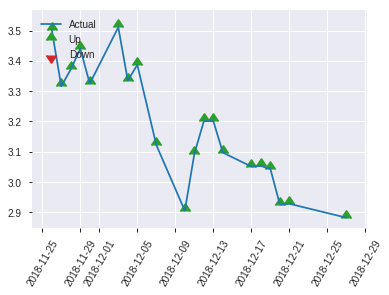


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25393449506990784
RMSE: 0.5039191354472539
LogLoss: 0.7022426761988644
Mean Per-Class Error: 0.42831364829396323
AUC: 0.5415354330708662
pr_auc: 0.5129415368128023
Gini: 0.08307086614173231
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2329598367214203: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    127  1        (127.0/127.0)
1      0    120  0        (0.0/120.0)
Total  0    247  0.5142   (127.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.23296      0.653951  244
max f2                       0.23296      0.825309  244
max f0point5                 0.508642     0.55      93
max accuracy                 0.517168     0.574899  83
max precision                0.715535     1         0
max recall                   0.23296      1         244
max specificity              0.715535     1         0
max absolute_mcc             0.517168     0.148415  83
max min_per_class_accuracy   0.479142     0.55      120
max mean_per_class_accuracy  0.508642     0.571686  93

Gains/Lift Table: Avg response rate: 48.58 %, avg score: 48.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.703328           1.37222   1.37222            0.666667         0.709834  0.666667                    0.709834            0.0166667       0.0166667                  37.2222   37.2222
    2        0.0202429                   0.697186           0         0.823333           0                0.700313  0.4                         0.706025            0               0.0166667                  -100      -17.6667
    3        0.0323887                   0.689023           1.37222   1.02917            0.666667         0.693762  0.5                         0.701426            0.0166667       0.0333333                  37.2222   2.91667
    4        0.0404858                   0.674907           1.02917   1.02917            0.5              0.687108  0.5                         0.698563            0.00833333      0.0416667                  2.91667   2.91667
    5        0.0526316                   0.668198           0.686111  0.95               0.333333         0.670438  0.461538                    0.692072            0.00833333      0.05                       -31.3889  -5
    6        0.101215                    0.621554           1.02917   0.988              0.5              0.638857  0.48                        0.666529            0.05            0.1                        2.91667   -1.2
    7        0.149798                    0.594883           1.20069   1.05698            0.583333         0.608104  0.513514                    0.64758             0.0583333       0.158333                   20.0694   5.6982
    8        0.202429                    0.577046           1.26667   1.1115             0.615385         0.584379  0.54                        0.631148            0.0666667       0.225                      26.6667   11.15
    9        0.299595                    0.530644           1.37222   1.19606            0.666667         0.553371  0.581081                    0.605923            0.133333        0.358333                   37.2222   19.6059
    10       0.40081                     0.504751           0.988     1.14352            0.48             0.516685  0.555556                    0.583388            0.1             0.458333                   -1.2      14.3519
    11       0.502024                    0.477702           0.905667  1.09556            0.44             0.48857   0.532258                    0.564272            0.0916667       0.55                       -9.43333  9.55645
    12       0.59919                     0.460212           0.771875  1.04307            0.375            0.467977  0.506757                    0.548656            0.075           0.625                      -22.8125  4.30743
    13       0.700405                    0.42176            0.741     0.999422           0.36             0.439929  0.485549                    0.532944            0.075           0.7                        -25.9     -0.0578035
    14       0.797571                    0.391648           1.02917   1.00305            0.5              0.40672   0.48731                     0.517567            0.1             0.8                        2.91667   0.304569
    15       0.898785                    0.356053           0.988     1.00135            0.48             0.376079  0.486486                    0.501633            0.1             0.9                        -1.2      0.135135
    16       1                           0.23296            0.988     1                  0.48             0.308446  0.48583                     0.48208             0.

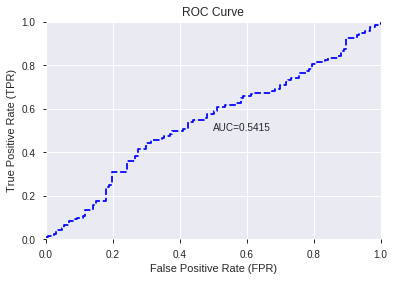

This function is available for GLM models only


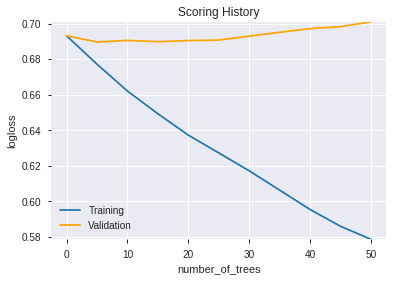

--2019-08-26 14:11:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

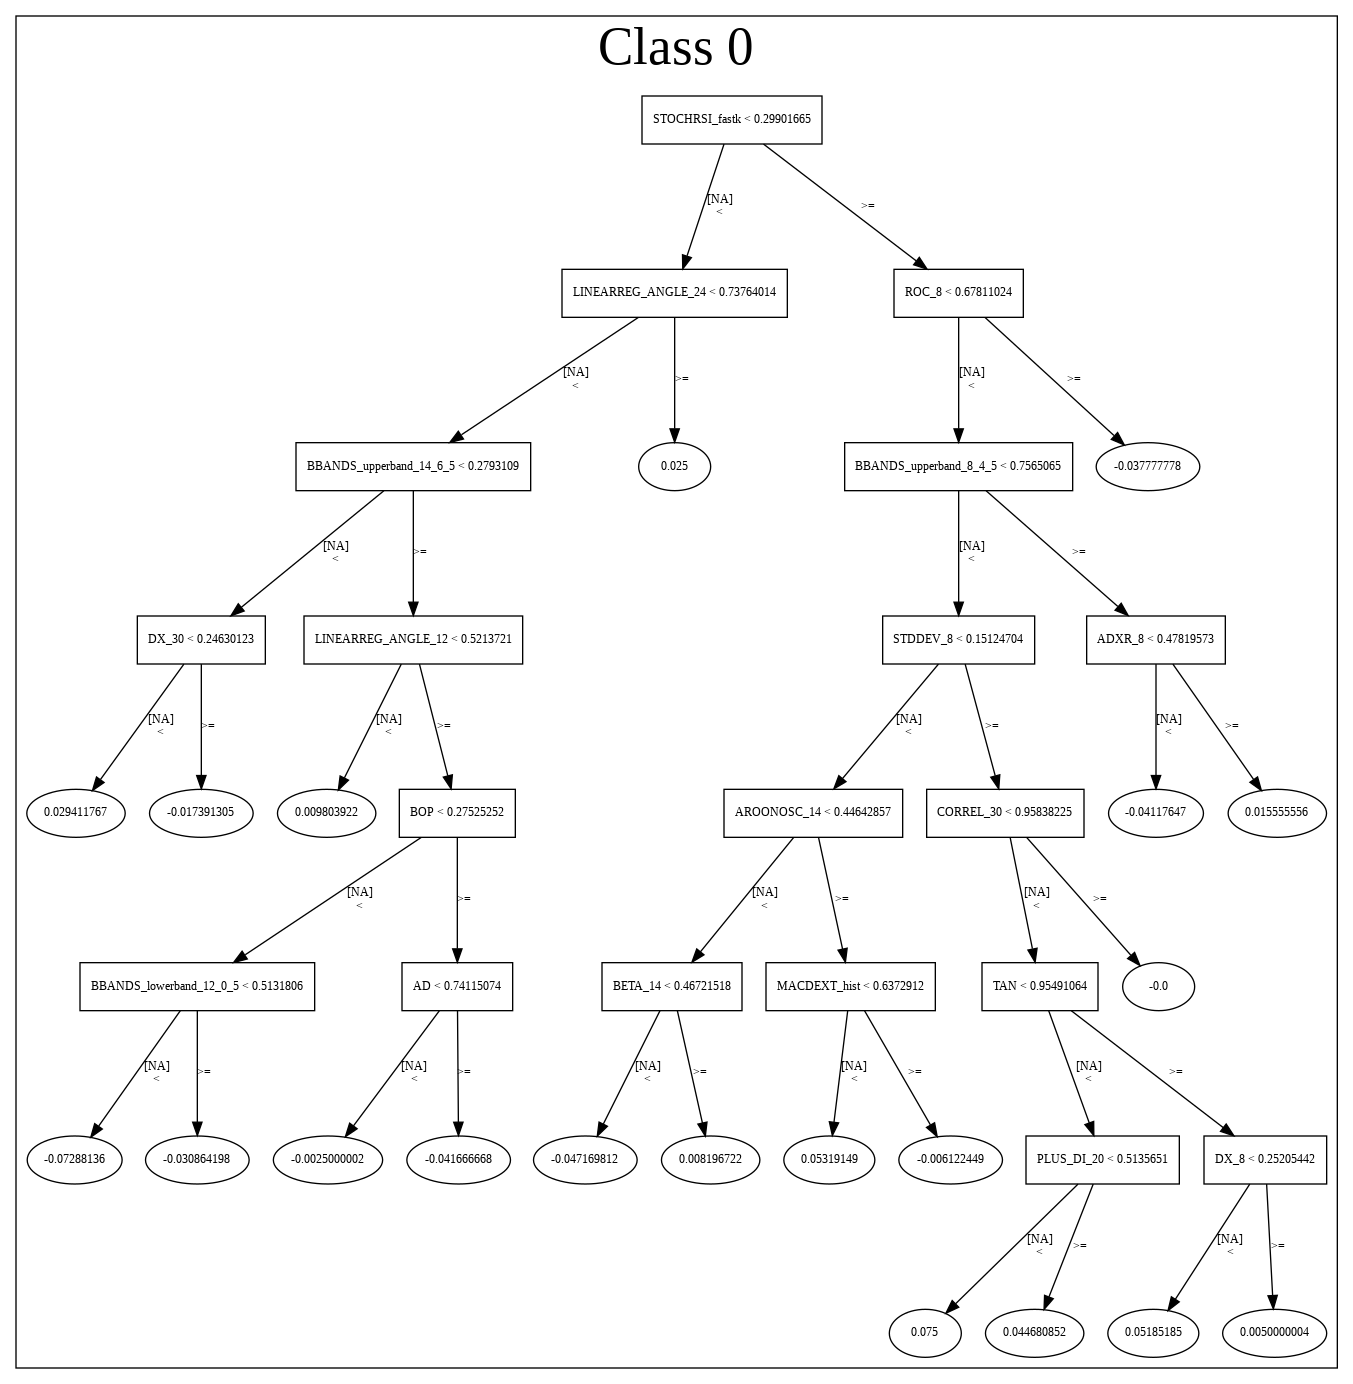

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_141142_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_141142_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a2a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['VAR_30',
 'VAR_14',
 'VAR_24',
 'ATAN',
 'VAR_12',
 'VAR_20',
 'COSH',
 'TANH',
 'EXP',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'is_month_start',
 'CDLDOJI',
 'SINH',
 'CDLHANGINGMAN',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'is_month_end',
 'CDLHARAMICROSS',
 'CDLHAMMER']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [919] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190826_141203  0.538583  1.128846              0.481234  0.557136  0.310400
1  DeepLearning_grid_1_AutoML_20190826_141203_model_7  0.516929  1.366206              0.472441  0.593276  0.351977
2  DeepLearning_grid_1_AutoML_20190826_141203_model_9  0.513386  0.698713              0.500000  0.502767  0.252775
3  DeepLearning_grid_1_AutoML_20190826_141203_model_4  0.508333  1.152630              0.484252  0.595536  0.354664
4  DeepLearning_grid_1_AutoML_20190826_141203_model_8  0.505184  0.702449              0.492126  0.504589  0.254610
5  DeepLearning_grid_1_AutoML_20190826_141203_model_1  0.490682  2.053751              0.500000  0.632064  0.399506
6  DeepLearning_grid_1_AutoML_20190826_141203_model_2  0.481824  0.763023              0.500000  0.521833  0.272310
7  DeepLearning_grid_1_AutoML_20190826_141203_model_3  0.463058  0.869534              0.496063  0.526803  0.277521
8  DeepLearning_grid_1_AutoML_20190826_141203_model_5  0.444324  0.704366              0.500000  0.505492  0.255523
9  DeepLearning_grid_1_AutoML_20190826_141203_model_6  0.428281  0.708083              0.500000  0.507038  0.257088

variable  relative_importance  scaled_importance  percentage
0                  MACD_signal             1.000000           1.000000    0.001649
1               CDL3LINESTRIKE             0.999416           0.999416    0.001648
2                         CEIL             0.969618           0.969618    0.001599
3                         SINH             0.961891           0.961891    0.001586
4                       SMA_20             0.949814           0.949814    0.001566
...                        ...                  ...                ...         ...
1039  BBANDS_middleband_14_2_4             0.289162           0.289162    0.000477
1040  BBANDS_middleband_20_1_4             0.280467           0.280467    0.000463
1041            STOCHRSI_fastk             0.275382           0.275382    0.000454
1042  BBANDS_middleband_12_2_2             0.256605           0.256605    0.000423
1043                 MAVP_12_2             0.244236           0.244236    0.000403

[1044 rows x 4 columns]

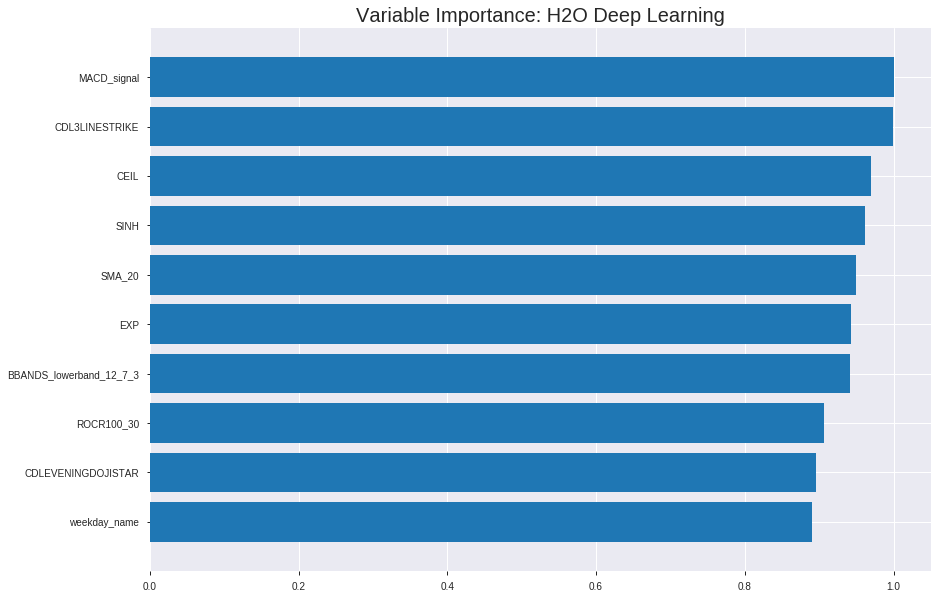

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190826_141203


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2556825632957829
RMSE: 0.5056506336353025
LogLoss: 0.7166088186886346
Mean Per-Class Error: 0.44104546368152897
AUC: 0.5857231117052488
pr_auc: 0.5728776232161209
Gini: 0.17144622341049764
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3909029897874137: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      116  747   0.8656   (747.0/863.0)
1      33   826   0.0384   (33.0/859.0)
Total  149  1573  0.453    (780.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390903     0.679276  309
max f2                       0.0175519    0.83301   397
max f0point5                 0.411076     0.578641  300
max accuracy                 0.597285     0.559233  202
max precision                0.997698     1         0
max recall                   0.0175519    1         397
max specificity              0.997698     1         0
max absolute_mcc             0.390903     0.170729  309
max min_per_class_accuracy   0.505694     0.518044  253
max mean_per_class_accuracy  0.588018     0.558955  207

Gains/Lift Table: Avg response rate: 49.88 %, avg score: 57.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010453                    0.953819           1.89329   1.89329            0.944444         0.981099  0.944444                    0.981099            0.0197905       0.0197905                  89.3287    89.3287
    2        0.0203252                   0.893917           1.17921   1.54645            0.588235         0.911664  0.771429                    0.947374            0.0116414       0.0314319                  17.921     54.6449
    3        0.0301974                   0.879476           1.17921   1.42639            0.588235         0.88602   0.711538                    0.927316            0.0116414       0.0430733                  17.921     42.639
    4        0.0400697                   0.866162           1.17921   1.36549            0.588235         0.871694  0.681159                    0.913612            0.0116414       0.0547148                  17.921     36.5491
    5        0.0505226                   0.857937           0.779589  1.24427            0.388889         0.862122  0.62069                     0.902959            0.00814901      0.0628638                  -22.0411   24.427
    6        0.100465                    0.804707           1.09557   1.17035            0.546512         0.82344   0.583815                    0.863429            0.0547148       0.117579                   9.55681    17.0349
    7        0.150407                    0.7701             1.11888   1.15326            0.55814          0.788917  0.57529                     0.838687            0.0558789       0.173458                   11.8878    15.3258
    8        0.200348                    0.726408           1.21212   1.16793            0.604651         0.750246  0.582609                    0.816641            0.0605355       0.233993                   21.2118    16.793
    9        0.300232                    0.650785           1.17715   1.171              0.587209         0.686045  0.584139                    0.773193            0.117579        0.351572                   17.7153    17.0999
    10       0.400116                    0.563073           1.04895   1.14053            0.523256         0.6099    0.56894                     0.732429            0.104773        0.456345                   4.89482    14.053
    11       0.836818                    0.503711           0.991665  1.06284            0.494681         0.507661  0.530187                    0.615132            0.433062        0.889406                   -0.833478  6.28436
    12       0.899535                    0.4098             0.983767  1.05733            0.490741         0.462104  0.527437                    0.604462            0.0616997       0.951106                   -1.62333   5.73302
    13       1                           0.00499974         0.48668   1                  0.242775         0.273306  0.498839                    0.571193            0.0488941       1                          -51.332    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2819479173812106
RMSE: 0.5309876810070179
LogLoss: 0.7811839883101382
Mean Per-Class Error: 0.4612873134328358
AUC: 0.5250033315565032
pr_auc: 0.5679544797051944
Gini: 0.0500066631130065
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06115589871246101: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    223  0.9955   (223.0/224.0)
1      0    268  0        (0.0/268.0)
Total  1    491  0.4533   (223.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0611559    0.706192   398
max f2                       0.0611559    0.857326   398
max f0point5                 0.405679     0.604685   363
max accuracy                 0.499897     0.556911   323
max precision                0.92241      1          0
max recall                   0.0611559    1          398
max specificity              0.92241      1          0
max absolute_mcc             0.802294     0.0916676  87
max min_per_class_accuracy   0.681745     0.504464   194
max mean_per_class_accuracy  0.802294     0.538713   87

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 65.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.911119           1.10149   1.10149            0.6              0.917728  0.6                         0.917728            0.011194        0.011194                   10.1493   10.1493
    2        0.0203252                   0.891933           1.10149   1.10149            0.6              0.900344  0.6                         0.909036            0.011194        0.0223881                  10.1493   10.1493
    3        0.0304878                   0.877413           1.83582   1.34627            1                0.885953  0.733333                    0.901342            0.0186567       0.0410448                  83.5821   34.6269
    4        0.0406504                   0.861414           1.10149   1.28507            0.6              0.869702  0.7                         0.893432            0.011194        0.0522388                  10.1493   28.5075
    5        0.050813                    0.856627           0.734328  1.17493            0.4              0.860131  0.64                        0.886772            0.00746269      0.0597015                  -26.5672  17.4925
    6        0.101626                    0.836818           0.881194  1.02806            0.48             0.844666  0.56                        0.865719            0.0447761       0.104478                   -11.8806  2.80597
    7        0.150407                    0.82108            1.14739   1.06676            0.625            0.828542  0.581081                    0.853661            0.0559701       0.160448                   14.7388   6.67608
    8        0.20122                     0.808369           1.24836   1.11262            0.68             0.814788  0.606061                    0.843845            0.0634328       0.223881                   24.8358   11.2619
    9        0.300813                    0.782125           0.899178  1.04195            0.489796         0.796779  0.567568                    0.828262            0.0895522       0.313433                   -10.0822  4.19524
    10       0.400407                    0.723601           1.04904   1.04372            0.571429         0.753359  0.568528                    0.809631            0.104478        0.41791                    4.90405   4.37154
    11       0.5                         0.682436           0.861712  1.00746            0.469388         0.704662  0.54878                     0.788723            0.0858209       0.503731                   -13.8288  0.746269
    12       0.599593                    0.641013           1.01157   1.00815            0.55102          0.659052  0.549153                    0.767184            0.100746        0.604478                   1.15748   0.814571
    13       0.699187                    0.606356           1.08651   1.01931            0.591837         0.624329  0.555233                    0.746836            0.108209        0.712687                   8.65062   1.93075
    14       0.79878                     0.541427           1.04904   1.02301            0.571429         0.575646  0.557252                    0.725491            0.104478        0.817164                   4.90405   2.30147
    15       0.898374                    0.428701           0.974109  1.01759            0.530612         0.484271  0.554299                    0.69875             0.0970149       0.914179                   -2.5891   1.7593
    16       1                           0.0279924          0.844478  1                  0.46             0.274742  0.544715                    0.65566         


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:12:03  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:12:03  0.394 sec   7935 obs/sec      1         1             1722       0.54943          0.969221            -0.207498      0.529544        0.511895           1.00233          0.496516                         0.587656           1.18391               -0.392494        0.519423          0.563125             0.734328           0.455285
    2019-08-26 14:12:05  1.654 sec   12551 obs/sec     10        10            17220      0.505651         0.716609            -0.0227358     0.585723        0.572878           1.89329          0.452962                         0.530988           0.781184              -0.136884        0.525003          0.567954             1.10149            0.453252

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ----------------------
MACD_signal               1.0                    1.0                  0.001649139108964629
CDL3LINESTRIKE            0.9994162917137146     0.9994162917137146   0.001648176492801489
CEIL                      0.9696182012557983     0.9696182012557983   0.0015990352964548734
SINH                      0.9618914723396301     0.9618914723396301   0.0015862928456148527
SMA_20                    0.9498144388198853     0.9498144388198853   0.0015663761373171645
---                       ---                    ---                  ---
BBANDS_middleband_14_2_4  0.28916221857070923    0.28916221857070923  0.0004768687234799347
BBANDS_middleband_20_1_4  0.28046661615371704    0.28046661615371704  0.0004625284654580655
STOCHRSI_fastk            0.27538231015205383    0.27538231015205383  0.0004541437375887791
BBANDS_middleband_12_2_2  0.25660473108291626    0.25660473108291626  0.00042317689757418874
MAVP_12_2                 0.24423585832118988    0.24423585832118988  0.00040277890576901845


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5587044534412956)

('F1', 0.655367231638418)

('auc', 0.5385826771653544)

('logloss', 1.1288458316872882)

('mean_per_class_error', 0.45095144356955386)

('rmse', 0.5571356405675769)

('mse', 0.3104001219906443)

deeplearning prediction progress: |███████████████████████████████████████| 100%


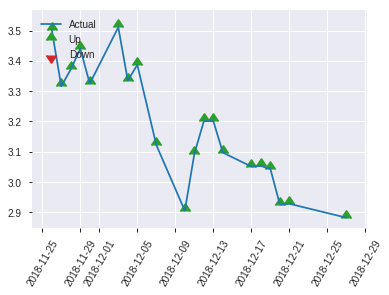


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3104001219906443
RMSE: 0.5571356405675769
LogLoss: 1.1288458316872882
Mean Per-Class Error: 0.45095144356955386
AUC: 0.5385826771653544
pr_auc: 0.5255278419843811
Gini: 0.0771653543307087
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2786000309886674: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    118  0.9291   (118.0/127.0)
1      4    116  0.0333   (4.0/120.0)
Total  13   234  0.4939   (122.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.2786       0.655367  232
max f2                       0.129295     0.825309  245
max f0point5                 0.2786       0.549242  232
max accuracy                 0.89039      0.558704  37
max precision                0.95331      0.714286  12
max recall                   0.129295     1         245
max specificity              1            0.984252  0
max absolute_mcc             0.89039      0.134457  37
max min_per_class_accuracy   0.650629     0.508333  121
max mean_per_class_accuracy  0.89039      0.549049  37

Gains/Lift Table: Avg response rate: 48.58 %, avg score: 63.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.99922            0         0                  0                0.999976  0                           0.999976            0               0                          -100      -100
    2        0.0202429                   0.995676           1.02917   0.411667           0.5              0.99838   0.2                         0.999337            0.00833333      0.00833333                 2.91667   -58.8333
    3        0.0323887                   0.981693           2.05833   1.02917            1                0.992036  0.5                         0.996599            0.025           0.0333333                  105.833   2.91667
    4        0.0404858                   0.972668           2.05833   1.235              1                0.974279  0.6                         0.992135            0.0166667       0.05                       105.833   23.5
    5        0.0526316                   0.957017           2.05833   1.425              1                0.963432  0.692308                    0.985512            0.025           0.075                      105.833   42.5
    6        0.101215                    0.90948            1.20069   1.31733            0.583333         0.931468  0.64                        0.959571            0.0583333       0.133333                   20.0694   31.7333
    7        0.149798                    0.891073           1.20069   1.2795             0.583333         0.900116  0.621622                    0.940288            0.0583333       0.191667                   20.0694   27.9505
    8        0.202429                    0.879387           1.10833   1.235              0.538462         0.885533  0.6                         0.926052            0.0583333       0.25                       10.8333   23.5
    9        0.299595                    0.806124           0.771875  1.0848             0.375            0.853254  0.527027                    0.902442            0.075           0.325                      -22.8125  8.47973
    10       0.40081                     0.728545           1.07033   1.08114            0.52             0.77378   0.525253                    0.869951            0.108333        0.433333                   7.03333   8.11448
    11       0.502024                    0.64494            0.741     1.01257            0.36             0.690218  0.491935                    0.833715            0.075           0.508333                   -25.9     1.25672
    12       0.59919                     0.56906            1.20069   1.04307            0.583333         0.60974   0.506757                    0.797394            0.116667        0.625                      20.0694   4.30743
    13       0.700405                    0.465443           0.905667  1.02322            0.44             0.513413  0.49711                     0.756357            0.0916667       0.716667                   -9.43333  2.32177
    14       0.797571                    0.380977           0.943403  1.01349            0.458333         0.415329  0.492386                    0.71481             0.0916667       0.808333                   -5.65972  1.34941
    15       0.898785                    0.321443           1.07033   1.01989            0.52             0.352697  0.495495                    0.674032            0.108333        0.916667                   7.03333   1.98949
    16       1                           0.129295           0.823333  1                  0.4              0.256123  0.48583                     0.631733            0.083333

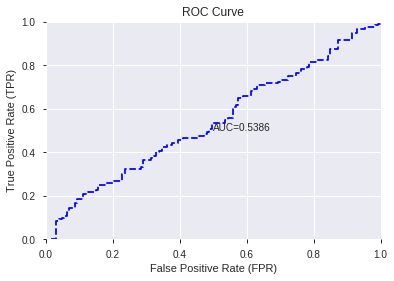

This function is available for GLM models only


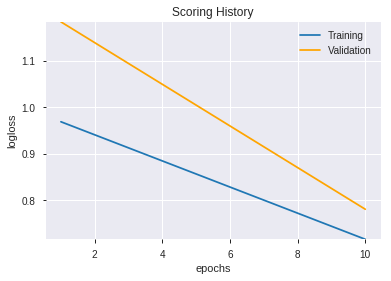

--2019-08-26 14:45:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.36
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.36|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


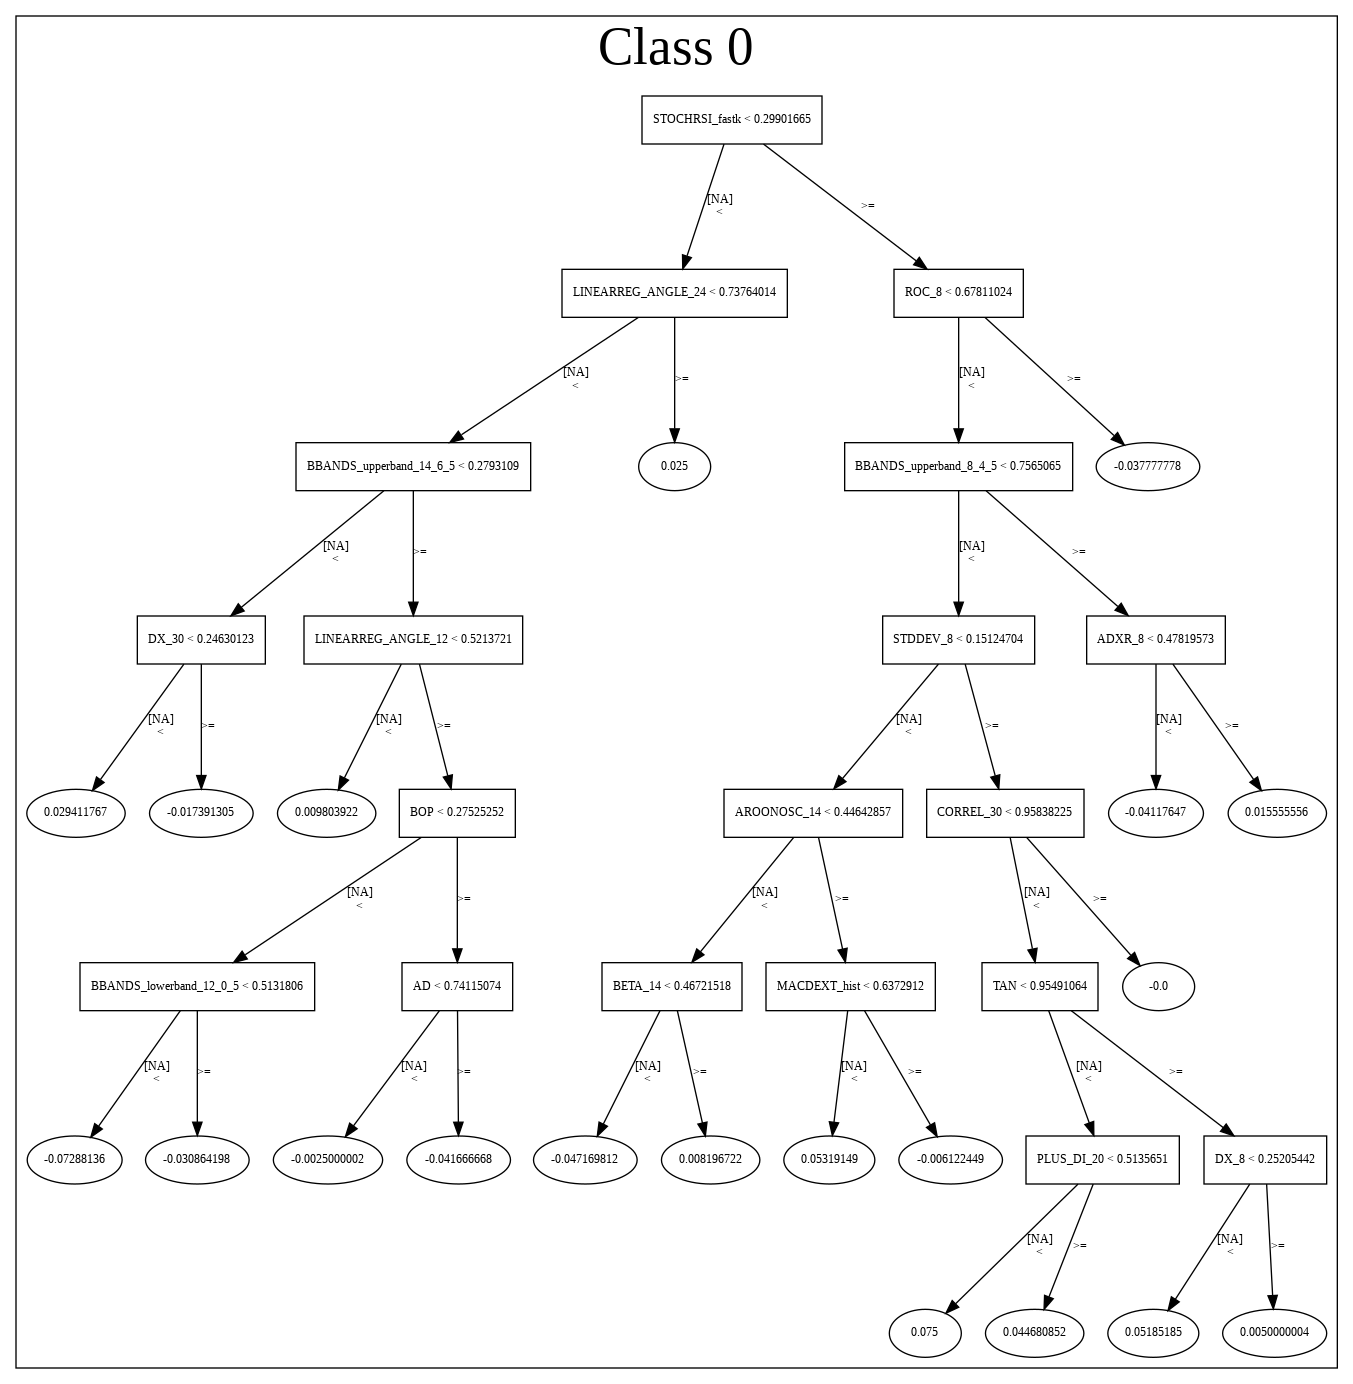

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190826_141203',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190826_141203',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a2a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_74_sid_a2a1'

['MACD_signal',
 'CDL3LINESTRIKE',
 'CEIL',
 'SINH',
 'SMA_20',
 'EXP',
 'BBANDS_lowerband_12_7_3',
 'ROCR100_30',
 'CDLEVENINGDOJISTAR',
 'weekday_name',
 'RSI_8',
 'BBANDS_middleband_20_6_3',
 'BBANDS_middleband_8_2_4',
 'BBANDS_upperband_30_5_5',
 'BBANDS_middleband_8_0_4',
 'CCI_12',
 'MIN_12',
 'days_in_month',
 'KAMA_24',
 'BBANDS_upperband_30_0_4',
 'BBANDS_middleband_24_7_5',
 'BBANDS_middleband_12_1_2',
 'BBANDS_upperband_24_1_3',
 'LINEARREG_INTERCEPT_14',
 'BBANDS_lowerband_14_1_3',
 'BBANDS_lowerband_20_5_5',
 'BBANDS_lowerband_8_2_4',
 'EMA_20',
 'BBANDS_upperband_12_2_5',
 'BBANDS_upperband_8_3_3',
 'SAR_0.12',
 'SAREXT',
 'DX_12',
 'LINEARREG_INTERCEPT_12',
 'BBANDS_lowerband_30_6_5',
 'BBANDS_lowerband_12_1_3',
 'BBANDS_middleband_24_5_3',
 'CDLMORNINGSTAR',
 'BBANDS_upperband_14_1_3',
 'BBANDS_lowerband_20_7_5',
 'BBANDS_lowerband_14_1_2',
 'BBANDS_middleband_24_1_2',
 'BBANDS_lowerband_30_2_5',
 'BBANDS_upperband_30_1_2',
 'BBANDS_lowerband_20_6_4',
 'BBANDS_upperband

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_144550_model_1  0.51647  0.697846                   0.5  0.502129  0.252134

variable  relative_importance  scaled_importance    percentage
0           CDLSTALLEDPATTERN         8.358255e-03           1.000000  1.176736e-02
1            CDLSTICKSANDWICH         7.924605e-03           0.948117  1.115683e-02
2              CDLSPINNINGTOP         7.483958e-03           0.895397  1.053646e-02
3                      Volume         6.785528e-03           0.811836  9.553159e-03
4              STOCHRSI_fastk         6.658089e-03           0.796588  9.373740e-03
...                       ...                  ...                ...           ...
1039                  MA_24_2         1.140168e-06           0.000136  1.605211e-06
1040                  MA_12_1         1.035002e-06           0.000124  1.457151e-06
1041   LINEARREG_INTERCEPT_20         8.132687e-07           0.000097  1.144979e-06
1042  BBANDS_lowerband_12_1_4         5.540880e-07           0.000066  7.800854e-07
1043  BBANDS_upperband_20_1_3         2.893914e-07           0.000035  4.074262e-07

[1044 rows x 4 columns]

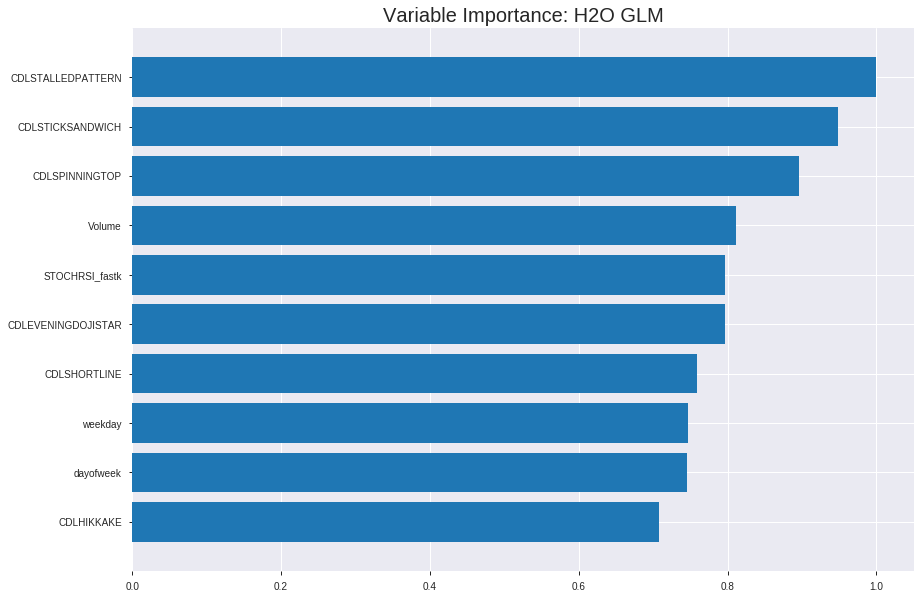

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_144550_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24667311590918756
RMSE: 0.496661973488194
LogLoss: 0.6864801058156601
Null degrees of freedom: 1721
Residual degrees of freedom: 677
Null deviance: 2387.1895983186078
Residual deviance: 2364.2374844291335
AIC: 4454.2374844291335
AUC: 0.5968721882811268
pr_auc: 0.5911615729288403
Gini: 0.19374437656225352
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4558312972283473: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      36   827   0.9583   (827.0/863.0)
1      13   846   0.0151   (13.0/859.0)
Total  49   1673  0.4878   (840.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.455831     0.668246  373
max f2                       0.439742     0.833172  396
max f0point5                 0.486258     0.576426  261
max accuracy                 0.502463     0.57259   182
max precision                0.574422     1         0
max recall                   0.439742     1         396
max specificity              0.574422     1         0
max absolute_mcc             0.514092     0.148071  124
max min_per_class_accuracy   0.499563     0.570104  197
max mean_per_class_accuracy  0.498987     0.572615  200

Gains/Lift Table: Avg response rate: 49.88 %, avg score: 49.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.551082           1.55918   1.55918            0.777778         0.559375  0.777778                    0.559375            0.016298        0.016298                   55.9177   55.9177
    2        0.0203252                   0.545182           1.53297   1.54645            0.764706         0.547726  0.771429                    0.553717            0.0151339       0.0314319                  53.2973   54.6449
    3        0.0301974                   0.539292           1.29713   1.46494            0.647059         0.542661  0.730769                    0.550103            0.0128056       0.0442375                  29.7131   46.4941
    4        0.0400697                   0.535285           1.29713   1.4236             0.647059         0.536644  0.710145                    0.546787            0.0128056       0.0570431                  29.7131   42.3597
    5        0.0505226                   0.533153           1.44781   1.42861            0.722222         0.53437   0.712644                    0.544218            0.0151339       0.0721769                  44.7808   42.8606
    6        0.100465                    0.525368           1.18881   1.3094             0.593023         0.529144  0.653179                    0.536724            0.0593714       0.131548                   18.8808   30.94
    7        0.150407                    0.521005           1.23543   1.28484            0.616279         0.523107  0.640927                    0.532203            0.0616997       0.193248                   23.5428   28.4838
    8        0.200348                    0.517108           1.23543   1.27252            0.616279         0.51907   0.634783                    0.528929            0.0616997       0.254948                   23.5428   27.2521
    9        0.300232                    0.510402           1.09557   1.21365            0.546512         0.513491  0.605416                    0.523793            0.10943         0.364377                   9.55681   21.3651
    10       0.400116                    0.504999           1.00233   1.1609             0.5              0.507843  0.5791                      0.519811            0.100116        0.464494                   0.232829  16.0897
    11       0.5                         0.499441           1.0606    1.14086            0.52907          0.502298  0.569106                    0.516313            0.105937        0.570431                   6.06032   14.0861
    12       0.599884                    0.493578           0.862469  1.09451            0.430233         0.496636  0.545983                    0.513037            0.0861467       0.656577                   -13.7531  9.45076
    13       0.699768                    0.487225           1.00233   1.08135            0.5              0.49057   0.539419                    0.50983             0.100116        0.756694                   0.232829  8.135
    14       0.799652                    0.480189           0.920743  1.06129            0.459302         0.483724  0.529412                    0.506569            0.0919674       0.848661                   -7.92566  6.12888
    15       0.899535                    0.471207           0.804194  1.03274            0.401163         0.4762    0.515171                    0.503197            0.080326        0.928987                   -19.5806  3.27411
    16       1                           0.420508           0.706844  1                  0.352601         0.459816  0.498839                    0.498839            0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2494445483031747
RMSE: 0.4994442394333673
LogLoss: 0.6920454817123933
Null degrees of freedom: 491
Residual degrees of freedom: -553
Null deviance: 682.2638942389361
Residual deviance: 680.9727540049951
AIC: 2770.9727540049953
AUC: 0.4968933235607676
pr_auc: 0.5378905282405769
Gini: -0.006213352878464806
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4611264783869037: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    222  0.9911   (222.0/224.0)
1      0    268  0        (0.0/268.0)
Total  2    490  0.4512   (222.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.461126     0.707124  397
max f2                       0.461126     0.857875  397
max f0point5                 0.4811       0.60305   382
max accuracy                 0.4811       0.552846  382
max precision                0.556682     0.625     15
max recall                   0.461126     1         397
max specificity              0.599289     0.995536  0
max absolute_mcc             0.589255     0.110832  4
max min_per_class_accuracy   0.514166     0.492537  197
max mean_per_class_accuracy  0.532042     0.514759  68

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 51.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.587574           0         0                  0                0.593061  0                           0.593061            0               0                          -100      -100
    2        0.0203252                   0.58079            1.46866   0.734328           0.8              0.584781  0.4                         0.588921            0.0149254       0.0149254                  46.8657   -26.5672
    3        0.0304878                   0.557788           1.83582   1.10149            1                0.571579  0.6                         0.58314             0.0186567       0.0335821                  83.5821   10.1493
    4        0.0406504                   0.552693           0.367164  0.91791            0.2              0.5555    0.5                         0.57623             0.00373134      0.0373134                  -63.2836  -8.20896
    5        0.050813                    0.549926           1.10149   0.954627           0.6              0.551091  0.52                        0.571202            0.011194        0.0485075                  10.1493   -4.53731
    6        0.101626                    0.537543           1.02806   0.991343           0.56             0.543199  0.54                        0.557201            0.0522388       0.100746                   2.80597   -0.865672
    7        0.150407                    0.532092           1.22388   1.06676            0.666667         0.534782  0.581081                    0.54993             0.0597015       0.160448                   22.3881   6.67608
    8        0.20122                     0.529295           1.02806   1.05699            0.56             0.530838  0.575758                    0.545109            0.0522388       0.212687                   2.80597   5.69878
    9        0.300813                    0.523353           0.824246  0.979931           0.44898          0.526422  0.533784                    0.538922            0.0820896       0.294776                   -17.5754  -2.00686
    10       0.400407                    0.518934           0.974109  0.978483           0.530612         0.52121   0.532995                    0.534516            0.0970149       0.391791                   -2.5891   -2.15168
    11       0.5                         0.514004           1.04904   0.992537           0.571429         0.51638   0.54065                     0.530904            0.104478        0.496269                   4.90405   -0.746269
    12       0.599593                    0.509267           0.861712  0.970807           0.469388         0.511758  0.528814                    0.527724            0.0858209       0.58209                    -13.8288  -2.9193
    13       0.699187                    0.504785           1.23637   1.00863            0.673469         0.506888  0.549419                    0.524756            0.123134        0.705224                   23.6369   0.863415
    14       0.79878                     0.499452           0.974109  1.00433            0.530612         0.502037  0.547074                    0.521923            0.0970149       0.802239                   -2.5891   0.43295
    15       0.898374                    0.490466           1.01157   1.00513            0.55102          0.495259  0.547511                    0.518967            0.100746        0.902985                   1.15748   0.513271
    16       1                           0.456282           0.954627  1                  0.52             0.480501  0.544715                    0.515058 


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 14:45:53  0.000 sec   2            2.8       1045          1.37296           1.38409
    2019-08-26 14:45:55  2.078 sec   4            2.1       1045          1.36954           1.3845
    2019-08-26 14:45:57  4.072 sec   6            1.5       1045          1.3656            1.3854
    2019-08-26 14:45:59  6.082 sec   8            1.1       1045          1.36107           1.38667
    2019-08-26 14:46:01  8.073 sec   10           0.8       1045          1.356             1.3885
    2019-08-26 14:46:03  10.186 sec  12           0.58      1045          1.35052           1.39123

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5546558704453441)

('F1', 0.6539509536784741)

('auc', 0.5164698162729658)

('logloss', 0.6978461038896197)

('mean_per_class_error', 0.4496062992125984)

('rmse', 0.5021291884928984)

('mse', 0.25213372193653677)

glm prediction progress: |████████████████████████████████████████████████| 100%


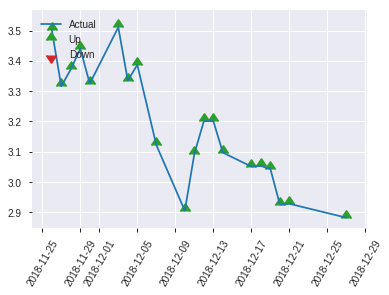


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25213372193653677
RMSE: 0.5021291884928984
LogLoss: 0.6978461038896197
Null degrees of freedom: 246
Residual degrees of freedom: -798
Null deviance: 342.38351957249984
Residual deviance: 344.735975321472
AIC: 2434.735975321472
AUC: 0.5164698162729658
pr_auc: 0.4936920983424177
Gini: 0.032939632545931685
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4575802449302674: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    127  1        (127.0/127.0)
1      0    120  0        (0.0/120.0)
Total  0    247  0.5142   (127.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45758      0.653951  246
max f2                       0.45758      0.825309  246
max f0point5                 0.45758      0.541516  246
max accuracy                 0.518412     0.554656  51
max precision                0.518412     0.596154  51
max recall                   0.45758      1         246
max specificity              0.740646     0.992126  0
max absolute_mcc             0.518412     0.113988  51
max min_per_class_accuracy   0.500583     0.516667  122
max mean_per_class_accuracy  0.508107     0.550394  85

Gains/Lift Table: Avg response rate: 48.58 %, avg score: 50.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.566657           0.686111  0.686111           0.333333         0.680508  0.333333                    0.680508            0.00833333      0.00833333                 -31.3889  -31.3889
    2        0.0202429                   0.55208            0         0.411667           0                0.555589  0.2                         0.63054             0               0.00833333                 -100      -58.8333
    3        0.0323887                   0.543384           1.37222   0.771875           0.666667         0.54693   0.375                       0.599186            0.0166667       0.025                      37.2222   -22.8125
    4        0.0404858                   0.542419           0         0.6175             0                0.542908  0.3                         0.587931            0               0.025                      -100      -38.25
    5        0.0526316                   0.538979           1.37222   0.791667           0.666667         0.541267  0.384615                    0.577162            0.0166667       0.0416667                  37.2222   -20.8333
    6        0.101215                    0.527157           1.20069   0.988              0.583333         0.533275  0.48                        0.556096            0.0583333       0.1                        20.0694   -1.2
    7        0.149798                    0.522143           1.54375   1.16824            0.75             0.524816  0.567568                    0.545951            0.075           0.175                      54.375    16.8243
    8        0.202429                    0.518582           1.26667   1.19383            0.615385         0.519972  0.58                        0.539197            0.0666667       0.241667                   26.6667   19.3833
    9        0.299595                    0.511773           0.857639  1.0848             0.416667         0.515031  0.527027                    0.531359            0.0833333       0.325                      -14.2361  8.47973
    10       0.40081                     0.505824           1.15267   1.10194            0.56             0.508348  0.535354                    0.525548            0.116667        0.441667                   15.2667   10.1936
    11       0.502024                    0.500531           0.741     1.02917            0.36             0.503196  0.5                         0.521042            0.075           0.516667                   -25.9     2.91667
    12       0.59919                     0.494817           0.943403  1.01526            0.458333         0.497482  0.493243                    0.517221            0.0916667       0.608333                   -5.65972  1.5259
    13       0.700405                    0.490565           1.07033   1.02322            0.52             0.492677  0.49711                     0.513674            0.108333        0.716667                   7.03333   2.32177
    14       0.797571                    0.48479            0.600347  0.971701           0.291667         0.48761   0.472081                    0.510499            0.0583333       0.775                      -39.9653  -2.82995
    15       0.898785                    0.476092           0.988     0.973536           0.48             0.480891  0.472973                    0.507165            0.1             0.875                      -1.2      -2.6464
    16       1                           0.45758            1.235     1                  0.6              0.46951   0.48583                     0.503354         

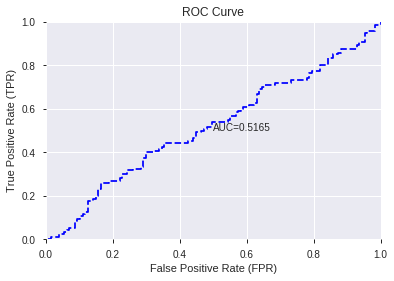

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


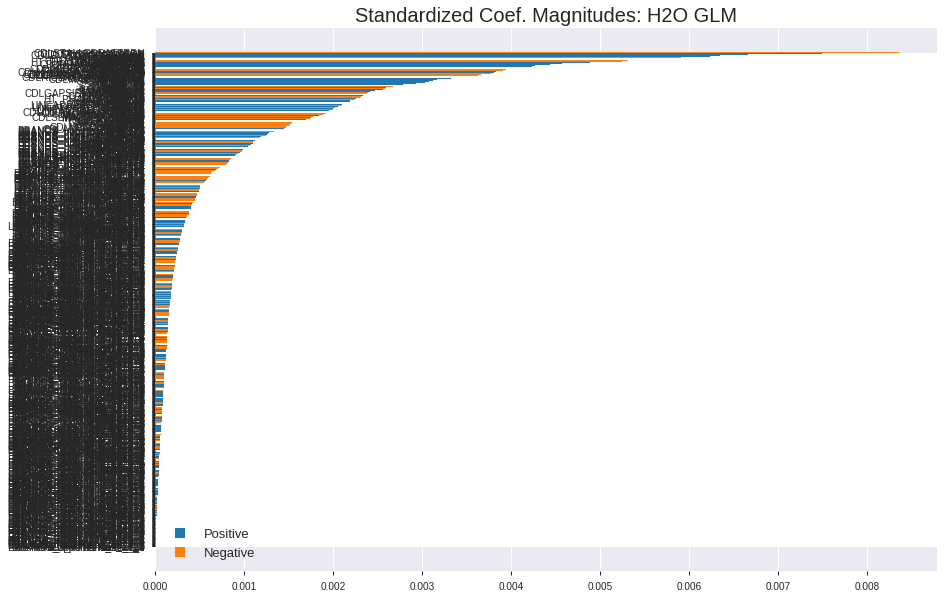

'log_likelihood'
--2019-08-26 14:46:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.18.208
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.18.208|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


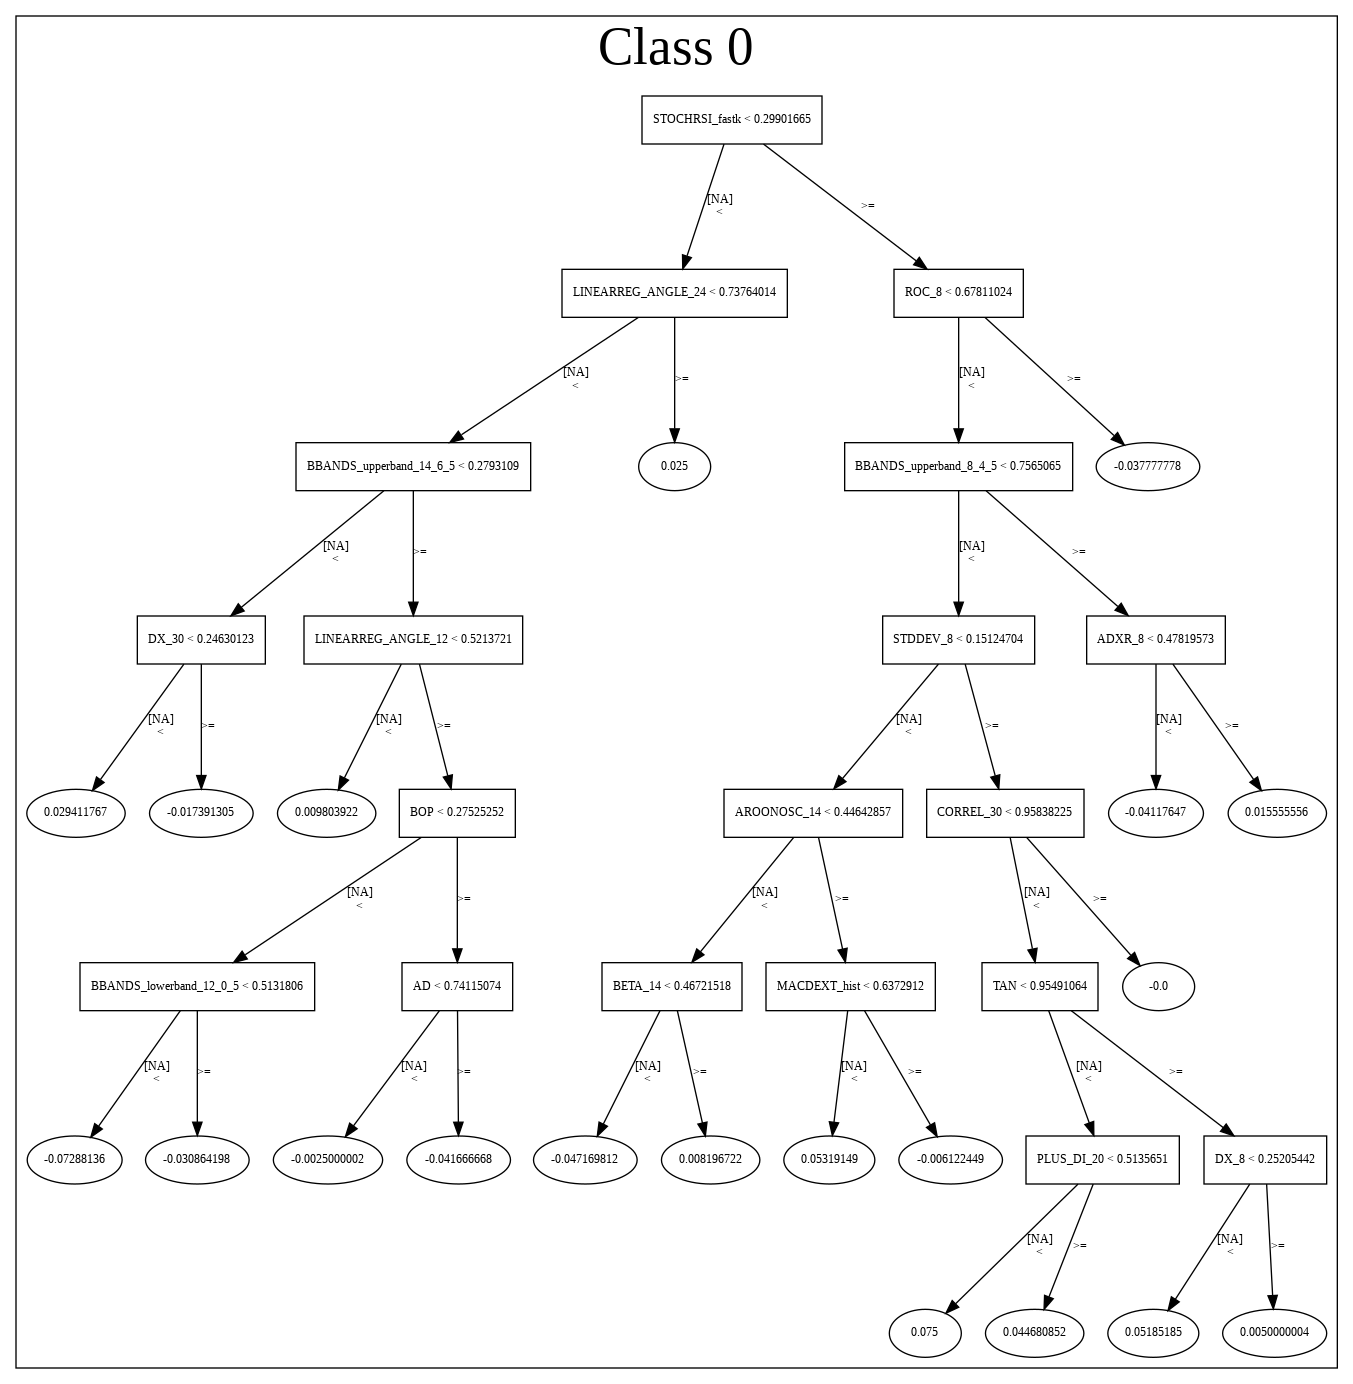

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_144550_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_144550_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a2a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLSTALLEDPATTERN',
 'CDLSTICKSANDWICH',
 'CDLSPINNINGTOP',
 'Volume',
 'STOCHRSI_fastk',
 'CDLEVENINGDOJISTAR',
 'CDLSHORTLINE',
 'weekday',
 'dayofweek',
 'CDLHIKKAKE',
 'HT_DCPERIOD',
 'VAR_8',
 'TANH',
 'CDLONNECK',
 'BETA_14',
 'is_month_start',
 'CDL2CROWS',
 'CDLHOMINGPIGEON',
 'aroonup_20',
 'HT_PHASOR_quadrature',
 'BOP',
 'CDLHIGHWAVE',
 'NATR_30',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'aroonup_24',
 'CDLHARAMICROSS',
 'AROONOSC_20',
 'CORREL_24',
 'BETA_12',
 'NATR_24',
 'CDLHANGINGMAN',
 'TAN',
 'CDLINVERTEDHAMMER',
 'CDLCOUNTERATTACK',
 'COS',
 'STDDEV_8',
 'BETA_24',
 'DX_8',
 'CDLXSIDEGAP3METHODS',
 'NATR_20',
 'BETA_30',
 'aroondown_8',
 'CDLUNIQUE3RIVER',
 'CDLUPSIDEGAP2CROWS',
 'CDLDARKCLOUDCOVER',
 'CDLIDENTICAL3CROWS',
 'CDL3WHITESOLDIERS',
 'CDL3LINESTRIKE',
 'AD',
 'CDLRISEFALL3METHODS',
 'WILLR_20',
 'CDLENGULFING',
 'STOCH_slowd',
 'CDLMATCHINGLOW',
 'CORREL_14',
 'is_month_end',
 'STOCHF_fastk',
 'CDL3INSIDE',
 'aroonup_30',
 'NATR_14',
 'MFI_20',
 'CCI_20',
 '

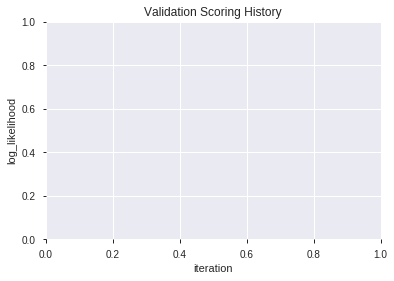

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190826_144629  0.557087  0.692104              0.488189  0.499405  0.249405
1  XGBoost_grid_1_AutoML_20190826_144629_model_3  0.541601  0.697817              0.496063  0.501951  0.251955
2               XGBoost_3_AutoML_20190826_144629  0.540551  0.693299              0.492126  0.499897  0.249897
3  XGBoost_grid_1_AutoML_20190826_144629_model_2  0.532283  0.695392              0.484252  0.501070  0.251071
4               XGBoost_1_AutoML_20190826_144629  0.527100  0.708026              0.496063  0.506737  0.256783
5  XGBoost_grid_1_AutoML_20190826_144629_model_4  0.525000  0.697216              0.492126  0.501955  0.251959
6  XGBoost_grid_1_AutoML_20190826_144629_model_6  0.514436  0.704018              0.492126  0.505014  0.255039
7  XGBoost_grid_1_AutoML_20190826_144629_model_7  0.490354  0.715328              0.496063  0.510302  0.260408
8  XGBoost_grid_1_AutoML_20190826_144629_model_1  0.489993  0.708141              0.496063  0.506789  0.256835
9  XGBoost_grid_1_AutoML_20190826_144629_model_5  0.474081  0.756395              0.500000  0.527451  0.278205

variable  relative_importance  scaled_importance  percentage
0              DX_8           114.508034           1.000000    0.018279
1            Volume            96.199959           0.840115    0.015357
2           BETA_30            91.806877           0.801751    0.014655
3           BETA_14            89.171150           0.778733    0.014235
4    STOCHRSI_fastk            80.407341           0.702198    0.012836
..              ...                  ...                ...         ...
281          ROCR_8             2.947226           0.025738    0.000470
282      aroonup_14             2.926659           0.025559    0.000467
283             day             2.491962           0.021762    0.000398
284         NATR_14             2.175432           0.018998    0.000347
285         MACDEXT             2.101714           0.018354    0.000336

[286 rows x 4 columns]

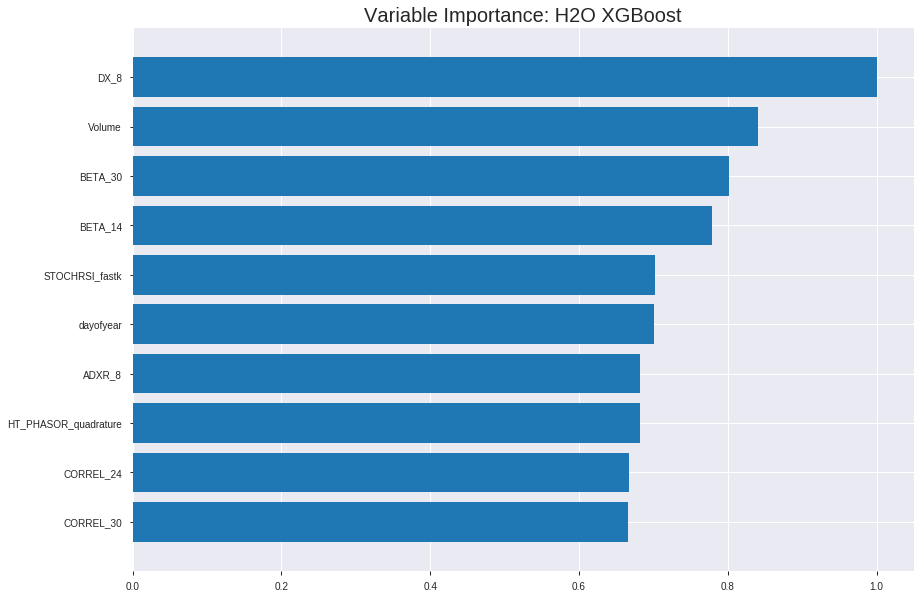

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190826_144629


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17063045704832722
RMSE: 0.41307439650543243
LogLoss: 0.5287524116990812
Mean Per-Class Error: 0.13471429901108434
AUC: 0.9379078046233933
pr_auc: 0.9354613667407886
Gini: 0.8758156092467866
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4878673851490021: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      718  145  0.168    (145.0/863.0)
1      90   769  0.1048   (90.0/859.0)
Total  808  914  0.1365   (235.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.487867     0.867456  214
max f2                       0.424202     0.910178  265
max f0point5                 0.548222     0.879723  163
max accuracy                 0.508517     0.865273  196
max precision                0.799161     1         0
max recall                   0.337216     1         339
max specificity              0.799161     1         0
max absolute_mcc             0.508517     0.730967  196
max min_per_class_accuracy   0.501543     0.864426  202
max mean_per_class_accuracy  0.499151     0.865286  204

Gains/Lift Table: Avg response rate: 49.88 %, avg score: 49.96 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.751027           2.00466    2.00466            1                0.768143  1                           0.768143            0.0209546       0.0209546                  100.466   100.466
    2        0.0203252                   0.734318           2.00466    2.00466            1                0.742933  1                           0.755898            0.0197905       0.0407451                  100.466   100.466
    3        0.0301974                   0.724173           2.00466    2.00466            1                0.729607  1                           0.747303            0.0197905       0.0605355                  100.466   100.466
    4        0.0400697                   0.715344           1.88674    1.9756             0.941176         0.720042  0.985507                    0.740587            0.0186263       0.0791618                  88.6736   97.5604
    5        0.0505226                   0.710557           2.00466    1.98161            1                0.71303   0.988506                    0.734885            0.0209546       0.100116                   100.466   98.1615
    6        0.100465                    0.672601           2.00466    1.99307            1                0.689344  0.99422                     0.712246            0.100116        0.200233                   100.466   99.3069
    7        0.150407                    0.648131           1.95804    1.98144            0.976744         0.659818  0.988417                    0.694838            0.0977881       0.298021                   95.8037   98.1437
    8        0.200348                    0.622639           1.95804    1.9756             0.976744         0.635506  0.985507                    0.680048            0.0977881       0.395809                   95.8037   97.5604
    9        0.300232                    0.582243           1.79487    1.91547            0.895349         0.601078  0.955513                    0.653776            0.179278        0.575087                   79.4867   91.5475
    10       0.400116                    0.537174           1.6317     1.84463            0.813953         0.560233  0.920174                    0.630424            0.16298         0.738068                   63.1697   84.4633
    11       0.5                         0.501095           1.28205    1.73225            0.639535         0.51973   0.864111                    0.608311            0.128056        0.866123                   28.2048   73.2247
    12       0.599884                    0.453837           0.699299   1.56026            0.348837         0.478154  0.778316                    0.586639            0.0698487       0.935972                   -30.0701  56.0255
    13       0.699768                    0.414249           0.419579   1.39744            0.209302         0.433771  0.697095                    0.564819            0.0419092       0.977881                   -58.0421  39.7437
    14       0.799652                    0.374765           0.18648    1.24618            0.0930233        0.395479  0.621641                    0.543667            0.0186263       0.996508                   -81.352   24.6177
    15       0.899535                    0.329608           0.0349649  1.11168            0.0174419        0.351047  0.554551                    0.522278            0.00349243      1                          -96.5035  11.1685
    16       1                           0.218005           0          1                  0                0.296796  0.498839                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2567244357324683
RMSE: 0.506679815793434
LogLoss: 0.707501748604884
Mean Per-Class Error: 0.4861740405117271
AUC: 0.5000333155650319
pr_auc: 0.5503830194660212
Gini: 6.663113006388777e-05
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.194219708442688: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    268  0        (0.0/268.0)
Total  0    492  0.4553   (224.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.19422      0.705263   399
max f2                       0.19422      0.856777   399
max f0point5                 0.314648     0.60219    388
max accuracy                 0.314648     0.550813   388
max precision                0.691582     0.888889   6
max recall                   0.19422      1          399
max specificity              0.729708     0.995536   0
max absolute_mcc             0.691582     0.0943406  6
max min_per_class_accuracy   0.530487     0.511194   196
max mean_per_class_accuracy  0.688034     0.513826   10

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 52.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101626                   0.698427           1.46866   1.46866            0.8              0.710957  0.8                         0.710957            0.0149254       0.0149254                  46.8657    46.8657
    2        0.0203252                   0.689797           1.46866   1.46866            0.8              0.694057  0.8                         0.702507            0.0149254       0.0298507                  46.8657    46.8657
    3        0.0304878                   0.686096           1.10149   1.34627            0.6              0.68835   0.733333                    0.697788            0.011194        0.0410448                  10.1493    34.6269
    4        0.0406504                   0.677967           1.10149   1.28507            0.6              0.682714  0.7                         0.694019            0.011194        0.0522388                  10.1493    28.5075
    5        0.050813                    0.670896           0.367164  1.10149            0.2              0.674762  0.6                         0.690168            0.00373134      0.0559701                  -63.2836   10.1493
    6        0.101626                    0.649605           0.807761  0.954627           0.44             0.656902  0.52                        0.673535            0.0410448       0.0970149                  -19.2239   -4.53731
    7        0.150407                    0.628818           0.91791   0.942719           0.5              0.638502  0.513514                    0.662173            0.0447761       0.141791                   -8.20896   -5.72812
    8        0.20122                     0.606985           0.954627  0.945726           0.52             0.617583  0.515152                    0.650913            0.0485075       0.190299                   -4.53731   -5.42741
    9        0.300813                    0.58173            1.08651   0.992336           0.591837         0.595068  0.540541                    0.632424            0.108209        0.298507                   8.65062    -0.766438
    10       0.400407                    0.556528           1.04904   1.00644            0.571429         0.568381  0.548223                    0.616494            0.104478        0.402985                   4.90405    0.643988
    11       0.5                         0.530168           1.08651   1.02239            0.591837         0.542891  0.556911                    0.601834            0.108209        0.511194                   8.65062    2.23881
    12       0.599593                    0.508518           0.861712  0.995699           0.469388         0.518573  0.542373                    0.588004            0.0858209       0.597015                   -13.8288   -0.430053
    13       0.699187                    0.484424           1.08651   1.00863            0.591837         0.49662   0.549419                    0.574987            0.108209        0.705224                   8.65062    0.863415
    14       0.79878                     0.447213           1.04904   1.01367            0.571429         0.467943  0.552163                    0.56164             0.104478        0.809701                   4.90405    1.36721
    15       0.898374                    0.408029           0.899178  1.00098            0.489796         0.428779  0.545249                    0.546911            0.0895522       0.899254                   -10.0822   0.0979267
    16       1                           0.19422            0.991343  1                  0.54             0.344988  0.544715         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:46:32  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.501161                         0.5                0.693147              0.5               0                    1                  0.455285
    2019-08-26 14:46:33  0.732 sec   5                  0.488756         0.670865            0.761539        0.754842           1.89915          0.313589                         0.499672           0.69249               0.50234           0.54804              0.734328           0.455285
    2019-08-26 14:46:34  1.301 sec   10                 0.477884         0.649668            0.821619        0.814868           1.89329          0.25842                          0.500777           0.694733              0.500192          0.533727             1.10149            0.455285
    2019-08-26 14:46:34  1.923 sec   15                 0.468009         0.630658            0.847331        0.846669           2.00466          0.235192                         0.501358           0.695926              0.503456          0.539044             1.10149            0.453252
    2019-08-26 14:46:35  2.470 sec   20                 0.459386         0.614238            0.871022        0.864982           2.00466          0.212544                         0.501659           0.696611              0.511336          0.542573             1.10149            0.455285
    2019-08-26 14:46:35  3.077 sec   25                 0.450887         0.598183            0.884472        0.883097           2.00466          0.208479                         0.50209            0.697492              0.504739          0.550319             1.83582            0.441057
    2019-08-26 14:46:36  3.674 sec   30                 0.441912         0.581389            0.898077        0.897211           2.00466          0.186411                         0.502672           0.698763              0.505455          0.553759             1.46866            0.455285
    2019-08-26 14:46:37  4.235 sec   35                 0.433942         0.566673            0.911334        0.910392           2.00466          0.180023                         0.50376            0.701239              0.507638          0.542044             1.10149            0.455285
    2019-08-26 14:46:37  4.841 sec   40                 0.426363         0.552781            0.921728        0.920214           2.00466          0.167247                         0.504563           0.702927              0.506963          0.549648             1.10149            0.455285
    2019-08-26 14:46:38  5.424 sec   45                 0.419911         0.541145            0.931483        0.927698           1.89329          0.146922                         0.505305           0.704405              0.502857          0.556677             1.46866            0.453252
    2019-08-26 14:46:38  6.059 sec   50                 0.413074         0.528752            0.937908        0.935461           2.00466          0.136469                         0.50668            0.707502              0.500033          0.550383             1.46866            0.455285

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ----------------------
DX_8            114.5080337524414      1.0                  0.01827934274961598
Volume          96.19995880126953      0.8401153670077621   0.015356756742754305
BETA_30         91.80687713623047      0.8017505333705293   0.014655472799167329
BETA_14         89.17115020751953      0.7787326992296585   0.014234721919552539
STOCHRSI_fastk  80.40734100341797      0.7021982507991813   0.012835722504539038
---             ---                    ---                  ---
ROCR_8          2.9472262859344482     0.02573816167611568  0.00047047667902274905
aroonup_14      2.9266586303710938     0.02555854409917064  0.0004671933877699151
day             2.491962432861328      0.02176233711469347  0.0003978012191521708
NATR_14         2.1754322052001953     0.01899807492898998  0.0003472723232098941
MACDEXT         2.1017141342163086     0.01835429415162321  0.0003355044337247927


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5546558704453441)

('F1', 0.6593406593406593)

('auc', 0.5570866141732284)

('logloss', 0.6921043081702875)

('mean_per_class_error', 0.4374343832020997)

('rmse', 0.4994048641762697)

('mse', 0.24940521836291843)

xgboost prediction progress: |████████████████████████████████████████████| 100%


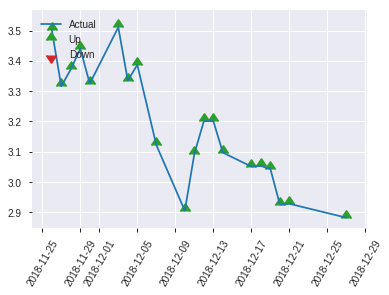


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24940521836291843
RMSE: 0.4994048641762697
LogLoss: 0.6921043081702875
Mean Per-Class Error: 0.4374343832020997
AUC: 0.5570866141732284
pr_auc: 0.5188707274170666
Gini: 0.11417322834645671
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2869548201560974: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    124  0.9764   (124.0/127.0)
1      0    120  0        (0.0/120.0)
Total  3    244  0.502    (124.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.286955     0.659341  243
max f2                       0.286955     0.828729  243
max f0point5                 0.398845     0.568694  191
max accuracy                 0.548308     0.554656  59
max precision                0.619517     0.625     15
max recall                   0.286955     1         243
max specificity              0.716189     0.992126  0
max absolute_mcc             0.398845     0.150323  191
max min_per_class_accuracy   0.477302     0.541667  122
max mean_per_class_accuracy  0.398845     0.562566  191

Gains/Lift Table: Avg response rate: 48.58 %, avg score: 47.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.676605           0         0                  0                0.69573   0                           0.69573             0               0                          -100      -100
    2        0.0202429                   0.66279            2.05833   0.823333           1                0.672236  0.4                         0.686332            0.0166667       0.0166667                  105.833   -17.6667
    3        0.0323887                   0.65451            1.37222   1.02917            0.666667         0.657714  0.5                         0.6756              0.0166667       0.0333333                  37.2222   2.91667
    4        0.0404858                   0.644609           1.02917   1.02917            0.5              0.652101  0.5                         0.6709              0.00833333      0.0416667                  2.91667   2.91667
    5        0.0526316                   0.623217           1.37222   1.10833            0.666667         0.635267  0.538462                    0.662677            0.0166667       0.0583333                  37.2222   10.8333
    6        0.101215                    0.59674            0.857639  0.988              0.416667         0.612296  0.48                        0.638494            0.0416667       0.1                        -14.2361  -1.2
    7        0.149798                    0.569076           1.37222   1.11261            0.666667         0.585125  0.540541                    0.621185            0.0666667       0.166667                   37.2222   11.2613
    8        0.202429                    0.556592           1.10833   1.1115             0.538462         0.560974  0.54                        0.60553             0.0583333       0.225                      10.8333   11.15
    9        0.299595                    0.525636           1.11493   1.11261            0.541667         0.544142  0.540541                    0.585621            0.108333        0.333333                   11.4931   11.2613
    10       0.40081                     0.494589           1.07033   1.10194            0.52             0.509599  0.535354                    0.566423            0.108333        0.441667                   7.03333   10.1936
    11       0.502024                    0.475846           0.988     1.07897            0.48             0.483377  0.524194                    0.54968             0.1             0.541667                   -1.2      7.89651
    12       0.59919                     0.45075            0.857639  1.04307            0.416667         0.463147  0.506757                    0.535648            0.0833333       0.625                      -14.2361  4.30743
    13       0.700405                    0.423639           1.15267   1.05891            0.56             0.438118  0.514451                    0.521554            0.116667        0.741667                   15.2667   5.89114
    14       0.797571                    0.390758           1.11493   1.06574            0.541667         0.406557  0.517766                    0.507544            0.108333        0.85                       11.4931   6.5736
    15       0.898785                    0.359509           0.741     1.02917            0.36             0.374849  0.5                         0.492601            0.075           0.925                      -25.9     2.91667
    16       1                           0.232978           0.741     1                  0.36             0.316159  0.48583                     0.474742            0.075

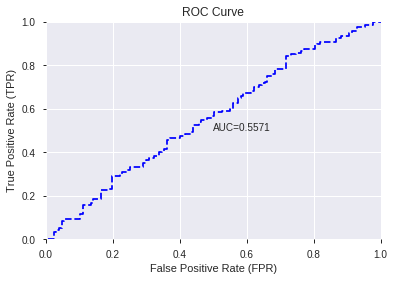

This function is available for GLM models only


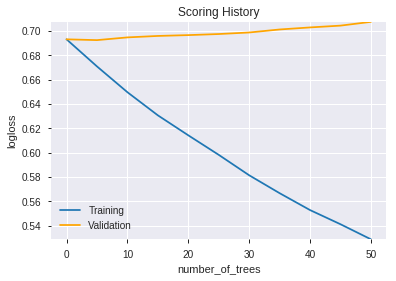

--2019-08-26 14:47:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.228.0
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.228.0|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


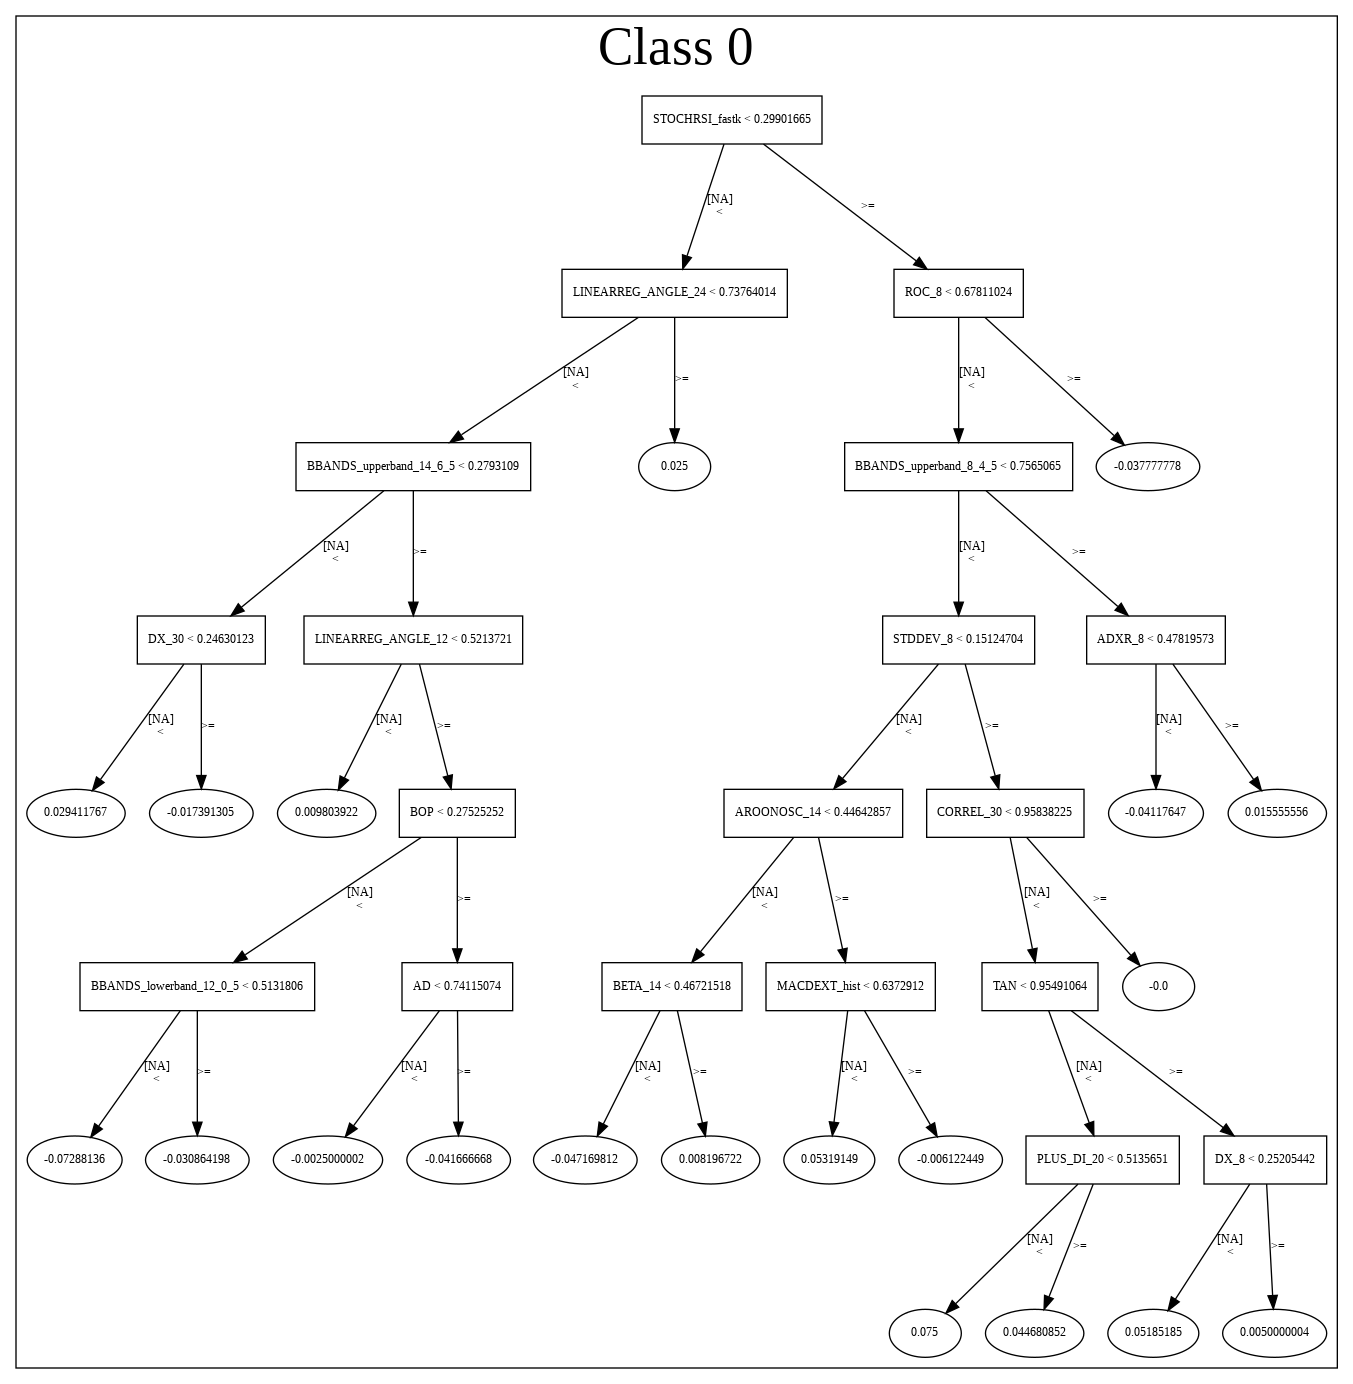

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190826_144629',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190826_144629',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a2a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_a2a1',
   'type

['DX_8',
 'Volume',
 'BETA_30',
 'BETA_14',
 'STOCHRSI_fastk',
 'dayofyear',
 'ADXR_8',
 'HT_PHASOR_quadrature',
 'CORREL_24',
 'CORREL_30',
 'CORREL_20',
 'CORREL_14',
 'BETA_24',
 'STDDEV_8',
 'CORREL_12',
 'ROC_8',
 'TRANGE',
 'MINUS_DI_30',
 'CCI_8',
 'BETA_20',
 'CORREL_8',
 'ADXR_12',
 'weekday_name',
 'DX_24',
 'ADX_8',
 'aroonup_20',
 'DIV',
 'ULTOSC',
 'PLUS_DI_8',
 'ROC_30',
 'SUB',
 'DX_30',
 'ADX_14',
 'TAN',
 'BETA_8',
 'STDDEV_14',
 'DX_12',
 'MACDEXT_hist',
 'MFI_8',
 'STDDEV_12',
 'ROC_20',
 'BETA_12',
 'dayofweek',
 'ADX_12',
 'BOP',
 'STOCH_slowd',
 'HT_PHASOR_inphase',
 'NATR_8',
 'ADX_20',
 'MACDFIX_signal_24',
 'MFI_20',
 'STDDEV_30',
 'MINUS_DI_24',
 'MINUS_DM_30',
 'WILLR_14',
 'OBV',
 'MOM_30',
 'CMO_12',
 'ROCP_8',
 'NATR_12',
 'ADXR_14',
 'LINEARREG_SLOPE_20',
 'CCI_14',
 'month',
 'MFI_12',
 'MINUS_DI_14',
 'ADOSC',
 'ROC_24',
 'LINEARREG_ANGLE_20',
 'MOM_24',
 'MINUS_DI_8',
 'aroondown_14',
 'MFI_30',
 'BBANDS_lowerband_12_5_5',
 'DX_20',
 'ROC_12',
 'MACDFI

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

159

['BBANDS_upperband_14_1_4',
 'BBANDS_middleband_14_1_4',
 'BBANDS_upperband_14_1_5',
 'BBANDS_lowerband_14_1_5',
 'MAVP_14_2',
 'BBANDS_middleband_14_2_2',
 'BBANDS_middleband_14_2_3',
 'BBANDS_lowerband_14_2_3',
 'BBANDS_upperband_14_2_4',
 'BBANDS_middleband_14_2_4',
 'BBANDS_middleband_14_2_5',
 'BBANDS_lowerband_14_2_5',
 'MAVP_14_3',
 'BBANDS_middleband_14_3_4',
 'MA_14_4',
 'BBANDS_upperband_14_4_3',
 'BBANDS_lowerband_14_4_3',
 'BBANDS_upperband_14_4_5',
 'MAVP_14_5',
 'BBANDS_middleband_14_5_3',
 'BBANDS_lowerband_14_5_5',
 'BBANDS_upperband_14_6_2',
 'BBANDS_lowerband_14_7_2',
 'BBANDS_upperband_14_7_3',
 'MIDPOINT_20',
 'BBANDS_lowerband_20_2_3',
 'BBANDS_upperband_20_2_5',
 'MA_20_3',
 'BBANDS_upperband_20_3_2',
 'BBANDS_middleband_20_3_3',
 'BBANDS_lowerband_20_3_3',
 'BBANDS_lowerband_20_3_4',
 'BBANDS_middleband_20_3_5',
 'MAVP_20_5',
 'BBANDS_upperband_20_5_5',
 'BBANDS_lowerband_20_5_5',
 'MAVP_20_6',
 'BBANDS_lowerband_20_6_2',
 'BBANDS_lowerband_20_7_2',
 'MA_24_1',
 

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_144829_model_2  0.556627  0.782912              0.492126  0.528276  0.279076
1  DeepLearning_grid_1_AutoML_20190826_144829_model_3  0.537664  0.779171              0.488189  0.530075  0.280980
2               DeepLearning_1_AutoML_20190826_144829  0.529987  0.865432              0.480545  0.556796  0.310022
3  DeepLearning_grid_1_AutoML_20190826_144829_model_1  0.525722  1.524938              0.500000  0.614265  0.377322
4  DeepLearning_grid_1_AutoML_20190826_144829_model_4  0.516995  0.871057              0.492126  0.555238  0.308290
5  DeepLearning_grid_1_AutoML_20190826_144829_model_5  0.516010  0.708600              0.488648  0.507490  0.257546
6  DeepLearning_grid_1_AutoML_20190826_144829_model_9  0.513615  0.699842              0.481004  0.503302  0.253313
7  DeepLearning_grid_1_AutoML_20190826_144829_model_6  0.503281  0.710927              0.492126  0.508410  0.258481
8  DeepLearning_grid_1_AutoML_20190826_144829_model_8  0.500000  0.697688              0.500000  0.502261  0.252266
9  DeepLearning_grid_1_AutoML_20190826_144829_model_7  0.497244  0.720455              0.484252  0.512532  0.262689

variable  relative_importance  scaled_importance  percentage
0                  aroonup_20             1.000000           1.000000    0.009238
1                 aroondown_8             0.996180           0.996180    0.009203
2                         BOP             0.952532           0.952532    0.008799
3                  aroonup_30             0.926153           0.926153    0.008556
4                   aroonup_8             0.918259           0.918259    0.008483
..                        ...                  ...                ...         ...
154   BBANDS_upperband_14_6_2             0.565780           0.565780    0.005227
155  BBANDS_middleband_20_3_3             0.562816           0.562816    0.005199
156              LINEARREG_12             0.562400           0.562400    0.005195
157                   MA_14_4             0.553228           0.553228    0.005111
158               MIDPOINT_20             0.551529           0.551529    0.005095

[159 rows x 4 columns]

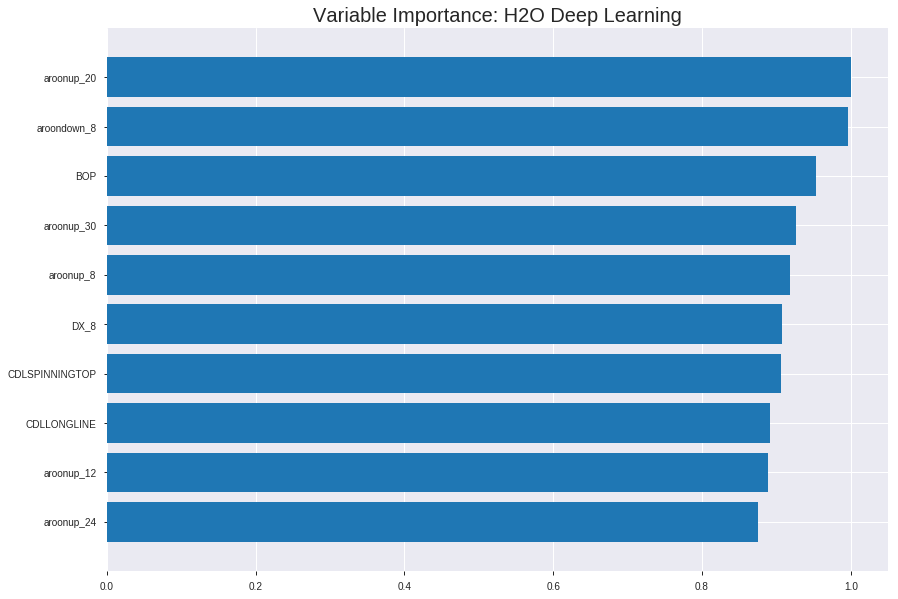

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_144829_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.300315035290535
RMSE: 0.5480100686032465
LogLoss: 0.8701150663171733
Mean Per-Class Error: 0.4673081825993468
AUC: 0.5233624751624474
pr_auc: 0.5084997030808824
Gini: 0.046724950324894765
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.004993744505957661: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    863   1        (863.0/863.0)
1      0    859   0        (0.0/859.0)
Total  0    1722  0.5012   (863.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00499374   0.665633   399
max f2                       0.00499374   0.832687   399
max f0point5                 0.00499374   0.554408   399
max accuracy                 0.353204     0.53252    240
max precision                0.732592     0.560284   61
max recall                   0.00499374   1          399
max specificity              0.98847      0.998841   0
max absolute_mcc             0.353204     0.0661066  240
max min_per_class_accuracy   0.38662      0.512167   220
max mean_per_class_accuracy  0.353204     0.532692   240

Gains/Lift Table: Avg response rate: 49.88 %, avg score: 40.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010453                    0.953766           0.668219  0.668219           0.333333         0.971412   0.333333                    0.971412            0.00698487      0.00698487                 -33.1781   -33.1781
    2        0.0203252                   0.926084           0.707526  0.687311           0.352941         0.941527   0.342857                    0.956897            0.00698487      0.0139697                  -29.2474   -31.2689
    3        0.0301974                   0.890251           1.06129   0.809573           0.529412         0.906997   0.403846                    0.940583            0.0104773       0.024447                   6.12888    -19.0427
    4        0.0400697                   0.845369           1.06129   0.87159            0.529412         0.870534   0.434783                    0.923325            0.0104773       0.0349243                  6.12888    -12.841
    5        0.0505226                   0.809622           0.779589  0.852555           0.388889         0.828049   0.425287                    0.903613            0.00814901      0.0430733                  -22.0411   -14.7445
    6        0.100465                    0.7047             1.32867   1.08924            0.662791         0.747107   0.543353                    0.825812            0.0663562       0.10943                    32.8668    8.92354
    7        0.150407                    0.623293           0.792539  0.990718           0.395349         0.662531   0.494208                    0.771595            0.0395809       0.14901                    -20.7461   -0.928169
    8        0.200348                    0.572043           1.18881   1.0401             0.593023         0.596703   0.518841                    0.727999            0.0593714       0.208382                   18.8808    4.00972
    9        0.300232                    0.494312           1.10722   1.06243            0.552326         0.532206   0.529981                    0.662861            0.110594        0.318976                   10.7223    6.24292
    10       0.400116                    0.435455           1.01398   1.05034            0.505814         0.465426   0.523948                    0.613574            0.101281        0.420256                   1.39833    5.03353
    11       0.5                         0.385862           0.920743  1.02445            0.459302         0.411072   0.511034                    0.57312             0.0919674       0.512224                   -7.92566   2.4447
    12       0.599884                    0.337478           1.15384   1.04599            0.575581         0.362417   0.521781                    0.538037            0.11525         0.627474                   15.3843    4.59922
    13       0.699768                    0.277442           0.885778  1.02312            0.44186          0.309224   0.510373                    0.505377            0.088475        0.715949                   -11.4222   2.31235
    14       0.799652                    0.206762           0.897433  1.00742            0.447674         0.2433     0.502542                    0.472641            0.0896391       0.805588                   -10.2567   0.742364
    15       0.899535                    0.12326            0.944053  1.00039            0.47093          0.167907   0.499032                    0.438803            0.0942957       0.899884                   -5.59466   0.0387046
    16       1                           0.00442753         0.996534  1                  0.49711          0.0636384  0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.28744057605018003
RMSE: 0.5361348487555906
LogLoss: 0.7765811577482432
Mean Per-Class Error: 0.49436966950959493
AUC: 0.4607209488272921
pr_auc: 0.5225016872677144
Gini: -0.07855810234541583
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16093795741466643: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    222  0.9911   (222.0/224.0)
1      0    268  0        (0.0/268.0)
Total  2    490  0.4512   (222.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.160938     0.707124  397
max f2                       0.160938     0.857875  397
max f0point5                 0.160938     0.601436  397
max accuracy                 0.167872     0.54878   395
max precision                0.878536     1         0
max recall                   0.160938     1         397
max specificity              0.878536     1         0
max absolute_mcc             0.302706     0.102214  327
max min_per_class_accuracy   0.415771     0.481343  203
max mean_per_class_accuracy  0.739291     0.50563   13

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 42.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.812971           1.46866   1.46866            0.8              0.85146   0.8                         0.85146             0.0149254       0.0149254                  46.8657   46.8657
    2        0.0203252                   0.777948           0.734328  1.10149            0.4              0.791455  0.6                         0.821457            0.00746269      0.0223881                  -26.5672  10.1493
    3        0.0304878                   0.737995           1.10149   1.10149            0.6              0.760912  0.6                         0.801275            0.011194        0.0335821                  10.1493   10.1493
    4        0.0406504                   0.690339           0.734328  1.0097             0.4              0.722823  0.55                        0.781662            0.00746269      0.0410448                  -26.5672  0.970149
    5        0.050813                    0.66279            0.734328  0.954627           0.4              0.670784  0.52                        0.759487            0.00746269      0.0485075                  -26.5672  -4.53731
    6        0.101626                    0.577912           1.02806   0.991343           0.56             0.61516   0.54                        0.687323            0.0522388       0.100746                   2.80597   -0.865672
    7        0.150407                    0.547504           0.91791   0.967527           0.5              0.559029  0.527027                    0.645714            0.0447761       0.145522                   -8.20896  -3.24728
    8        0.20122                     0.521281           0.807761  0.927182           0.44             0.535334  0.505051                    0.61784             0.0410448       0.186567                   -19.2239  -7.28177
    9        0.300813                    0.47416            0.861712  0.905506           0.469388         0.500074  0.493243                    0.57885             0.0858209       0.272388                   -13.8288  -9.44937
    10       0.400407                    0.44687            1.1989    0.978483           0.653061         0.462022  0.532995                    0.549792            0.119403        0.391791                   19.8903   -2.15168
    11       0.5                         0.413958           0.899178  0.962687           0.489796         0.430278  0.52439                     0.525986            0.0895522       0.481343                   -10.0822  -3.73134
    12       0.599593                    0.382673           0.899178  0.952138           0.489796         0.397053  0.518644                    0.50457             0.0895522       0.570896                   -10.0822  -4.78624
    13       0.699187                    0.34755            1.01157   0.960604           0.55102          0.366299  0.523256                    0.484874            0.100746        0.671642                   1.15748   -3.9396
    14       0.79878                     0.31693            1.01157   0.966959           0.55102          0.331979  0.526718                    0.465811            0.100746        0.772388                   1.15748   -3.30409
    15       0.898374                    0.272801           1.08651   0.980212           0.591837         0.29576   0.533937                    0.446959            0.108209        0.880597                   8.65062   -1.97879
    16       1                           0.141517           1.17493   1                  0.64             0.223854  0.544715                    0.424


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:49:18  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:49:22  51.974 sec        2026 obs/sec      4.55459   1             7843       0.58677          1.08215             -0.377202      0.50889         0.499235           0.779589         0.499419                         0.574502           1.02504               -0.330856        0.505181          0.549844             0.734328           0.445122
    2019-08-26 14:49:28  58.607 sec        2287 obs/sec      13.6359   3             23481      0.54801          0.870115            -0.201267      0.523362        0.5085             0.668219         0.501161                         0.536135           0.776581              -0.159032        0.460721          0.522502             1.46866            0.45122
    2019-08-26 14:49:34  1 min  3.902 sec  2559 obs/sec      22.7462   5             39169      0.563633         0.938392            -0.270735      0.535989        0.51625            0.779589         0.501161                         0.543189           0.816712              -0.189734        0.499242          0.549722             1.10149            0.445122
    2019-08-26 14:49:40  1 min 10.574 sec  2880 obs/sec      36.3775   8             62642      0.54672          0.850191            -0.19562       0.540286        0.528018           1.1137           0.494193                         0.558498           0.886813              -0.257738        0.485608          0.531653             1.10149            0.441057
    2019-08-26 14:49:46  1 min 16.420 sec  3149 obs/sec      50.0139   11            86124      0.522264         0.790985            -0.091046      0.605947        0.576842           0.779589         0.471545                         0.564864           0.887815              -0.286577        0.46157           0.522853             1.46866            0.447154
    2019-08-26 14:49:52  1 min 21.813 sec  3373 obs/sec      63.6243   14            109561     0.480249         0.656549            0.0774394      0.678726        0.668579           1.78192          0.445993                         0.556109           0.857374              -0.247           0.475238          0.532199             1.46866            0.453252
    2019-08-26 14:49:57  1 min 26.929 sec  3559 obs/sec      77.2282   17            132987     0.51161          0.768337            -0.0469862     0.636641        0.593598           1.44781          0.427991                         0.595547           1.06756               -0.430144        0.482085          0.542385             1.10149            0.453252
    2019-08-26 14:49:57  1 min 27.301 sec  3558 obs/sec      77.2282   17            132987     0.54801          0.870115            -0.201267      0.523362        0.5085             0.668219         0.501161                         0.536135           0.776581              -0.159032        0.460721          0.522502             1.46866            0.45122

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
aroonup_20                1.0                    1.0                  0.009237869627344198
aroondown_8               0.9961804151535034     0.9961804151535034   0.009202584800501684
BOP                       0.9525316953659058     0.9525316953659058   0.008799363617703377
aroonup_30                0.9261525869369507     0.9261525869369507   0.008555676853151114
aroonup_8                 0.918258786201477      0.918258786201477    0.008482754951092575
---                       ---                    ---                  ---
BBANDS_upperband_14_6_2   0.5657799243927002     0.5657799243927002   0.005226601179308422
BBANDS_middleband_20_3_3  0.5628163814544678     0.5628163814544678   0.005199224356009995
LINEARREG_12              0.5624004602432251     0.5624004602432251   0.005195382130085287
MA_14_4                   0.5532284379005432     0.5532284379005432   0.005110652183464504
MIDPOINT_20               0.5515285730361938     0.5515285730361938   0.005094949053463541


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5789473684210527)

('F1', 0.6575342465753424)

('auc', 0.5566272965879265)

('logloss', 0.7829123346980421)

('mean_per_class_error', 0.4241469816272966)

('rmse', 0.5282763773327869)

('mse', 0.27907593084785304)

deeplearning prediction progress: |███████████████████████████████████████| 100%


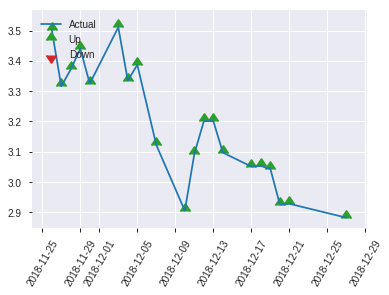


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.27907593084785304
RMSE: 0.5282763773327869
LogLoss: 0.7829123346980421
Mean Per-Class Error: 0.4241469816272966
AUC: 0.5566272965879265
pr_auc: 0.5548777908201602
Gini: 0.11325459317585307
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0787834486953822: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    125  0.9843   (125.0/127.0)
1      0    120  0        (0.0/120.0)
Total  2    245  0.5061   (125.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0787834    0.657534  244
max f2                       0.0787834    0.827586  244
max f0point5                 0.48672      0.556452  124
max accuracy                 0.587863     0.578947  95
max precision                0.990207     1         0
max recall                   0.0787834    1         244
max specificity              0.990207     1         0
max absolute_mcc             0.587863     0.15555   95
max min_per_class_accuracy   0.48739      0.559055  123
max mean_per_class_accuracy  0.587863     0.575853  95

Gains/Lift Table: Avg response rate: 48.58 %, avg score: 48.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.981691           2.05833   2.05833            1                0.986825  1                           0.986825            0.025           0.025                      105.833   105.833
    2        0.0202429                   0.907807           1.02917   1.64667            0.5              0.9708    0.8                         0.980415            0.00833333      0.0333333                  2.91667   64.6667
    3        0.0323887                   0.883961           2.05833   1.80104            1                0.896971  0.875                       0.949124            0.025           0.0583333                  105.833   80.1042
    4        0.0404858                   0.845771           0         1.44083            0                0.873598  0.7                         0.934019            0               0.0583333                  -100      44.0833
    5        0.0526316                   0.832825           1.37222   1.425              0.666667         0.838048  0.692308                    0.911872            0.0166667       0.075                      37.2222   42.5
    6        0.101215                    0.769642           1.20069   1.31733            0.583333         0.803001  0.64                        0.859613            0.0583333       0.133333                   20.0694   31.7333
    7        0.149798                    0.725575           0.857639  1.16824            0.416667         0.749003  0.567568                    0.82374             0.0416667       0.175                      -14.2361  16.8243
    8        0.202429                    0.690848           1.10833   1.15267            0.538462         0.709271  0.56                        0.793978            0.0583333       0.233333                   10.8333   15.2667
    9        0.299595                    0.648709           0.943403  1.0848             0.458333         0.666889  0.527027                    0.75276             0.0916667       0.325                      -5.65972  8.47973
    10       0.40081                     0.578286           1.482     1.1851             0.72             0.61276   0.575758                    0.717406            0.15            0.475                      48.2      18.5101
    11       0.502024                    0.48739            0.905667  1.12876            0.44             0.533069  0.548387                    0.680241            0.0916667       0.566667                   -9.43333  12.8763
    12       0.59919                     0.409424           0.686111  1.05698            0.333333         0.448757  0.513514                    0.642703            0.0666667       0.633333                   -31.3889  5.6982
    13       0.700405                    0.32842            0.988     1.04701            0.48             0.363253  0.508671                    0.60232             0.1             0.733333                   -1.2      4.70135
    14       0.797571                    0.248402           1.02917   1.04484            0.5              0.2884    0.507614                    0.564076            0.1             0.833333                   2.91667   4.48393
    15       0.898785                    0.152808           0.329333  0.964264           0.16             0.196492  0.468468                    0.522682            0.0333333       0.866667                   -67.0667  -3.57357
    16       1                           0.0540841          1.31733   1                  0.64             0.116562  0.48583                     0.481577            

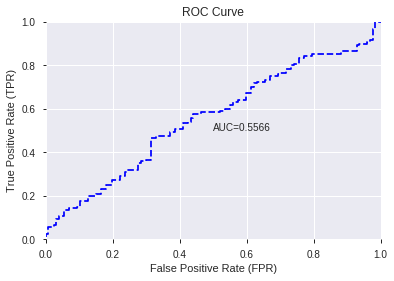

This function is available for GLM models only


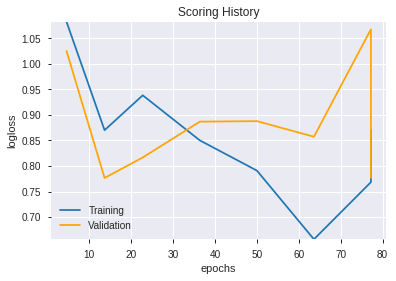

--2019-08-26 15:01:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.83.40
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.83.40|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


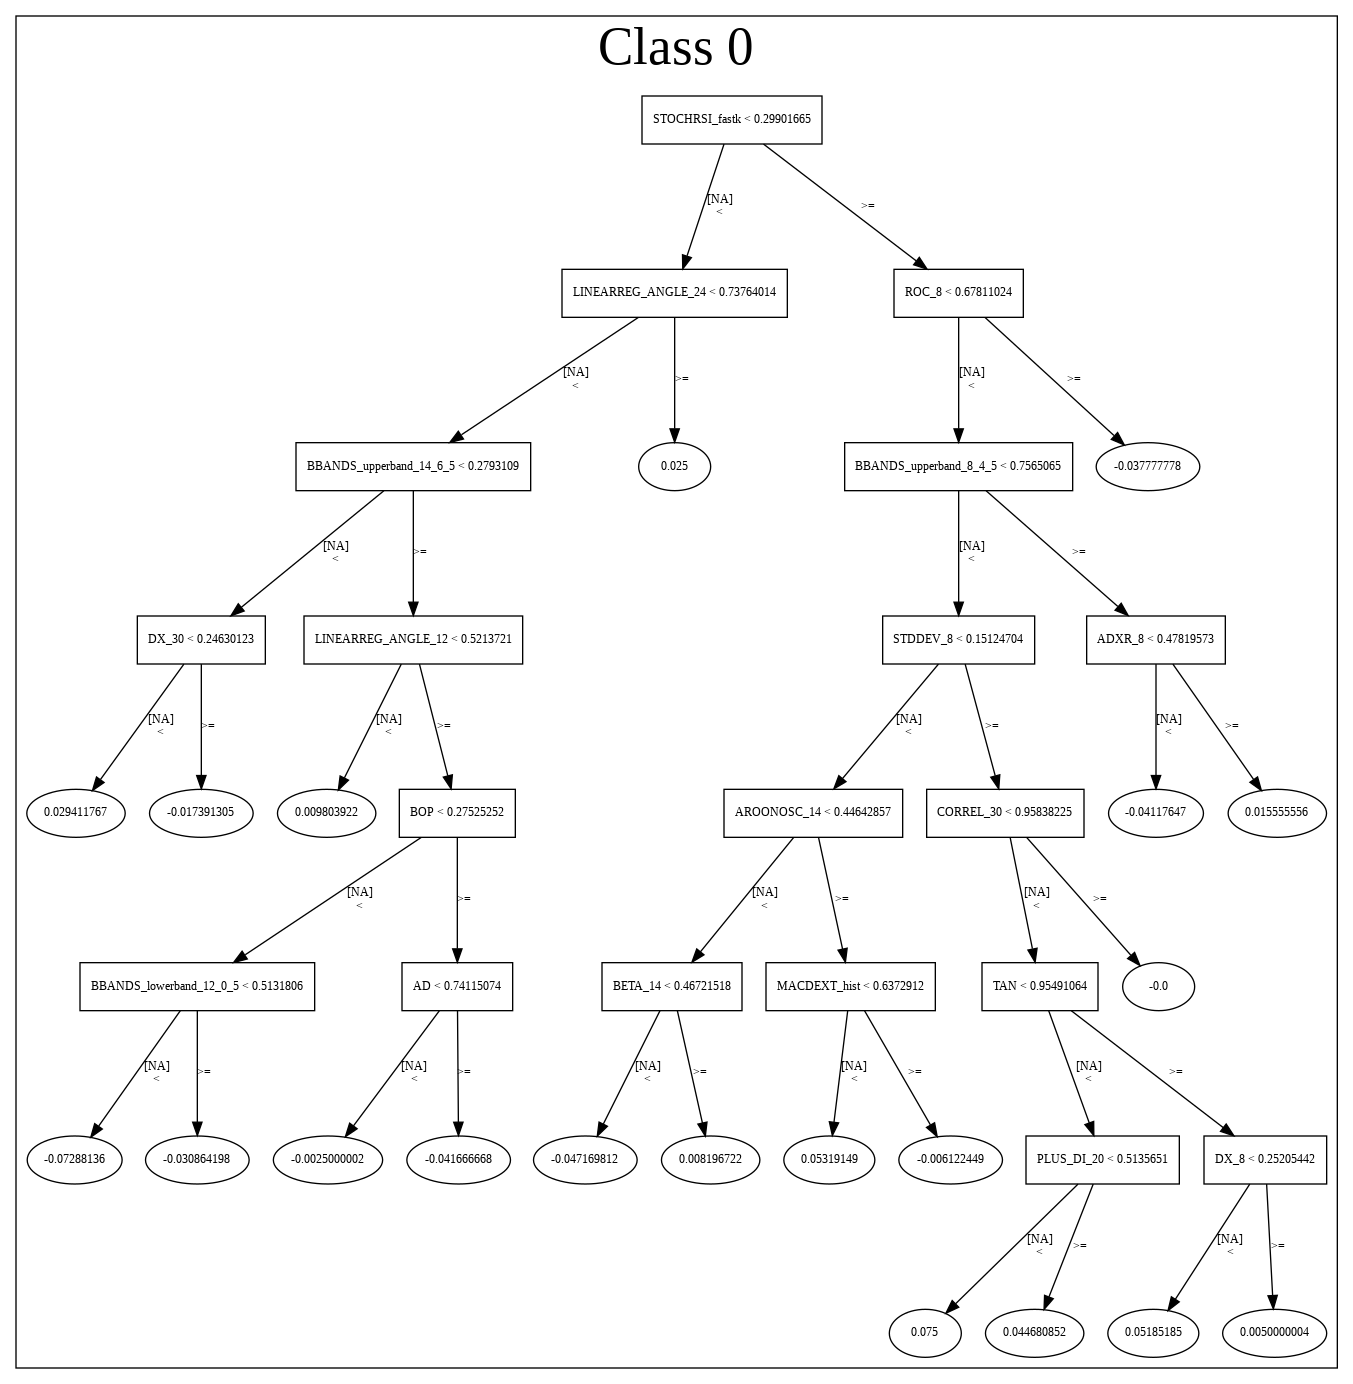

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_144829_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_144829_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a2a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['aroonup_20',
 'aroondown_8',
 'BOP',
 'aroonup_30',
 'aroonup_8',
 'DX_8',
 'CDLSPINNINGTOP',
 'CDLLONGLINE',
 'aroonup_12',
 'aroonup_24',
 'STOCHRSI_fastk',
 'CORREL_12',
 'aroondown_20',
 'MFI_8',
 'BETA_12',
 'STOCH_slowd',
 'ADX_14',
 'AROONOSC_30',
 'ADXR_8',
 'VAR_8',
 'CDLSHORTLINE',
 'aroondown_12',
 'aroondown_24',
 'STDDEV_8',
 'ATR_30',
 'STOCHF_fastk',
 'CCI_8',
 'ADX_8',
 'MFI_30',
 'MFI_14',
 'CDLLONGLEGGEDDOJI',
 'TRANGE',
 'STOCHRSI_fastd',
 'HT_PHASOR_inphase',
 'CORREL_8',
 'CCI_12',
 'AROONOSC_24',
 'ADOSC',
 'LINEARREG_SLOPE_12',
 'MINUS_DM_30',
 'PLUS_DM_14',
 'DX_12',
 'MINUS_DI_8',
 'DX_14',
 'MFI_20',
 'ROCR100_24',
 'NATR_30',
 'WILLR_12',
 'MINUS_DI_30',
 'ATR_12',
 'PLUS_DM_8',
 'CDLBELTHOLD',
 'DX_20',
 'PLUS_DI_12',
 'ROCR_12',
 'ROC_30',
 'BBANDS_upperband_14_1_4',
 'PLUS_DM_24',
 'BBANDS_upperband_20_5_5',
 'DX_24',
 'BBANDS_lowerband_14_1_5',
 'LINEARREG_SLOPE_8',
 'CCI_14',
 'BBANDS_upperband_24_7_5',
 'ROCR100_30',
 'LINEARREG_ANGLE_12',
 'WILLR_14'

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_150148_model_1  0.491732  0.693611              0.496063  0.500232  0.250232

variable  relative_importance  scaled_importance  percentage
0    CDLSPINNINGTOP             0.008050           1.000000    0.030665
1    STOCHRSI_fastk             0.007059           0.876877    0.026889
2      CDLSHORTLINE             0.006628           0.823347    0.025248
3           NATR_30             0.006046           0.751004    0.023029
4        aroonup_20             0.005740           0.713045    0.021865
..              ...                  ...                ...         ...
154      PLUS_DI_30             0.000112           0.013946    0.000428
155        CORREL_8             0.000087           0.010804    0.000331
156          MFI_14             0.000071           0.008845    0.000271
157      PLUS_DI_20             0.000031           0.003803    0.000117
158          TRANGE             0.000024           0.002951    0.000090

[159 rows x 4 columns]

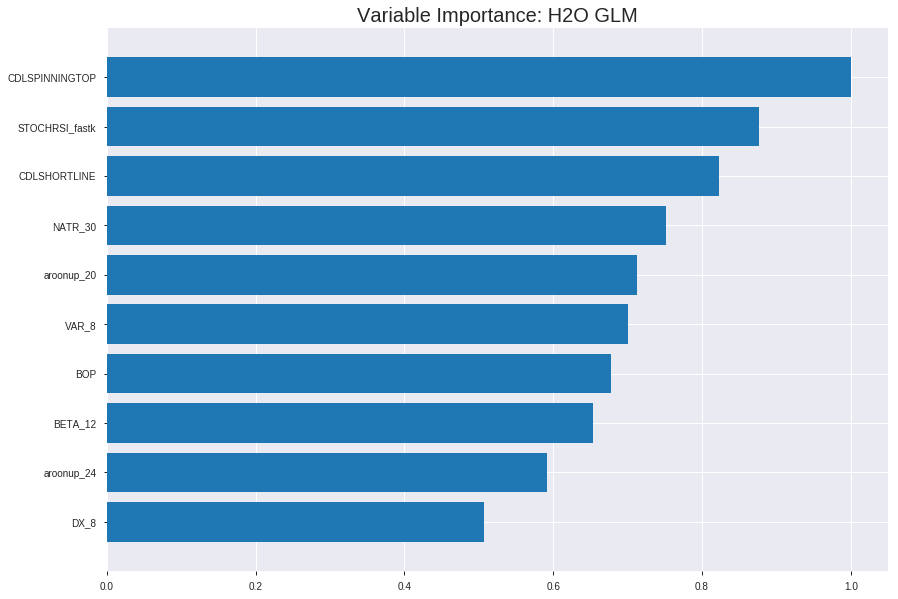

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_150148_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24863990464081992
RMSE: 0.4986380497322882
LogLoss: 0.6904251752123894
Null degrees of freedom: 1721
Residual degrees of freedom: 1562
Null deviance: 2387.1895983186078
Residual deviance: 2377.824303431469
AIC: 2697.824303431469
AUC: 0.5594664630650585
pr_auc: 0.5451143881740996
Gini: 0.11893292613011708
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45504576073656583: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    863   1        (863.0/863.0)
1      0    859   0        (0.0/859.0)
Total  0    1722  0.5012   (863.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.455046     0.665633  399
max f2                       0.455046     0.832687  399
max f0point5                 0.484974     0.566651  292
max accuracy                 0.498948     0.545877  199
max precision                0.530749     0.636364  13
max recall                   0.455046     1         399
max specificity              0.542151     0.998841  0
max absolute_mcc             0.513198     0.10305   99
max min_per_class_accuracy   0.499705     0.541136  194
max mean_per_class_accuracy  0.496133     0.546093  219

Gains/Lift Table: Avg response rate: 49.88 %, avg score: 49.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010453                    0.531163           1.22507   1.22507            0.611111         0.534335  0.611111                    0.534335            0.0128056       0.0128056                  22.5068    22.5068
    2        0.0203252                   0.528328           0.943368  1.08824            0.470588         0.529512  0.542857                    0.531992            0.00931315      0.0221187                  -5.66322   8.82421
    3        0.0301974                   0.526104           1.41505   1.19508            0.705882         0.527015  0.596154                    0.530365            0.0139697       0.0360885                  41.5052    19.5084
    4        0.0400697                   0.524873           1.06129   1.16212            0.529412         0.525463  0.57971                     0.529157            0.0104773       0.0465658                  6.12888    16.212
    5        0.0505226                   0.523123           1.1137    1.1521             0.555556         0.523999  0.574713                    0.52809             0.0116414       0.0582072                  11.3698    15.2101
    6        0.100465                    0.518382           1.18881   1.17035            0.593023         0.520476  0.583815                    0.524305            0.0593714       0.117579                   18.8808    17.0349
    7        0.150407                    0.515437           1.1655    1.16874            0.581395         0.516851  0.583012                    0.52183             0.0582072       0.175786                   16.5498    16.8738
    8        0.200348                    0.513037           1.30536   1.20279            0.651163         0.51425   0.6                         0.519941            0.0651921       0.240978                   30.5358    20.2794
    9        0.300232                    0.507932           0.944053  1.11671            0.47093          0.51023   0.55706                     0.51671             0.0942957       0.335274                   -5.59466   11.6714
    10       0.400116                    0.503535           0.990673  1.08525            0.494186         0.505815  0.541364                    0.51399             0.0989523       0.434226                   -0.932669  8.52495
    11       0.5                         0.499621           1.07226   1.08265            0.534884         0.501548  0.54007                     0.511505            0.107101        0.541327                   7.22582    8.26542
    12       0.599884                    0.495777           1.02564   1.07316            0.511628         0.497717  0.535334                    0.509209            0.102445        0.643772                   2.56382    7.31608
    13       0.699768                    0.490762           0.955708  1.0564             0.476744         0.493508  0.526971                    0.506968            0.0954598       0.739232                   -4.42916   5.63958
    14       0.799652                    0.485573           0.955708  1.04382            0.476744         0.488191  0.520697                    0.504622            0.0954598       0.834692                   -4.42916   4.3819
    15       0.899535                    0.47738            0.827504  1.0198             0.412791         0.481674  0.508715                    0.502074            0.0826542       0.917346                   -17.2496   1.97995
    16       1                           0.455046           0.82272   1                  0.410405         0.469869  0.498839                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24956295712656784
RMSE: 0.49956276595295596
LogLoss: 0.6922734643932236
Null degrees of freedom: 491
Residual degrees of freedom: 332
Null deviance: 682.2638942389361
Residual deviance: 681.197088962932
AIC: 1001.197088962932
AUC: 0.47461353944562895
pr_auc: 0.5259834698353872
Gini: -0.0507729211087421
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.473848793076662: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    268  0        (0.0/268.0)
Total  0    492  0.4553   (224.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.473849     0.705263  399
max f2                       0.473849     0.856777  399
max f0point5                 0.489114     0.601093  389
max accuracy                 0.48953      0.54878   387
max precision                0.531156     0.666667  20
max recall                   0.473849     1         399
max specificity              0.543599     0.995536  0
max absolute_mcc             0.535151     0.110832  4
max min_per_class_accuracy   0.513937     0.477679  191
max mean_per_class_accuracy  0.531156     0.510494  20

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 51.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.534681           0         0                  0                0.538185  0                           0.538185            0               0                          -100      -100
    2        0.0203252                   0.533485           1.83582   0.91791            1                0.534363  0.5                         0.536274            0.0186567       0.0186567                  83.5821   -8.20896
    3        0.0304878                   0.531919           1.46866   1.10149            0.8              0.532666  0.6                         0.535071            0.0149254       0.0335821                  46.8657   10.1493
    4        0.0406504                   0.531164           1.46866   1.19328            0.8              0.531548  0.65                        0.53419             0.0149254       0.0485075                  46.8657   19.3284
    5        0.050813                    0.529938           0.734328  1.10149            0.4              0.530687  0.6                         0.53349             0.00746269      0.0559701                  -26.5672  10.1493
    6        0.101626                    0.526683           0.807761  0.954627           0.44             0.528176  0.52                        0.530833            0.0410448       0.0970149                  -19.2239  -4.53731
    7        0.150407                    0.524509           1.0709    0.992336           0.583333         0.525739  0.540541                    0.529181            0.0522388       0.149254                   7.08955   -0.766438
    8        0.20122                     0.52287            0.881194  0.96427            0.48             0.523655  0.525253                    0.527785            0.0447761       0.19403                    -11.8806  -3.57304
    9        0.300813                    0.519429           0.824246  0.91791            0.44898          0.52107   0.5                         0.525562            0.0820896       0.276119                   -17.5754  -8.20896
    10       0.400407                    0.516593           0.899178  0.913251           0.489796         0.518044  0.497462                    0.523692            0.0895522       0.365672                   -10.0822  -8.6749
    11       0.5                         0.513923           1.16144   0.962687           0.632653         0.515156  0.52439                     0.521992            0.115672        0.481343                   16.1438   -3.73134
    12       0.599593                    0.511432           1.04904   0.97703            0.571429         0.512711  0.532203                    0.52045             0.104478        0.585821                   4.90405   -2.29699
    13       0.699187                    0.508157           1.12397   0.997961           0.612245         0.509743  0.543605                    0.518925            0.11194         0.697761                   12.3972   -0.203922
    14       0.79878                     0.50355            1.01157   0.999658           0.55102          0.506291  0.544529                    0.51735             0.100746        0.798507                   1.15748   -0.0341802
    15       0.898374                    0.498875           0.936643  0.992672           0.510204         0.501592  0.540724                    0.515603            0.0932836       0.891791                   -6.33567  -0.732762
    16       1                           0.473849           1.06478   1                  0.58             0.492554  0.544715                    0.513


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 15:01:48  0.000 sec   2            2.8       160           1.38085           1.38455
    2019-08-26 15:01:49  0.064 sec   4            2.1       160           1.37955           1.38484
    2019-08-26 15:01:49  0.125 sec   6            1.5       160           1.37799           1.38525
    2019-08-26 15:01:49  0.187 sec   8            1.1       160           1.37616           1.38584
    2019-08-26 15:01:49  0.246 sec   10           0.8       160           1.37406           1.38661
    2019-08-26 15:01:49  0.307 sec   12           0.58      160           1.37172           1.38766

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5303643724696356)

('F1', 0.6557377049180327)

('auc', 0.49173228346456693)

('logloss', 0.6936106847081253)

('mean_per_class_error', 0.47306430446194225)

('rmse', 0.5002315867353062)

('mse', 0.25023164036772216)

glm prediction progress: |████████████████████████████████████████████████| 100%


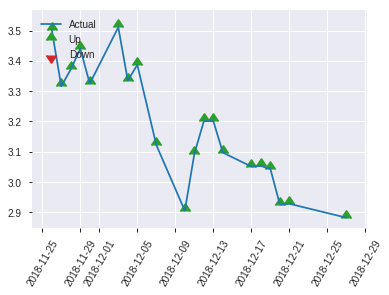


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25023164036772216
RMSE: 0.5002315867353062
LogLoss: 0.6936106847081253
Null degrees of freedom: 246
Residual degrees of freedom: 87
Null deviance: 342.38351957249984
Residual deviance: 342.6436782458139
AIC: 662.6436782458138
AUC: 0.49173228346456693
pr_auc: 0.4853664179581891
Gini: -0.016535433070866135
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4723678894974473: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    126  0.9921   (126.0/127.0)
1      0    120  0        (0.0/120.0)
Total  1    246  0.5101   (126.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.472368     0.655738  245
max f2                       0.472368     0.826446  245
max f0point5                 0.475142     0.544872  242
max accuracy                 0.516284     0.530364  13
max precision                0.524978     1         0
max recall                   0.472368     1         245
max specificity              0.524978     1         0
max absolute_mcc             0.483104     0.100794  219
max min_per_class_accuracy   0.500678     0.496063  123
max mean_per_class_accuracy  0.495311     0.526936  163

Gains/Lift Table: Avg response rate: 48.58 %, avg score: 49.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.522866           1.37222   1.37222            0.666667         0.523786  0.666667                    0.523786            0.0166667       0.0166667                  37.2222   37.2222
    2        0.0202429                   0.522125           1.02917   1.235              0.5              0.522689  0.6                         0.523347            0.00833333      0.025                      2.91667   23.5
    3        0.0323887                   0.519484           0.686111  1.02917            0.333333         0.52078   0.5                         0.522384            0.00833333      0.0333333                  -31.3889  2.91667
    4        0.0404858                   0.51766            2.05833   1.235              1                0.518743  0.6                         0.521656            0.0166667       0.05                       105.833   23.5
    5        0.0526316                   0.516302           1.37222   1.26667            0.666667         0.516964  0.615385                    0.520573            0.0166667       0.0666667                  37.2222   26.6667
    6        0.101215                    0.515337           0.686111  0.988              0.333333         0.515809  0.48                        0.518286            0.0333333       0.1                        -31.3889  -1.2
    7        0.149798                    0.512763           0.857639  0.945721           0.416667         0.514156  0.459459                    0.516947            0.0416667       0.141667                   -14.2361  -5.42793
    8        0.202429                    0.509884           0.791667  0.905667           0.384615         0.511225  0.44                        0.515459            0.0416667       0.183333                   -20.8333  -9.43333
    9        0.299595                    0.50641            1.02917   0.945721           0.5              0.507998  0.459459                    0.513039            0.1             0.283333                   2.91667   -5.42793
    10       0.40081                     0.503077           1.15267   0.99798            0.56             0.504555  0.484848                    0.510897            0.116667        0.4                        15.2667   -0.20202
    11       0.502024                    0.500678           0.988     0.995968           0.48             0.501834  0.483871                    0.50907             0.1             0.5                        -1.2      -0.403226
    12       0.59919                     0.497435           1.20069   1.02917            0.583333         0.499084  0.5                         0.50745             0.116667        0.616667                   20.0694   2.91667
    13       0.700405                    0.493624           1.07033   1.03512            0.52             0.495719  0.50289                     0.505755            0.108333        0.725                      7.03333   3.51156
    14       0.797571                    0.487806           0.600347  0.982149           0.291667         0.490481  0.477157                    0.503894            0.0583333       0.783333                   -39.9653  -1.78511
    15       0.898785                    0.482604           0.905667  0.973536           0.44             0.485358  0.472973                    0.501807            0.0916667       0.875                      -9.43333  -2.6464
    16       1                           0.470813           1.235     1                  0.6              0.478992  0.48583                     0.499498           

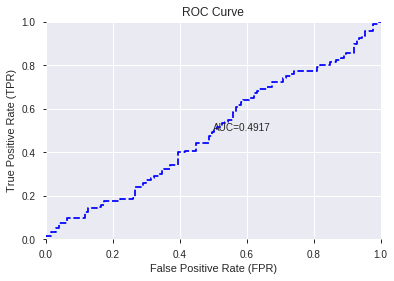

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


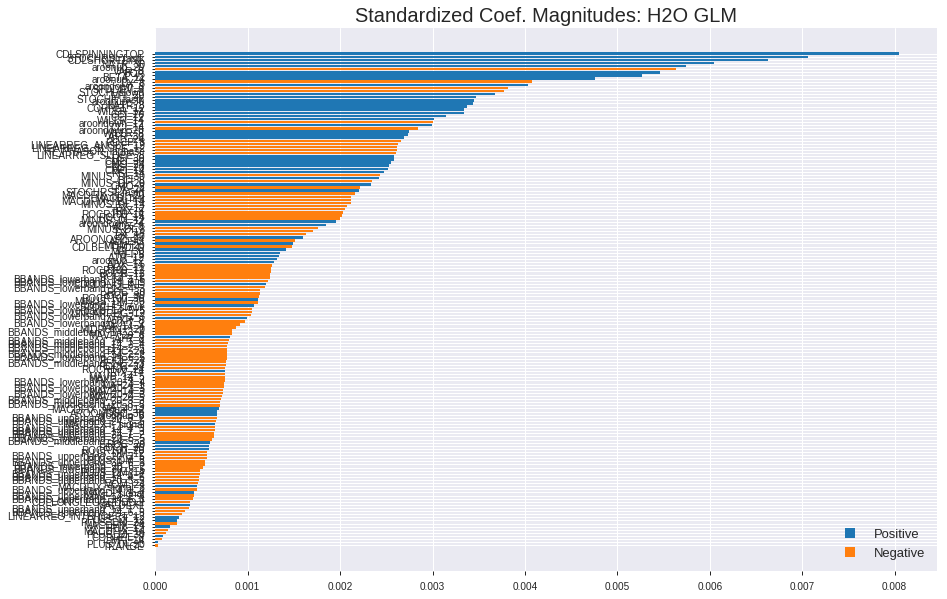

'log_likelihood'
--2019-08-26 15:01:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


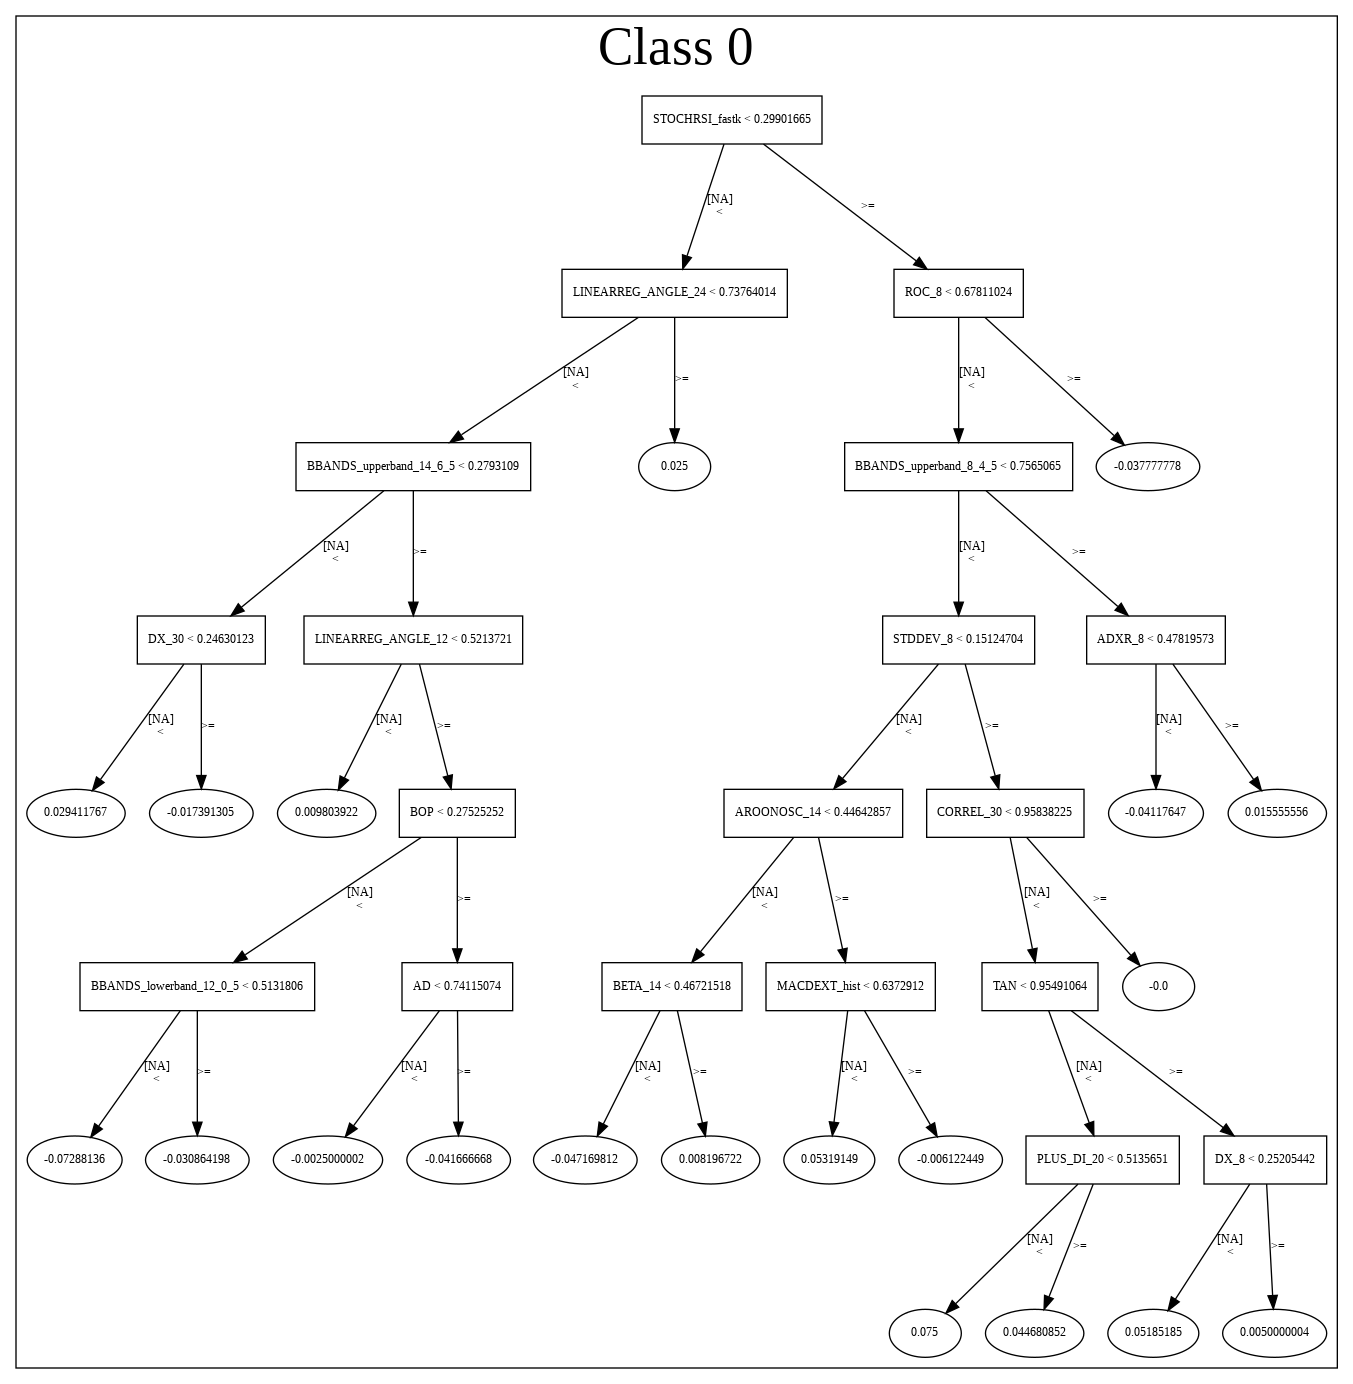

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_150148_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_150148_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a2a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLSPINNINGTOP',
 'STOCHRSI_fastk',
 'CDLSHORTLINE',
 'NATR_30',
 'aroonup_20',
 'VAR_8',
 'BOP',
 'BETA_12',
 'aroonup_24',
 'DX_8',
 'aroondown_8',
 'STDDEV_8',
 'STOCH_slowd',
 'MFI_20',
 'STOCHF_fastk',
 'aroonup_30',
 'NATR_8',
 'CORREL_12',
 'WILLR_12',
 'CCI_20',
 'CCI_12',
 'WILLR_14',
 'aroondown_12',
 'CCI_14',
 'aroondown_20',
 'WILLR_8',
 'ATR_30',
 'CCI_24',
 'ROCP_8',
 'LINEARREG_ANGLE_12',
 'LINEARREG_SLOPE_12',
 'HT_PHASOR_inphase',
 'LINEARREG_SLOPE_8',
 'RSI_30',
 'CMO_30',
 'CMO_24',
 'RSI_20',
 'CMO_14',
 'RSI_14',
 'MINUS_DI_30',
 'CCI_8',
 'MINUS_DI_20',
 'CMO_8',
 'DX_24',
 'STOCHRSI_fastd',
 'MACDFIX_hist_20',
 'MACD_hist',
 'MACDFIX_hist_14',
 'MINUS_DI_14',
 'DX_12',
 'TRIX_8',
 'ROCR100_14',
 'ROCR_14',
 'MINUS_DI_12',
 'aroondown_24',
 'ADX_8',
 'MINUS_DI_8',
 'DX_14',
 'DX_20',
 'AROONOSC_24',
 'ADOSC',
 'MOM_20',
 'CDLBELTHOLD',
 'MFI_30',
 'MFI_8',
 'ATR_12',
 'aroonup_12',
 'ADX_14',
 'ROC_12',
 'ROCR100_12',
 'ROCR_12',
 'ROCP_12',
 'BBANDS_lowerband_

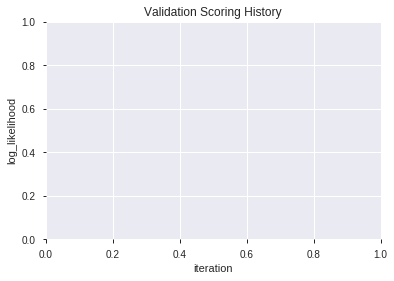

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_150202_model_1  0.544423  0.696389              0.496063  0.501250  0.251252
1  XGBoost_grid_1_AutoML_20190826_150202_model_7  0.538255  0.704138              0.481234  0.504961  0.254985
2               XGBoost_3_AutoML_20190826_150202  0.531759  0.694866              0.492126  0.500827  0.250827
3  XGBoost_grid_1_AutoML_20190826_150202_model_6  0.528084  0.698411              0.488189  0.502489  0.252496
4  XGBoost_grid_1_AutoML_20190826_150202_model_3  0.515879  0.701273              0.465486  0.503883  0.253898
5  XGBoost_grid_1_AutoML_20190826_150202_model_4  0.514698  0.698591              0.500000  0.502649  0.252656
6  XGBoost_grid_1_AutoML_20190826_150202_model_2  0.510827  0.699483              0.465486  0.503127  0.253137
7               XGBoost_1_AutoML_20190826_150202  0.509186  0.711782              0.496063  0.508660  0.258735
8               XGBoost_2_AutoML_20190826_150202  0.508333  0.710093              0.488419  0.508005  0.258070
9  XGBoost_grid_1_AutoML_20190826_150202_model_5  0.503346  0.732306              0.477526  0.517011  0.267300

variable  relative_importance  scaled_importance  percentage
0                     TRANGE           162.011749           1.000000    0.041792
1                     ROCP_8           132.508438           0.817894    0.034181
2                       DX_8           118.683144           0.732559    0.030615
3                   CORREL_8            96.957710           0.598461    0.025011
4                    BETA_12            96.686249           0.596785    0.024941
..                       ...                  ...                ...         ...
118  BBANDS_upperband_30_6_3             4.461510           0.027538    0.001151
119  BBANDS_upperband_14_2_4             3.756855           0.023189    0.000969
120               ROCR100_14             3.517261           0.021710    0.000907
121                  ROCP_30             3.495926           0.021578    0.000902
122  BBANDS_lowerband_20_2_3             2.899310           0.017896    0.000748

[123 rows x 4 columns]

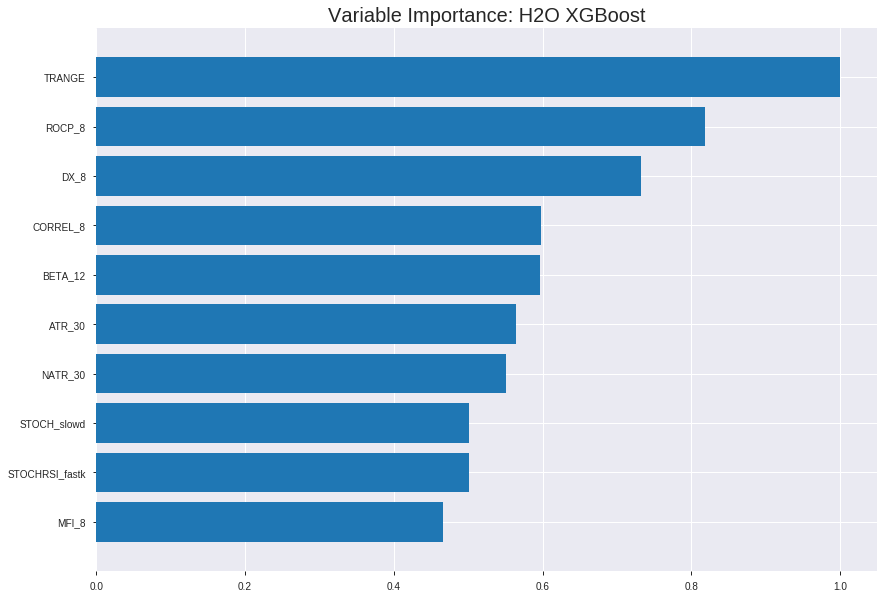

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_150202_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19647182932461948
RMSE: 0.44325142901587977
LogLoss: 0.5835714462646845
Mean Per-Class Error: 0.17990279462092462
AUC: 0.9069291544642845
pr_auc: 0.9082820408819416
Gini: 0.8138583089285689
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48823641879217966: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      663  200  0.2317   (200.0/863.0)
1      110  749  0.1281   (110.0/859.0)
Total  773  949  0.18     (310.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488236     0.82854   208
max f2                       0.447196     0.890249  254
max f0point5                 0.516576     0.846914  171
max accuracy                 0.488236     0.819977  208
max precision                0.763369     1         0
max recall                   0.398806     1         309
max specificity              0.763369     1         0
max absolute_mcc             0.516576     0.64585   171
max min_per_class_accuracy   0.49921      0.814901  193
max mean_per_class_accuracy  0.488236     0.820097  208

Gains/Lift Table: Avg response rate: 49.88 %, avg score: 49.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.701175           2.00466   2.00466            1                0.724288  1                           0.724288            0.0209546       0.0209546                  100.466   100.466
    2        0.0203252                   0.68479            2.00466   2.00466            1                0.694606  1                           0.709871            0.0197905       0.0407451                  100.466   100.466
    3        0.0301974                   0.668927           2.00466   2.00466            1                0.676446  1                           0.698944            0.0197905       0.0605355                  100.466   100.466
    4        0.0400697                   0.660971           2.00466   2.00466            1                0.665589  1                           0.690726            0.0197905       0.080326                   100.466   100.466
    5        0.0505226                   0.650625           2.00466   2.00466            1                0.65499   1                           0.683332            0.0209546       0.101281                   100.466   100.466
    6        0.100465                    0.618529           1.98135   1.99307            0.988372         0.632699  0.99422                     0.658162            0.0989523       0.200233                   98.1347   99.3069
    7        0.150407                    0.598754           1.93473   1.9737             0.965116         0.608121  0.984556                    0.641546            0.096624        0.296857                   93.4727   97.3697
    8        0.200348                    0.578393           1.88811   1.95236            0.94186          0.587083  0.973913                    0.62797             0.0942957       0.391153                   88.8107   95.2361
    9        0.300232                    0.546949           1.67832   1.86119            0.837209         0.56165   0.928433                    0.605906            0.167637        0.558789                   67.8317   86.119
    10       0.400116                    0.520338           1.48018   1.76608            0.738372         0.534052  0.880987                    0.587969            0.147846        0.706636                   48.0182   76.6076
    11       0.5                         0.498831           1.10722   1.63446            0.552326         0.509488  0.815331                    0.572291            0.110594        0.817229                   10.7223   63.4459
    12       0.599884                    0.475592           0.874124  1.50786            0.436047         0.487551  0.752178                    0.558181            0.0873108       0.90454                    -12.5876  50.7859
    13       0.699768                    0.449022           0.547784  1.37082            0.273256         0.463256  0.683817                    0.544632            0.0547148       0.959255                   -45.2216  37.0819
    14       0.799652                    0.422265           0.25641   1.23162            0.127907         0.436015  0.614379                    0.531064            0.0256112       0.984866                   -74.359   23.1619
    15       0.899535                    0.3827             0.151515  1.11168            0.0755814        0.403904  0.554551                    0.516945            0.0151339       1                          -84.8485  11.1685
    16       1                           0.172532           0         1                  0                0.337967  0.498839                    0.498964          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2605161716301726
RMSE: 0.5104078483234487
LogLoss: 0.7161819991224234
Mean Per-Class Error: 0.46821695095948823
AUC: 0.4767290778251599
pr_auc: 0.5158787494498304
Gini: -0.04654184434968023
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22561022639274597: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    221  0.9866   (221.0/224.0)
1      1    267  0.0037   (1.0/268.0)
Total  4    488  0.4512   (222.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.22561      0.706349  395
max f2                       0.197398     0.857326  398
max f0point5                 0.388634     0.606936  362
max accuracy                 0.436669     0.560976  323
max precision                0.807085     1         0
max recall                   0.197398     1         398
max specificity              0.807085     1         0
max absolute_mcc             0.51452      0.115013  197
max min_per_class_accuracy   0.517185     0.451493  192
max mean_per_class_accuracy  0.436669     0.531783  323

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 51.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.786418           0.734328  0.734328           0.4              0.800582  0.4                         0.800582            0.00746269      0.00746269                 -26.5672  -26.5672
    2        0.0203252                   0.710826           0.367164  0.550746           0.2              0.76774   0.3                         0.784161            0.00373134      0.011194                   -63.2836  -44.9254
    3        0.0304878                   0.684805           1.46866   0.856716           0.8              0.693955  0.466667                    0.754092            0.0149254       0.0261194                  46.8657   -14.3284
    4        0.0406504                   0.678449           1.10149   0.91791            0.6              0.681437  0.5                         0.735928            0.011194        0.0373134                  10.1493   -8.20896
    5        0.050813                    0.672718           1.83582   1.10149            1                0.676151  0.6                         0.723973            0.0186567       0.0559701                  83.5821   10.1493
    6        0.101626                    0.630942           0.51403   0.807761           0.28             0.649995  0.44                        0.686984            0.0261194       0.0820896                  -48.597   -19.2239
    7        0.150407                    0.602741           1.30037   0.967527           0.708333         0.616093  0.527027                    0.663992            0.0634328       0.145522                   30.0373   -3.24728
    8        0.20122                     0.581625           0.587463  0.871551           0.32             0.591573  0.474747                    0.645704            0.0298507       0.175373                   -41.2537  -12.8449
    9        0.300813                    0.55687            1.01157   0.91791            0.55102          0.569117  0.5                         0.620348            0.100746        0.276119                   1.15748   -8.20896
    10       0.400407                    0.53563            0.861712  0.903932           0.469388         0.546048  0.492386                    0.601867            0.0858209       0.36194                    -13.8288  -9.60679
    11       0.5                         0.515845           0.899178  0.902985           0.489796         0.525718  0.49187                     0.586699            0.0895522       0.451493                   -10.0822  -9.70149
    12       0.599593                    0.497163           1.34877   0.97703            0.734694         0.506167  0.532203                    0.573323            0.134328        0.585821                   34.8766   -2.29699
    13       0.699187                    0.474505           1.16144   1.0033             0.632653         0.485827  0.546512                    0.56086             0.115672        0.701493                   16.1438   0.329747
    14       0.79878                     0.447646           1.1989    1.02769            0.653061         0.461826  0.559796                    0.548512            0.119403        0.820896                   19.8903   2.7686
    15       0.898374                    0.407275           0.899178  1.01344            0.489796         0.428806  0.552036                    0.535241            0.0895522       0.910448                   -10.0822  1.34396
    16       1                           0.186738           0.881194  1                  0.48             0.330431  0.544715                    0.5144


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 15:02:07  0.013 sec   0                  0.5              0.693147            0.5             0                  1                0.501161                         0.5                0.693147              0.5               0                    1                  0.455285
    2019-08-26 15:02:07  0.119 sec   5                  0.491914         0.677057            0.708961        0.713208           2.00466          0.4036                           0.502009           0.697195              0.458422          0.524996             1.04904            0.455285
    2019-08-26 15:02:07  0.172 sec   10                 0.484551         0.662564            0.768447        0.77542            2.00466          0.340883                         0.501523           0.696246              0.494678          0.537681             0.734328           0.455285
    2019-08-26 15:02:07  0.222 sec   15                 0.479614         0.652858            0.784747        0.78822            2.00466          0.328688                         0.502487           0.698287              0.49621           0.539725             1.04904            0.455285
    2019-08-26 15:02:07  0.276 sec   20                 0.474177         0.642261            0.809688        0.812278           2.00466          0.326365                         0.503972           0.701464              0.489755          0.530465             1.10149            0.455285
    2019-08-26 15:02:08  0.333 sec   25                 0.46796          0.630264            0.837986        0.840339           2.00466          0.289199                         0.505433           0.704586              0.483159          0.528344             1.10149            0.45122
    2019-08-26 15:02:08  0.400 sec   30                 0.462503         0.619859            0.86326         0.86403            2.00466          0.245645                         0.506576           0.707042              0.476454          0.520895             0.734328           0.453252
    2019-08-26 15:02:08  0.458 sec   35                 0.457212         0.609766            0.875101        0.875831           2.00466          0.232869                         0.507798           0.709825              0.475172          0.517227             0.734328           0.45122
    2019-08-26 15:02:08  0.518 sec   40                 0.45148          0.598997            0.891466        0.892077           2.00466          0.200929                         0.508976           0.712592              0.474963          0.518816             0.734328           0.45122
    2019-08-26 15:02:08  0.575 sec   45                 0.447101         0.59078             0.901278        0.9029             2.00466          0.192218                         0.509678           0.714317              0.474455          0.518114             0.734328           0.45122
    2019-08-26 15:02:08  0.636 sec   50                 0.443251         0.583571            0.906929        0.908282           2.00466          0.180023                         0.510408           0.716182              0.476729          0.515879             0.734328           0.45122

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
TRANGE                   162.01174926757812     1.0                   0.04179196938017332
ROCP_8                   132.50843811035156     0.8178940028077903    0.034181401121570566
DX_8                     118.68314361572266     0.7325588678121482    0.03061507777277973
CORREL_8                 96.95771026611328      0.598460980172359     0.025010862958591742
BETA_12                  96.68624877929688      0.5967854135048574    0.02494083772772907
---                      ---                    ---                   ---
BBANDS_upperband_30_6_3  4.461509704589844      0.027538186117731667  0.0011508750310177558
BBANDS_upperband_14_2_4  3.756854772567749      0.023188779761663697  0.000969104773763032
ROCR100_14               3.517261028289795      0.021709913288330076  0.0009073000313921084
ROCP_30                  3.4959259033203125     0.02157822453695288   0.0009017964991268394
BBANDS_lowerband_20_2_3  2.8993101119995117     0.017895678091908136  0.0007478956308544633


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5587044534412956)

('F1', 0.6557377049180327)

('auc', 0.5444225721784777)

('logloss', 0.6963886395562889)

('mean_per_class_error', 0.44268372703412073)

('rmse', 0.5012499510615573)

('mse', 0.25125151343921365)

xgboost prediction progress: |████████████████████████████████████████████| 100%


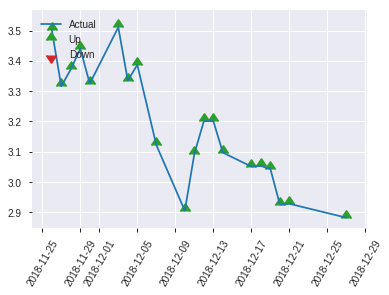


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25125151343921365
RMSE: 0.5012499510615573
LogLoss: 0.6963886395562889
Mean Per-Class Error: 0.44268372703412073
AUC: 0.5444225721784777
pr_auc: 0.513090799199292
Gini: 0.08884514435695534
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3179248869419098: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    126  0.9921   (126.0/127.0)
1      0    120  0        (0.0/120.0)
Total  1    246  0.5101   (126.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.317925     0.655738  245
max f2                       0.317925     0.826446  245
max f0point5                 0.416884     0.552083  209
max accuracy                 0.49856      0.558704  110
max precision                0.625078     0.631579  18
max recall                   0.317925     1         245
max specificity              0.764448     0.992126  0
max absolute_mcc             0.49856      0.115178  110
max min_per_class_accuracy   0.492546     0.541667  121
max mean_per_class_accuracy  0.49856      0.557316  110

Gains/Lift Table: Avg response rate: 48.58 %, avg score: 49.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.731584           0         0                  0                0.746262  0                           0.746262            0               0                          -100      -100
    2        0.0202429                   0.713444           2.05833   0.823333           1                0.725043  0.4                         0.737774            0.0166667       0.0166667                  105.833   -17.6667
    3        0.0323887                   0.683794           0.686111  0.771875           0.333333         0.696268  0.375                       0.72221             0.00833333      0.025                      -31.3889  -22.8125
    4        0.0404858                   0.681203           1.02917   0.823333           0.5              0.682753  0.4                         0.714318            0.00833333      0.0333333                  2.91667   -17.6667
    5        0.0526316                   0.643009           2.05833   1.10833            1                0.65725   0.538462                    0.701149            0.025           0.0583333                  105.833   10.8333
    6        0.101215                    0.587745           1.20069   1.15267            0.583333         0.618999  0.56                        0.661717            0.0583333       0.116667                   20.0694   15.2667
    7        0.149798                    0.560599           1.20069   1.16824            0.583333         0.573862  0.567568                    0.633224            0.0583333       0.175                      20.0694   16.8243
    8        0.202429                    0.549621           0.791667  1.07033            0.384615         0.555192  0.52                        0.612935            0.0416667       0.216667                   -20.8333  7.03333
    9        0.299595                    0.527198           1.28646   1.14043            0.625            0.53816   0.554054                    0.588684            0.125           0.341667                   28.6458   14.0428
    10       0.40081                     0.505864           0.988     1.10194            0.48             0.517373  0.535354                    0.570676            0.1             0.441667                   -1.2      10.1936
    11       0.502024                    0.490823           0.988     1.07897            0.48             0.498599  0.524194                    0.556144            0.1             0.541667                   -1.2      7.89651
    12       0.59919                     0.47223            0.943403  1.05698            0.458333         0.481778  0.513514                    0.544085            0.0916667       0.633333                   -5.65972  5.6982
    13       0.700405                    0.457757           0.988     1.04701            0.48             0.465006  0.508671                    0.532657            0.1             0.733333                   -1.2      4.70135
    14       0.797571                    0.426424           0.771875  1.01349            0.375            0.444681  0.492386                    0.521939            0.075           0.808333                   -22.8125  1.34941
    15       0.898785                    0.403429           1.07033   1.01989            0.52             0.416032  0.495495                    0.510013            0.108333        0.916667                   7.03333   1.98949
    16       1                           0.256508           0.823333  1                  0.4              0.375257  0.48583                     0.496374          

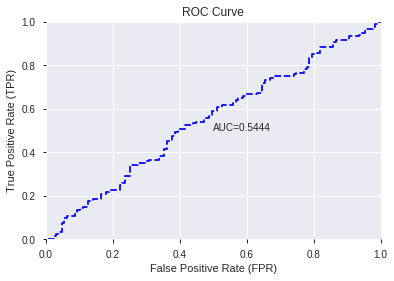

This function is available for GLM models only


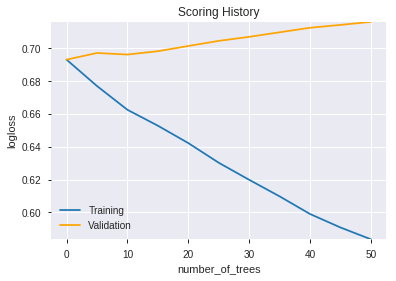

--2019-08-26 15:02:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.81.40
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.81.40|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

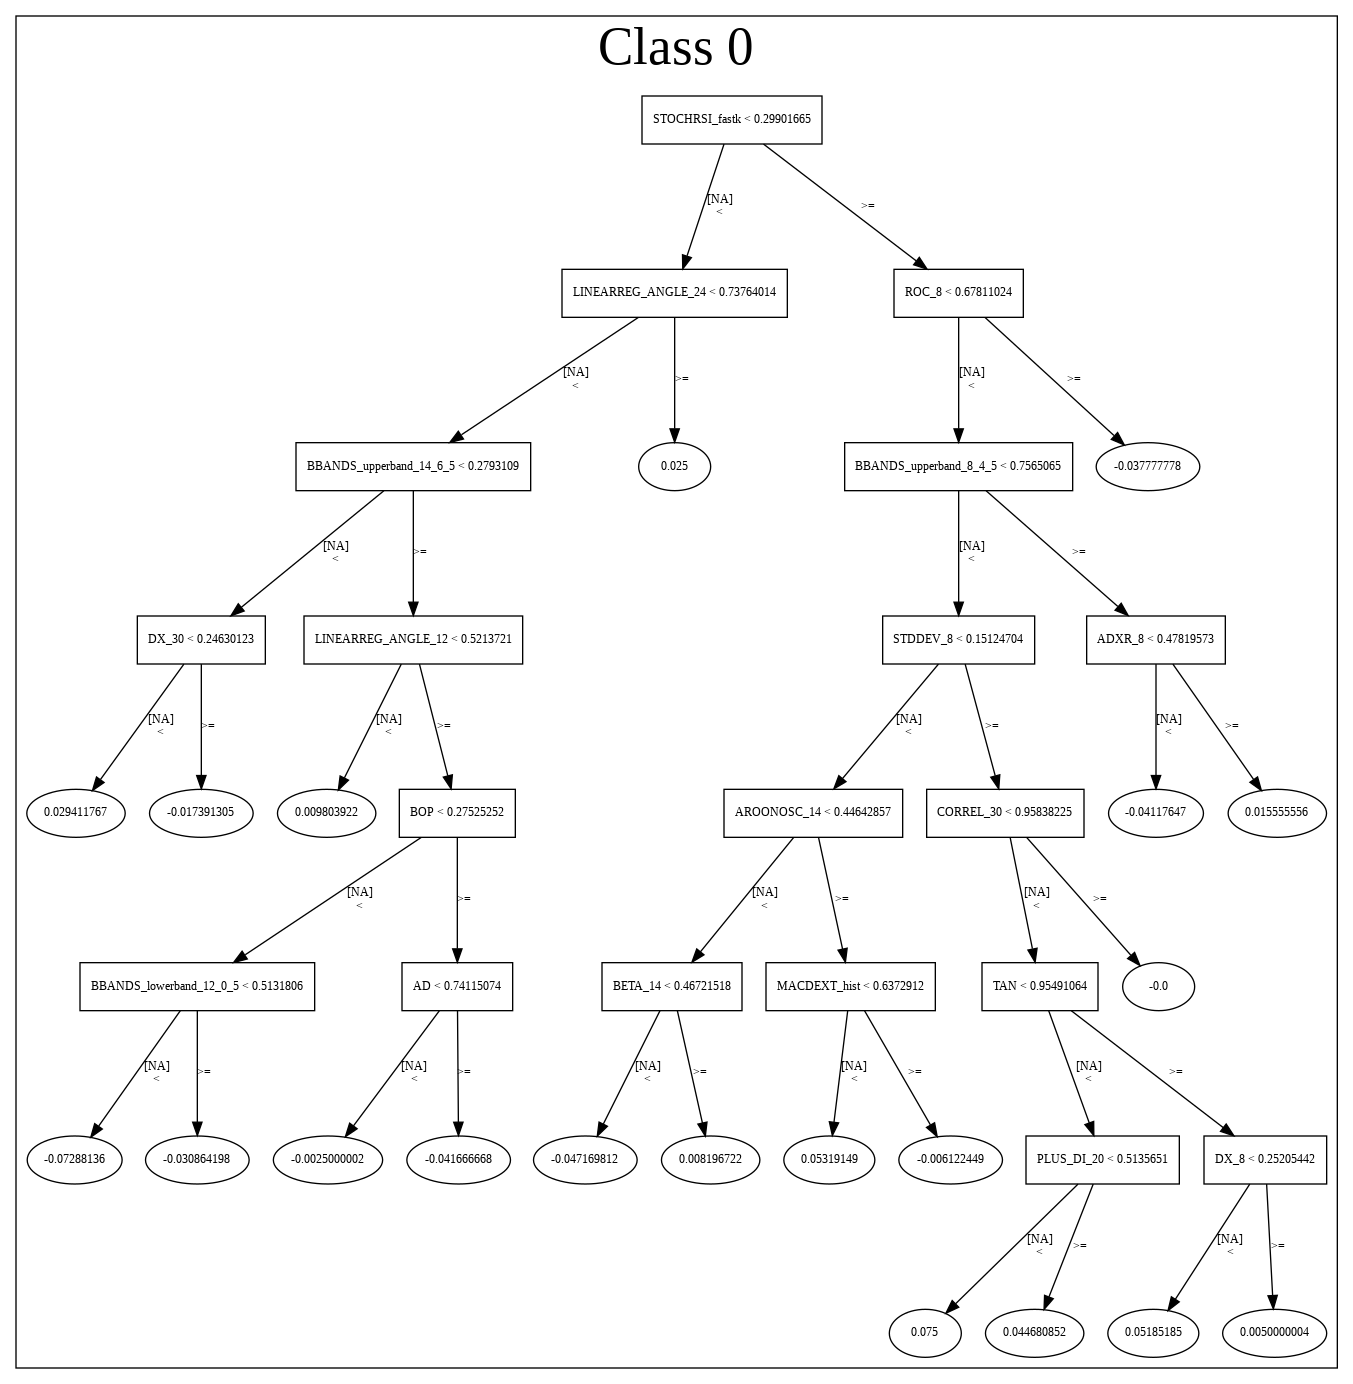

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_150202_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_150202_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a2a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['TRANGE',
 'ROCP_8',
 'DX_8',
 'CORREL_8',
 'BETA_12',
 'ATR_30',
 'NATR_30',
 'STOCH_slowd',
 'STOCHRSI_fastk',
 'MFI_8',
 'MACDEXT',
 'STDDEV_8',
 'MFI_30',
 'ATR_12',
 'AROONOSC_30',
 'ADOSC',
 'PLUS_DM_8',
 'TRIX_8',
 'CORREL_12',
 'STOCHF_fastk',
 'CCI_14',
 'TRIX_12',
 'BBANDS_lowerband_30_5_5',
 'MACDFIX_14',
 'BBANDS_upperband_20_3_2',
 'aroonup_30',
 'ADX_14',
 'ROC_30',
 'STOCH_slowk',
 'BOP',
 'MFI_14',
 'MINUS_DI_8',
 'MINUS_DM_30',
 'STOCHRSI_fastd',
 'DX_20',
 'MFI_20',
 'MINUS_DI_30',
 'LINEARREG_ANGLE_12',
 'CCI_8',
 'DX_24',
 'AROONOSC_24',
 'BBANDS_lowerband_20_5_5',
 'CMO_30',
 'BBANDS_upperband_24_7_5',
 'aroondown_20',
 'LINEARREG_12',
 'MOM_24',
 'ADX_8',
 'MINUS_DI_20',
 'PLUS_DI_12',
 'WILLR_14',
 'BBANDS_lowerband_20_6_2',
 'aroonup_12',
 'LINEARREG_INTERCEPT_12',
 'BBANDS_lowerband_14_1_5',
 'ADXR_8',
 'PLUS_DM_12',
 'ROC_12',
 'DX_12',
 'NATR_8',
 'aroondown_12',
 'aroondown_24',
 'LINEARREG_SLOPE_8',
 'CDLSPINNINGTOP',
 'PLUS_DI_20',
 'MACDEXT_signal',
 'RO

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.579
GLM             0.555
XGBoost         0.575
dtype: float64

DeepLearning    GLM  XGBoost
All          0.567  0.555    0.555
DLF          0.543  0.543    0.575
Fwe          0.559  0.555    0.555
RFE          0.579  0.530    0.559
XGBF         0.547  0.543    0.575





F1


DeepLearning    0.658
GLM             0.656
XGBoost         0.659
dtype: float64

DeepLearning    GLM  XGBoost
All          0.654  0.654    0.659
DLF          0.656  0.654    0.654
Fwe          0.655  0.654    0.659
RFE          0.658  0.656    0.656
XGBF         0.658  0.654    0.654





auc


DeepLearning    0.557
GLM             0.516
XGBoost         0.557
dtype: float64

DeepLearning    GLM  XGBoost
All          0.521  0.516    0.557
DLF          0.528  0.493    0.542
Fwe          0.539  0.516    0.557
RFE          0.557  0.492    0.544
XGBF         0.537  0.493    0.542





logloss


DeepLearning    1.528
GLM             0.698
XGBoost         0.702
dtype: float64

DeepLearning    GLM  XGBoost
All          1.528  0.698    0.692
DLF          0.733  0.694    0.702
Fwe          1.129  0.698    0.692
RFE          0.783  0.694    0.696
XGBF         0.696  0.694    0.702





mean_per_class_error


DeepLearning    0.455
GLM             0.473
XGBoost         0.443
dtype: float64

DeepLearning    GLM  XGBoost
All          0.436  0.450    0.437
DLF          0.455  0.469    0.428
Fwe          0.451  0.450    0.437
RFE          0.424  0.473    0.443
XGBF         0.451  0.469    0.428





rmse


DeepLearning    0.594
GLM             0.502
XGBoost         0.504
dtype: float64

DeepLearning    GLM  XGBoost
All          0.594  0.502    0.499
DLF          0.514  0.500    0.504
Fwe          0.557  0.502    0.499
RFE          0.528  0.500    0.501
XGBF         0.501  0.500    0.504





mse


DeepLearning    0.353
GLM             0.252
XGBoost         0.254
dtype: float64

DeepLearning    GLM  XGBoost
All          0.353  0.252    0.249
DLF          0.264  0.250    0.254
Fwe          0.310  0.252    0.249
RFE          0.279  0.250    0.251
XGBF         0.251  0.250    0.254

{'F1':       DeepLearning    GLM  XGBoost
 All          0.654    NaN      NaN
 DLF          0.656    NaN      NaN
 DLF            NaN  0.654      NaN
 DLF            NaN    NaN    0.654
 All            NaN  0.654      NaN
 All            NaN    NaN    0.659
 XGBF         0.658    NaN      NaN
 XGBF           NaN  0.654      NaN
 XGBF           NaN    NaN    0.654
 Fwe          0.655    NaN      NaN
 Fwe            NaN  0.654      NaN
 Fwe            NaN    NaN    0.659
 RFE          0.658    NaN      NaN
 RFE            NaN  0.656      NaN
 RFE            NaN    NaN    0.656,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.567    NaN      NaN
 DLF          0.543    NaN      NaN
 DLF            NaN  0.543      NaN
 DLF            NaN    NaN    0.575
 All            NaN  0.555      NaN
 All            NaN    NaN    0.555
 XGBF         0.547    NaN      NaN
 XGBF           NaN  0.543      NaN
 XGBF           NaN    NaN    0.575
 Fwe          0.559    NaN      NaN
 Fwe     